In [1]:
import sys
import os

# Get the absolute path to the root directory where UQ_toolbox.py is located
root_dir = os.path.abspath(os.path.join(os.path.dirname('medMNIST'), '..'))
sys.path.append(root_dir)

In [2]:
from adjustText import adjust_text
from medmnist import INFO
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import numpy as np
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, roc_auc_score, accuracy_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import matplotlib.pyplot as plt
import UQ_toolbox as uq
import pickle as pkl
import pandas as pd
from PIL import Image
from medMNIST.utils import train_load_datasets_resnet as tr

In [3]:
def test_eval(test_loader, device, models, data_flag):
    info = INFO[data_flag]
    task_type = info['task']  # Determine the task type (binary-class or multi-class)
    num_classes = len(info['label'])  # Number of classes

    # Perform inference on the test set
    y_true = []
    y_scores = []
    y_raw_digits = []
    indiv_scores = [[] for _ in range(len(models))]  # Store individual model scores

    for m in models:
        m.eval()

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = [model(data) for model in models]

            # Store individual model scores
            for i, output in enumerate(outputs):
                if task_type == 'binary-class':
                    indiv_scores[i].extend(F.sigmoid(output).cpu().numpy().flatten())
                else:
                    indiv_scores[i].extend(F.softmax(output, dim=1).cpu().numpy())

            # Average the outputs for ensemble prediction
            avg_output = torch.mean(torch.stack(outputs), dim=0)
            y_true.extend(target.cpu().numpy().flatten())
            if task_type == 'binary-class':
                avg_output_sig = F.sigmoid(avg_output)
                y_scores.extend(avg_output_sig.cpu().numpy().flatten())
                y_raw_digits.extend(avg_output.cpu().numpy().flatten())
            else:
                y_scores.extend(avg_output.cpu().numpy())
                y_raw_digits.extend(avg_output.cpu().numpy())

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    y_scores_raw_digits = np.array(y_raw_digits)

    if task_type == 'binary-class':
        y_pred = (y_scores > 0.5).astype(int)
        auc = roc_auc_score(y_true, y_scores)
    else:
        y_pred = np.argmax(y_scores, axis=1)
        # Calculate metrics
        auc = roc_auc_score(y_true, apply_softmax(y_scores), multi_class='ovr')
    acc = accuracy_score(y_true, y_pred)
    print(f'Ensemble AUC: {auc:.3f}, Ensemble Accuracy: {acc:.3f}')

    # Generate the confusion matrix
    if task_type == 'binary-class':
        cm = confusion_matrix(y_true, y_pred)
    else:
        cm = confusion_matrix(y_true, y_scores.argmax(axis=1))

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=info['label'].values(), yticklabels=info['label'].values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Compute balanced accuracy
    if task_type == 'binary-class':
        balanced_acc = balanced_accuracy_score(y_true, y_pred)
    else:
        balanced_acc = balanced_accuracy_score(y_true, y_scores.argmax(axis=1))

    # Compute sensitivity (recall)
    if task_type == 'binary-class':
        sensitivity = recall_score(y_true, y_pred, average='binary')
    else:
        sensitivity = recall_score(y_true, y_scores.argmax(axis=1), average='macro')
    

    # Compute specificity
    specificities = []
    for i in range(num_classes):
        if task_type == 'binary-class':
            cm = confusion_matrix(y_true, y_pred)
        else:
            cm = confusion_matrix(y_true, y_scores.argmax(axis=1))
        FP = np.sum(cm[:, i]) - cm[i, i]  # False Positives
        TN = np.sum(cm) - (np.sum(cm[i, :]) + FP)  # True Negatives
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 1.0
        specificities.append(specificity)

    macro_specificity = np.mean(specificities)

    perfs = {
        'auc': auc,
        'accuracy': acc,
        'balanced_accuracy': balanced_acc,
        'sensitivity': sensitivity,
        'specificity': macro_specificity,
        'confusion_matrix': cm
    }
    print(perfs)
    return y_true, y_scores, y_scores_raw_digits, indiv_scores, perfs

def apply_softmax(y):
    y_scores = np.array(F.softmax(torch.tensor(y), dim=1))
    return y_scores

In [4]:
def train_val_loaders(train_dataset, batch_size):
    # Create stratified K-fold cross-validator
    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Get the labels for stratification
    labels = [label for _, label in train_dataset]

    # Create a list to store the new dataloaders
    train_loaders = []
    val_loaders = []

    for train_index, val_index in skf.split(np.zeros(len(labels)), labels):
        train_subset = torch.utils.data.Subset(train_dataset, train_index)
        val_subset = torch.utils.data.Subset(train_dataset, val_index)
        
        train_loader = DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True, drop_last=True)
        val_loader = DataLoader(dataset=val_subset, batch_size=batch_size, shuffle=True, drop_last=True)
        
        train_loaders.append(train_loader)
        val_loaders.append(val_loader)
    return train_loaders, val_loaders

In [5]:
def find_best_threshold_and_compute_metrics(values, correct_predictions, optimization_metric='balanced_accuracy'):
    """
    Find the best threshold and compute metrics.

    Args:
        values (numpy.ndarray): UQ values.
        correct_predictions (list): Indices of correct predictions.
        optimization_metric (str): Metric to optimize ('balanced_accuracy', 'sensitivity', 'specificity').

    Returns:
        None
    """
    # Function to compute metrics
    def compute_metrics(uq_values, labels, threshold):
        predictions = (uq_values <= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        balanced_acc = balanced_accuracy_score(labels, predictions)
        return tn, fp, fn, tp, specificity, sensitivity, balanced_acc

    # Update the function to handle ties in specificity or sensitivity
    def find_optimal_threshold(uq_values, labels, metric):
        thresholds = np.linspace(min(uq_values), max(uq_values), 1000)
        best_threshold = thresholds[0]
        best_metric_value = 0
        best_secondary_metric_value = 0

        for threshold in thresholds:
            _, _, _, _, specificity, sensitivity, balanced_acc = compute_metrics(uq_values, labels, threshold)

            if metric == 'balanced_accuracy' and balanced_acc > best_metric_value:
                best_metric_value = balanced_acc
                best_threshold = threshold
            elif metric == 'sensitivity':
                if sensitivity > best_metric_value or (sensitivity == best_metric_value and specificity > best_secondary_metric_value):
                    best_metric_value = sensitivity
                    best_secondary_metric_value = specificity
                    best_threshold = threshold
            elif metric == 'specificity':
                if specificity > best_metric_value or (specificity == best_metric_value and sensitivity > best_secondary_metric_value):
                    best_metric_value = specificity
                    best_secondary_metric_value = sensitivity
                    best_threshold = threshold

        return best_threshold

    # Find the optimal threshold
    labels = np.array([1 if i in correct_predictions else 0 for i in range(len(values))])
    optimal_threshold = find_optimal_threshold(values, labels, optimization_metric)

    # Compute the confusion matrix using the optimal threshold
    predictions = (values <= optimal_threshold).astype(int)
    cm = confusion_matrix(labels, predictions)
    
    # Display the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 36}, xticklabels=['Failure', 'Success'], yticklabels=['Failure', 'Success'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Print the optimal threshold and metrics
    _, _, _, _, specificity, sensitivity, balanced_acc = compute_metrics(values, labels, optimal_threshold)
    
    print(f"Optimal Threshold: {optimal_threshold}")
    print(f"Balanced Accuracy: {balanced_acc}")
    print(f"Specificity: {specificity}")
    print(f"Sensitivity: {sensitivity}")

    return balanced_acc

In [6]:
def computeMSR(y_prob, y_true, task_type, calibration_needed=False, method_calibration=None, display_calibration_curve=False, y_scores_calibration=None, y_true_calibration=None):
    if calibration_needed:
            # Perform post-hoc calibration using the calibration dataset
            calibrated_scores, calibration_model = uq.posthoc_calibration(y_scores_calibration, y_true_calibration, method_calibration)
            logits_tensor = torch.from_numpy(y_prob).float()
            if method_calibration == 'temperature':
                if logits_tensor.ndim == 1:
                    logits_tensor = logits_tensor.unsqueeze(1)
                logits_test_scaled = calibration_model(logits_tensor).squeeze()

                if logits_test_scaled.ndim == 1 or logits_test_scaled.shape[1] == 1:
                    # Binary case → use sigmoid
                    calibrated_test_scores = torch.sigmoid(logits_test_scaled).detach().numpy().squeeze().squeeze()
                else:
                    # Multiclass → use softmax
                    calibrated_test_scores = torch.nn.functional.softmax(logits_test_scaled, dim=1).detach().numpy()

            else:
                if logits_tensor.ndim == 1:
                    logits_tensor = logits_tensor.unsqueeze(1)
                calibrated_test_scores = calibration_model.predict_proba(logits_tensor.reshape(-1, 1))[:, 1]

            metric = uq.distance_to_hard_labels_computation(calibrated_test_scores)
            if display_calibration_curve:
                uq.model_calibration_plot(y_true, calibrated_test_scores)
    else:
        metric = uq.distance_to_hard_labels_computation(y_prob)
        if display_calibration_curve:
            uq.model_calibration_plot(y_true, y_prob)
    
    return metric

def compute_ensembling(indiv_scores):
    metric = uq.ensembling_stds_computation(indiv_scores)
    return metric
    
def computeKNNshap(models, train_loaders, test_loader, device, num_classes=None, latent_spaces=None, shap_values_folds=None, labels_folds=None, shap=True):
    if shap:
        mean_shap_importances = []
        if num_classes == 2:
            for fold, (shap_values, labels) in enumerate(zip(shap_values_folds, labels_folds)):
                mean_shap_fold = uq.compute_mean_shap_values(shap_values, fold, labels, 50)
                mean_shap_importances.append(mean_shap_fold)
        else:
            for fold, shap_values in enumerate(shap_values_folds):
                mean_shap_fold = uq.compute_mean_shap_values(shap_values, fold, true_labels=None, nb_features=50)
                mean_shap_importances.append(mean_shap_fold)

        latent_spaces_df = []
        for fold, latent_space in enumerate(latent_spaces):
            num_samples, num_features = latent_space.shape
            latent_space_df = pd.DataFrame(
                latent_space,
                columns=[f"Feature_{i}" for i in range(num_features)]
            )
            latent_spaces_df.append(latent_space_df)

        plt.close('all')
        successes_folds = []
        knn_distances_folds = []

        for fold in range(5):
            knn_distances_all, successes_all = uq.compute_knn_distances_to_train_data(models[fold], train_loaders[fold], test_loader, models[fold].avgpool, device, latent_spaces_df[fold], mean_shap_importances[fold], num_classes)
            knn_distances_folds.append(knn_distances_all)
            successes_folds.append(successes_all)
        
        # Calculate the mean of the lists inside knn_distances_folds
        metric = np.mean(knn_distances_folds, axis=0)

    else:
        knn_distances_all = []
        for fold in range(5):
            latent_space_training, _, _, _ = uq.extract_latent_space_and_compute_shap_importance(
                model=models[fold],
                data_loader=train_loaders[fold],
                device=device,
                layer_to_be_hooked=models[fold].avgpool,
                importance=False
            )
            
            latent_space_test, _, _, _ = uq.extract_latent_space_and_compute_shap_importance(
                model=models[fold],
                data_loader=test_loader,
                device=device,
                layer_to_be_hooked=models[fold].avgpool,
                importance=False
            )
            
            train_latent_space = pd.DataFrame(latent_space_training)
            test_latent_space = pd.DataFrame(latent_space_test)
                
            # Print the initial number of dimensions
            print(f"Initial number of dimensions: {train_latent_space.shape[1]}")
                
            scaler = StandardScaler()
            train_latent_space_standardized = scaler.fit_transform(train_latent_space)
            
            pca = PCA(n_components=0.8)
            train_latent_space_pca = pca.fit_transform(train_latent_space_standardized)
            
            # Print the number of dimensions after PCA
            print(f"Number of dimensions after PCA: {train_latent_space_pca.shape[1]}")
            
            test_latent_space_standardized = scaler.transform(test_latent_space)
            test_latent_space_pca = pca.transform(test_latent_space_standardized)
            
            knn = NearestNeighbors(n_neighbors=5)
            knn.fit(train_latent_space_pca)
            distances, _ = knn.kneighbors(test_latent_space_pca)
            
            average_distances = distances.mean(axis=1)
            
            knn_distances_all.append(average_distances)
            # Calculate the mean of the lists inside knn_distances_folds
            metric = np.mean(knn_distances_all, axis=0)

    return metric

def remove_black_borders(pil_img, padding=2):
    """Removes black borders from a PIL image and resizes back to original size."""
    img_np = np.array(pil_img)
    
    # Handle grayscale (2D) or RGB (3D)
    if img_np.ndim == 2:
        mask = img_np != 0
    else:
        mask = np.any(img_np != 0, axis=2)

    if not np.any(mask):
        return pil_img  # Totally black

    coords = np.argwhere(mask)
    y0, x0 = coords.min(axis=0)
    y1, x1 = coords.max(axis=0) + 1

    # Pad the crop box
    y0 = max(y0 - padding, 0)
    x0 = max(x0 - padding, 0)
    y1 = min(y1 + padding, pil_img.height)
    x1 = min(x1 + padding, pil_img.width)

    cropped = pil_img.crop((x0, y0, x1, y1))
    return cropped.resize((pil_img.width, pil_img.height), resample=Image.BILINEAR)

def computeTTA(aug_type, models, test_dataset, device, num_classes=2, correct_predictions_calibration=None, incorrect_predictions_calibration=None, image_normalization=False, aug_folder=None, mean=[0.5], std=[0.5], max_iterations=10, gps_augment=None, batch_size=None, color=False, im_size=None):
    if num_classes == 2:
        output_activation='sigmoid'
    else:
        output_activation='softmax'
    if aug_type == 'randaugment':
        # Original RandAugment (may include geometric transforms)
        transformation_pipeline = transforms.Compose([
            transforms.ToTensor(),
            transforms.ToPILImage(),
            transforms.RandAugment(num_ops=2, magnitude=9, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.PILToTensor(),
            transforms.ConvertImageDtype(torch.float),
            *([transforms.Normalize(mean=mean, std=std)] if image_normalization else []),
            *([transforms.Lambda(lambda x: x.repeat(3, 1, 1))] if color is False else [])
        ])
        metric, global_preds = uq.TTA(transformation_pipeline, models, test_dataset, device, nb_augmentations=5, nb_channels=3, output_activation=output_activation, usingBetterRandAugment=False, mean=mean, std=std, batch_size=batch_size)
    
    elif aug_type == 'randaugment_without_geometric_transforms':
        
        transformation_pipeline = transforms.Compose([
            transforms.ToTensor(),
            transforms.ToPILImage(),
            transforms.RandAugment(num_ops=2, magnitude=9, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.Lambda(remove_black_borders),
            transforms.PILToTensor(),
            transforms.ConvertImageDtype(torch.float),
            *([transforms.Normalize(mean=mean, std=std)] if image_normalization else []),
            *([transforms.Lambda(lambda x: x.repeat(3, 1, 1))] if color is False else [])
        ])
        metric, global_preds = uq.TTA(transformation_pipeline, models, test_dataset, device, nb_augmentations=5, nb_channels=3, output_activation=output_activation, usingBetterRandAugment=False, mean=mean, std=std, batch_size=batch_size)
        
    elif aug_type == 'crops_flips':
        transformation_pipeline = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomResizedCrop(size=20, scale=(0.8, 1.0)),  # Random crop with resizing
            transforms.RandomHorizontalFlip(p=0.5),                   # Random horizontal flip
            transforms.RandomRotation(degrees=180),
            transforms.PILToTensor(),
            transforms.ConvertImageDtype(torch.float)
        ])
        metric, global_preds = uq.TTA(transformation_pipeline, models, test_dataset, device, nb_augmentations=5, nb_channels=3, output_activation=output_activation, usingBetterRandAugment=False, mean=mean, std=std, batch_size=batch_size)
        
    elif aug_type == 'GPS':
        if gps_augment is None:
            best_aug = uq.perform_greedy_policy_search(aug_folder, correct_predictions_calibration, incorrect_predictions_calibration, num_workers=90, max_iterations=max_iterations, num_searches=30, top_k=5, plot=True)
            if isinstance(best_aug, list) and all(isinstance(policy, list) for policy in best_aug):
                transformation_pipeline = []
                for aug in best_aug:
                    n, m, transformations = uq.extract_gps_augmentations_info(aug)
                    transformation_pipeline.append(transformations)
        else:
            n = gps_augment[0]
            m = gps_augment[1]
            transformation_pipeline = gps_augment[2]
        metric, global_preds_GPS = uq.TTA(transformation_pipeline, models, test_dataset, device, usingBetterRandAugment=True, n=n, m=m, nb_channels=3, image_size=im_size, image_normalization=image_normalization, output_activation=output_activation, mean=mean, std=std, batch_size=batch_size)
    
    return metric

In [7]:
def display_UQ_results(metric, correct_predictions, incorrect_predictions, y_axis_title, title, optim_metric, swarmplot=False):
    balanced_acc = find_best_threshold_and_compute_metrics(metric, correct_predictions, optim_metric)
    fpr, tpr, auc = uq.roc_curve_UQ_method_computation([metric[k] for k in correct_predictions], [metric[j] for j in incorrect_predictions])
    uq.UQ_method_plot([metric[k] for k in correct_predictions], [metric[j] for j in incorrect_predictions], y_axis_title, title, swarmplot)
    print(auc)
    return auc, balanced_acc

In [8]:
def call_UQ_methods(
    methods,
    models=None,
    y_prob=None,
    digits=None,
    y_true=None,
    digits_calib=None,
    y_true_calibration=None,
    indiv_scores=None,
    task_type=None,
    correct_predictions=None,
    incorrect_predictions=None,
    test_loader=None,
    device=None,
    optim_metric=None,
    train_loaders=None,
    test_dataset_tta=None,
    num_classes=None,
    latent_spaces=None,
    shap_values_folds=None,
    labels_fold=None,
    correct_predictions_calibration=None,
    incorrect_predictions_calibration=None,
    image_normalization=False,
    color=False,
    aug_folder=None,
    gps_augment=None,
    max_iteration=10,
    swarmplot=True,
    calib_method='temperature',
    batch_size=None,
    image_size=None
):
    metrics = []
    methods = methods or []
    aucs = []
    balanced_acc = []

    for method in methods:
        if task_type == 'binary-class':
            y_axis = 'min(y_pred, 1-y_pred)'
            title = 'DHL'
        else:
            y_axis = '1-y_pred'
            title = 'MSR'
        if method == 'MSR':
            if y_prob is not None and y_true is not None and task_type is not None:
                metric = computeMSR(y_prob, y_true, task_type, calibration_needed=False, display_calibration_curve=True)
                auc, b_acc = display_UQ_results(metric, correct_predictions, incorrect_predictions, y_axis, title, optim_metric=optim_metric, swarmplot=swarmplot)
                aucs.append((method, auc))
                balanced_acc.append((method, b_acc))
                metrics.append((method, metric))
        elif method == 'MSR_temp_scale':
            if digits is not None and y_true is not None and task_type is not None and digits_calib is not None and y_true_calibration is not None:
                metric = computeMSR(digits, y_true, task_type, calibration_needed=True, display_calibration_curve=True, method_calibration=calib_method, y_scores_calibration=digits_calib, y_true_calibration=y_true_calibration)
                auc, b_acc = display_UQ_results(metric, correct_predictions, incorrect_predictions, y_axis, title + ' after temperature scaling', optim_metric=optim_metric, swarmplot=swarmplot)
                aucs.append((method, auc))
                balanced_acc.append((method, b_acc))
                metrics.append((method, metric))
        elif method == 'Ensembling':
            if indiv_scores is not None:
                metric = compute_ensembling(indiv_scores)
                auc, b_acc = display_UQ_results(metric, correct_predictions, incorrect_predictions, 'std', 'Ensembling Results', optim_metric=optim_metric, swarmplot=swarmplot)
                aucs.append((method, auc))
                balanced_acc.append((method, b_acc))
                metrics.append((method, metric))
        elif method == 'TTA':
            if models is not None and test_dataset_tta is not None and device is not None:
                metric = computeTTA('randaugment', models, test_dataset_tta, device, num_classes=num_classes, image_normalization=image_normalization, batch_size=batch_size, color=color)
                auc, b_acc = display_UQ_results(metric, correct_predictions, incorrect_predictions, 'std', 'TTA', optim_metric=optim_metric, swarmplot=swarmplot)
                aucs.append((method, auc))
                balanced_acc.append((method, b_acc))
                metrics.append((method, metric))
        elif method == 'TTA_without_geometric_transforms':
            if models is not None and test_dataset_tta is not None and device is not None:
                metric = computeTTA('randaugment_without_geometric_transforms', models, test_dataset_tta, device, num_classes=num_classes, image_normalization=image_normalization, batch_size=batch_size, color=color)
                auc, b_acc = display_UQ_results(metric, correct_predictions, incorrect_predictions, 'std', 'TTA_no_geom_transforms', optim_metric=optim_metric, swarmplot=swarmplot)
                aucs.append((method, auc))
                balanced_acc.append((method, b_acc))
                metrics.append((method, metric))
        elif method == 'GPS':
            if models is not None and test_dataset_tta is not None and device is not None:
                metric = computeTTA('GPS', models, test_dataset_tta, device, num_classes=num_classes, correct_predictions_calibration=correct_predictions_calibration, incorrect_predictions_calibration=incorrect_predictions_calibration, image_normalization=image_normalization, aug_folder=aug_folder, max_iterations=max_iteration, gps_augment=gps_augment, im_size=image_size, batch_size=batch_size)
                auc, b_acc = display_UQ_results(metric, correct_predictions, incorrect_predictions, 'std', 'GPS', optim_metric=optim_metric, swarmplot=swarmplot)
                aucs.append((method, auc))
                balanced_acc.append((method, b_acc))
                metrics.append((method, metric))
        elif method == 'KNNshap':
            if models is not None and train_loaders is not None and test_loader is not None and device is not None and num_classes is not None and latent_spaces is not None and shap_values_folds is not None:
                metric = computeKNNshap(models, train_loaders, test_loader, device, num_classes, latent_spaces, shap_values_folds, labels_folds=labels_fold, shap=True)
                auc, b_acc = display_UQ_results(metric, correct_predictions, incorrect_predictions, 'KNN distances after features selection', 'KNNshap', optim_metric=optim_metric, swarmplot=swarmplot)
                aucs.append((method, auc))
                balanced_acc.append((method, b_acc))
                metrics.append((method, metric))
        elif method == 'KNNall':
            if models is not None and train_loaders is not None and test_loader is not None and device is not None:
                metric = computeKNNshap(models, train_loaders, test_loader, device, shap=False)
                auc, b_acc = display_UQ_results(metric, correct_predictions, incorrect_predictions, 'KNN distances', 'KNNall', optim_metric=optim_metric, swarmplot=swarmplot)
                aucs.append((method, auc))
                balanced_acc.append((method, b_acc))
                metrics.append((method, metric))
    return metrics, aucs, balanced_acc

In [ ]:
flags = ['breastmnist', 'organamnist', 'pneumoniamnist', 'dermamnist', 'octmnist', 'pathmnist', 'bloodmnist', 'tissuemnist']
calib_method = ['platt', 'temperature', 'platt', 'temperature', 'temperature', 'temperature', 'temperature', 'temperature']
colors = [False, False, False, True, False, True, True, False]  # Colors for the flags
activations = ['sigmoid', 'softmax', 'sigmoid', 'softmax', 'softmax', 'softmax', 'softmax', 'softmax']  # Output activations for each flag
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

size = 224  # Image size for the models
batch_size = 4000  # Batch size for the DataLoader
indices_scores = {}

for flag, color, activation, calib_method in zip(flags, colors, activations, calib_method):
    print(f"Processing {flag} with color={color} and activation={activation}")
    if color is True:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])
        ])
        
        transform_tta = transforms.Compose([
            transforms.ToTensor()
        ])
    else:
        # For grayscale images, repeat the single channel to make it compatible with ResNet
        # ResNet expects 3 channels, so we repeat the single channel image
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[.5], std=[.5]),
            transforms.Lambda(lambda x: x.repeat(3, 1, 1))
        ])
        
        transform_tta = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.repeat(3, 1, 1))
            ])
    models = tr.load_models(flag, device=device)
    [train_dataset, calibration_dataset, test_dataset], [train_loader, calibration_loader, test_loader], info = tr.load_datasets(flag, color, size, transform, batch_size)
    train_loaders, val_loaders = train_val_loaders(train_dataset, batch_size=batch_size)
    task_type = info['task']  # Determine the task type (binary-class or multi-class)
    num_classes = len(info['label'])  # Number of classes
    [_, calibration_dataset_tta, test_dataset_tta], [_, calibration_loader_tta, test_loader_tta], _ = tr.load_datasets(flag, color, size, transform_tta, batch_size)

    y_true, y_scores, digits, indiv_scores, performances = test_eval(test_loader, device=device, models=models, data_flag=flag)
    y_true_calibration, y_scores_calibration, digits_calib, indiv_scores_calib, performances_calib = test_eval(calibration_loader, device=device, models=models, data_flag=flag)
    indices_scores[flag] = {}
    indices_scores[flag]['y_true'] = y_true
    indices_scores[flag]['y_scores'] = y_scores

with open("model_scores_augmented.pkl", "wb") as f:
    pkl.dump(indices_scores, f)


Processing breastmnist with color=False and activation=sigmoid
Training dataset size: 499
Calibration dataset size: 125
Training dataset size: 499
Calibration dataset size: 125
Ensemble AUC: 0.919, Ensemble Accuracy: 0.885


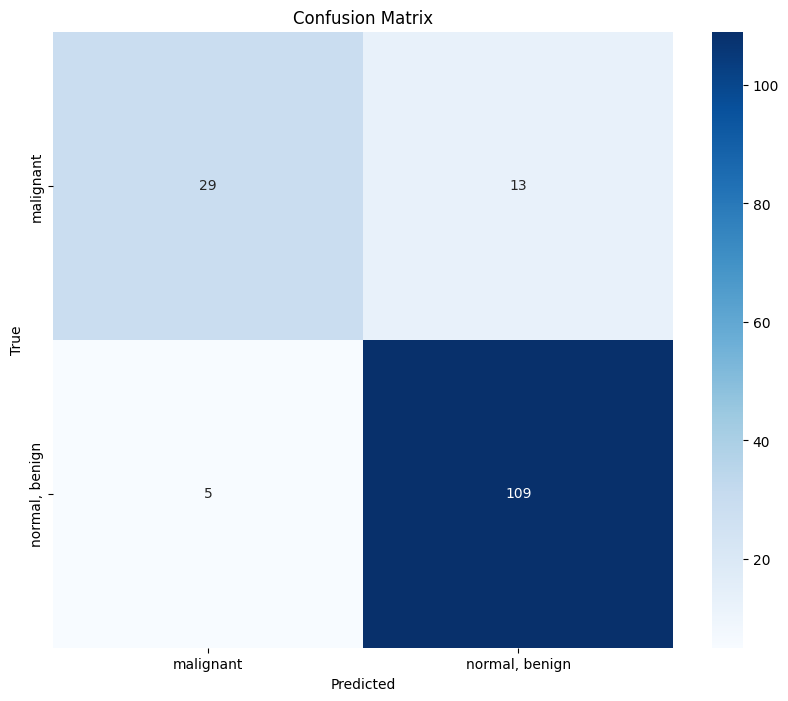

{'auc': np.float64(0.918546365914787), 'accuracy': 0.8846153846153846, 'balanced_accuracy': np.float64(0.8233082706766917), 'sensitivity': 0.956140350877193, 'specificity': np.float64(0.8233082706766917), 'confusion_matrix': array([[ 29,  13],
       [  5, 109]])}
Ensemble AUC: 0.964, Ensemble Accuracy: 0.912


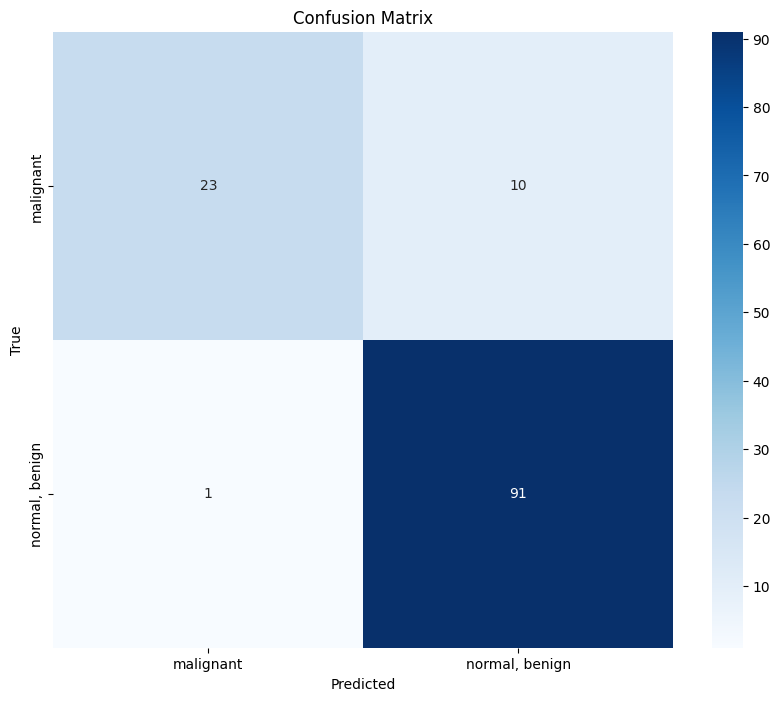

{'auc': np.float64(0.963768115942029), 'accuracy': 0.912, 'balanced_accuracy': np.float64(0.8430500658761528), 'sensitivity': 0.9891304347826086, 'specificity': np.float64(0.8430500658761528), 'confusion_matrix': array([[23, 10],
       [ 1, 91]])}


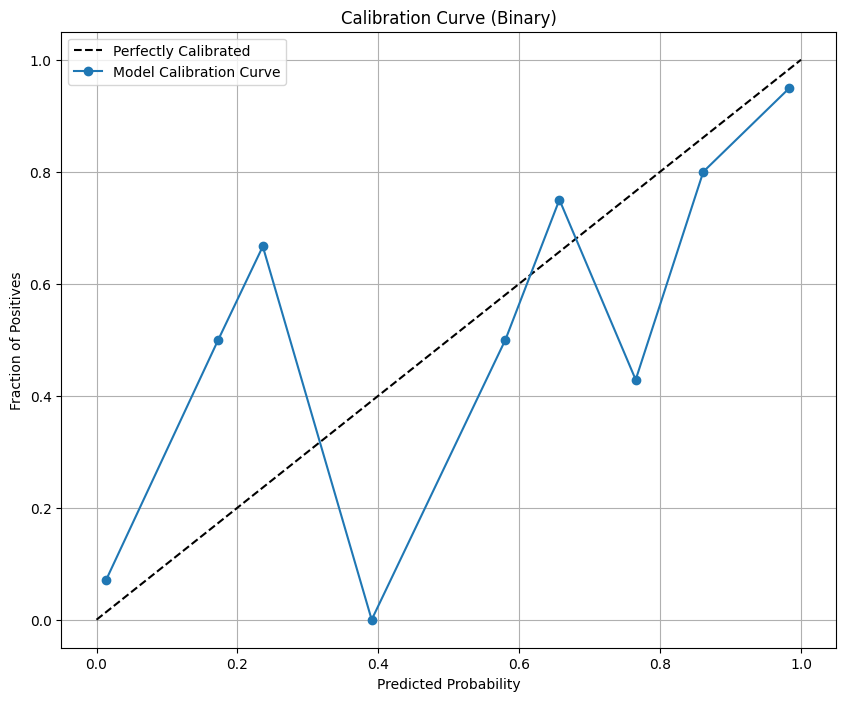

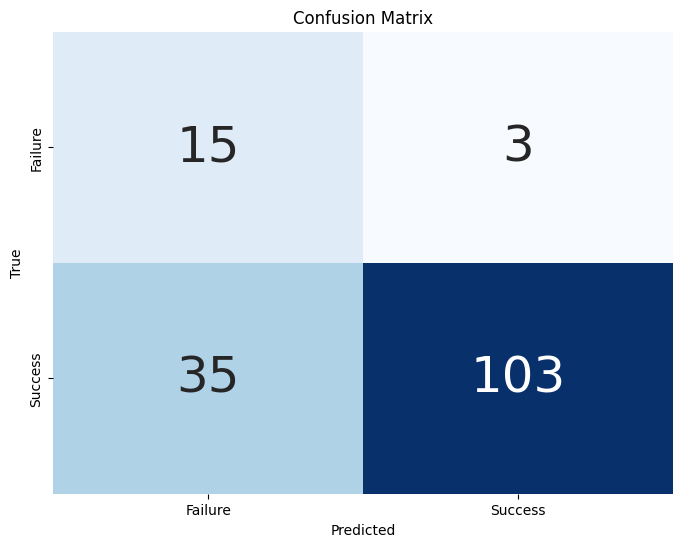

Optimal Threshold: 0.029684601351618767
Balanced Accuracy: 0.7898550724637681
Specificity: 0.8333333333333334
Sensitivity: 0.7463768115942029


/mnt/data/psteinmetz/computer_vision_code/code/UQ_Toolbox/UQ_toolbox.py:581: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


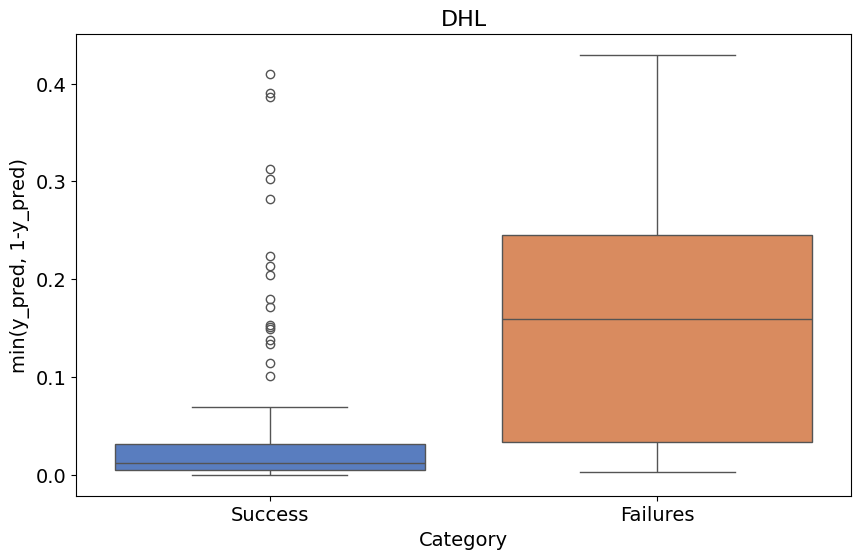

0.7954911433172304
Brier Score Loss (platt): 0.0828


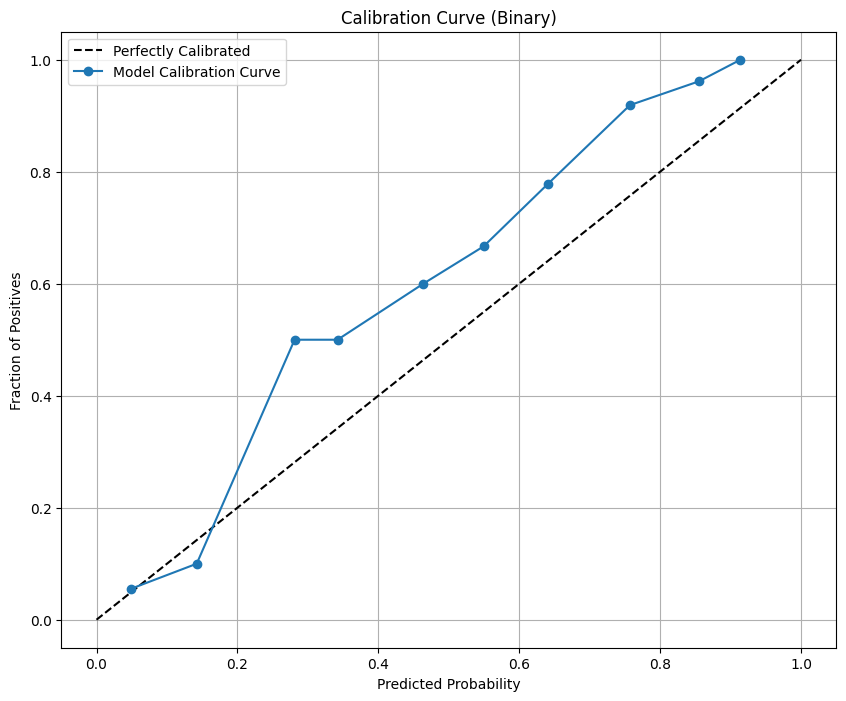

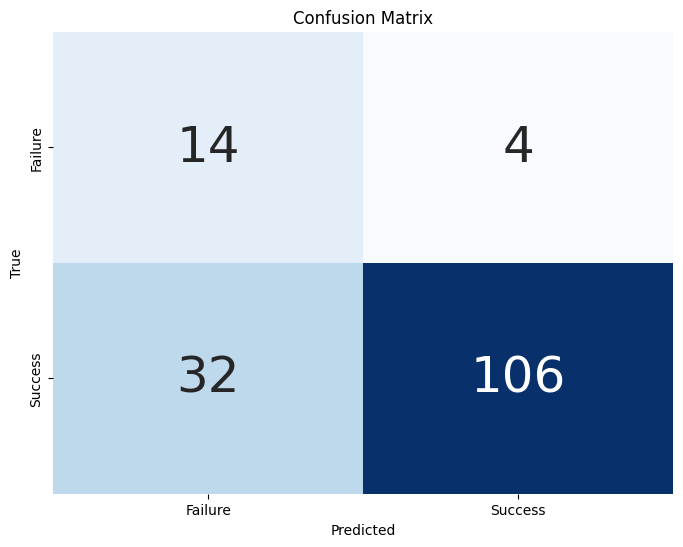

Optimal Threshold: 0.24766321219337176
Balanced Accuracy: 0.7729468599033816
Specificity: 0.7777777777777778
Sensitivity: 0.7681159420289855


/mnt/data/psteinmetz/computer_vision_code/code/UQ_Toolbox/UQ_toolbox.py:581: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


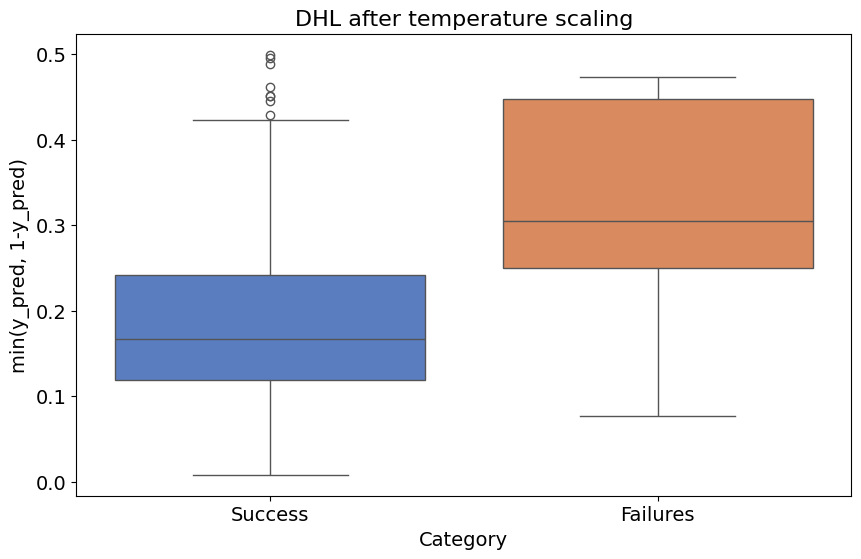

0.7628824476650563


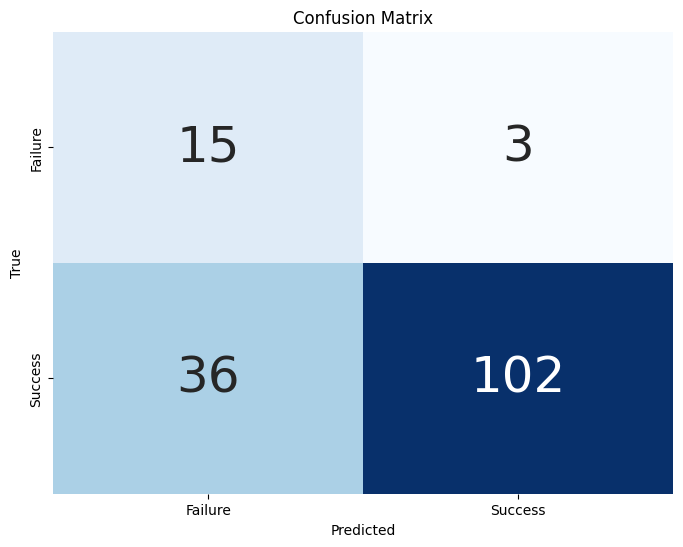

Optimal Threshold: 0.03649124130606651
Balanced Accuracy: 0.786231884057971
Specificity: 0.8333333333333334
Sensitivity: 0.7391304347826086


/mnt/data/psteinmetz/computer_vision_code/code/UQ_Toolbox/UQ_toolbox.py:581: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


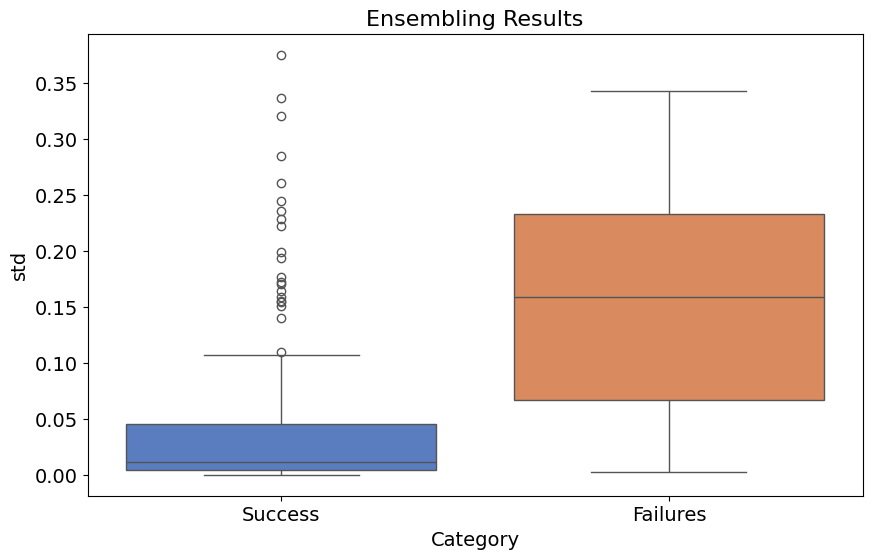

0.8099838969404186
Applying augmentation n : 0
Applying augmentation n : 0
Applying augmentation n : 0
Applying augmentation n : 0
Applying augmentation n : 0


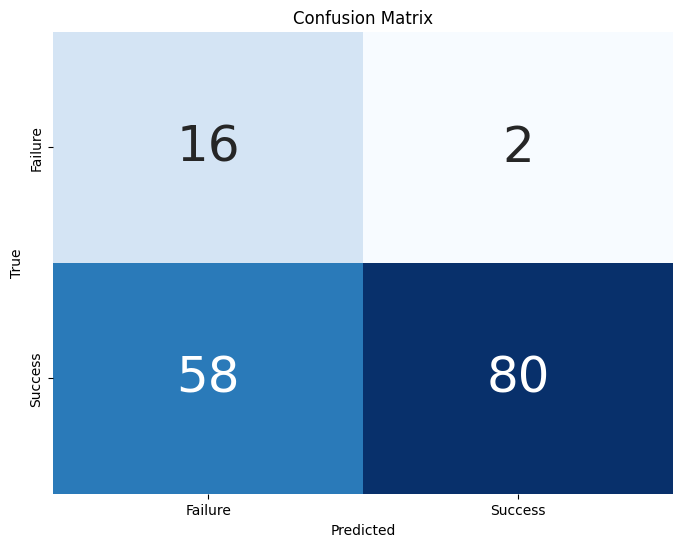

Optimal Threshold: 0.02314388394935141
Balanced Accuracy: 0.7342995169082125
Specificity: 0.8888888888888888
Sensitivity: 0.5797101449275363


/mnt/data/psteinmetz/computer_vision_code/code/UQ_Toolbox/UQ_toolbox.py:581: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


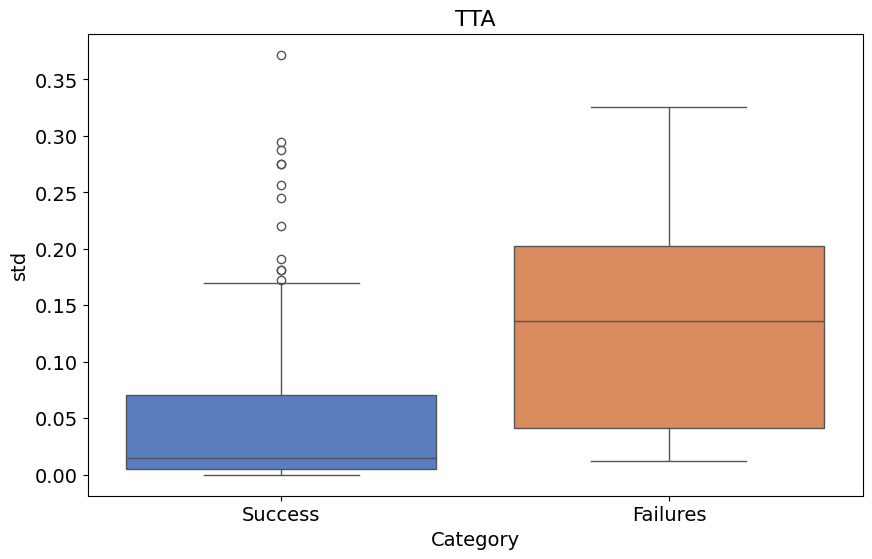

0.8007246376811594
Processing organamnist with color=False and activation=softmax
Training dataset size: 32841
Calibration dataset size: 8211
Training dataset size: 32841
Calibration dataset size: 8211


/tmp/ipykernel_2674608/3830283869.py:105: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


Ensemble AUC: 0.998, Ensemble Accuracy: 0.968


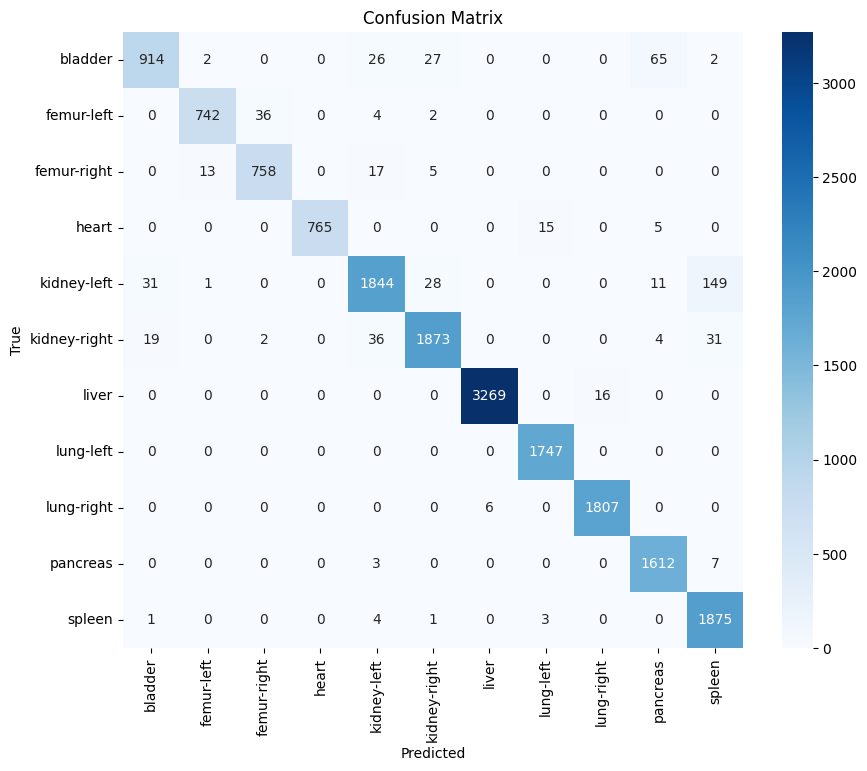

{'auc': np.float64(0.9982117668828482), 'accuracy': 0.9678254021824727, 'balanced_accuracy': np.float64(0.962411201378954), 'sensitivity': 0.962411201378954, 'specificity': np.float64(0.9967610962391528), 'confusion_matrix': array([[ 914,    2,    0,    0,   26,   27,    0,    0,    0,   65,    2],
       [   0,  742,   36,    0,    4,    2,    0,    0,    0,    0,    0],
       [   0,   13,  758,    0,   17,    5,    0,    0,    0,    0,    0],
       [   0,    0,    0,  765,    0,    0,    0,   15,    0,    5,    0],
       [  31,    1,    0,    0, 1844,   28,    0,    0,    0,   11,  149],
       [  19,    0,    2,    0,   36, 1873,    0,    0,    0,    4,   31],
       [   0,    0,    0,    0,    0,    0, 3269,    0,   16,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0, 1747,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    6,    0, 1807,    0,    0],
       [   0,    0,    0,    0,    3,    0,    0,    0,    0, 1612,    7],
       [   1,    0,    0,

/tmp/ipykernel_2674608/3830283869.py:105: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


Ensemble AUC: 1.000, Ensemble Accuracy: 0.997


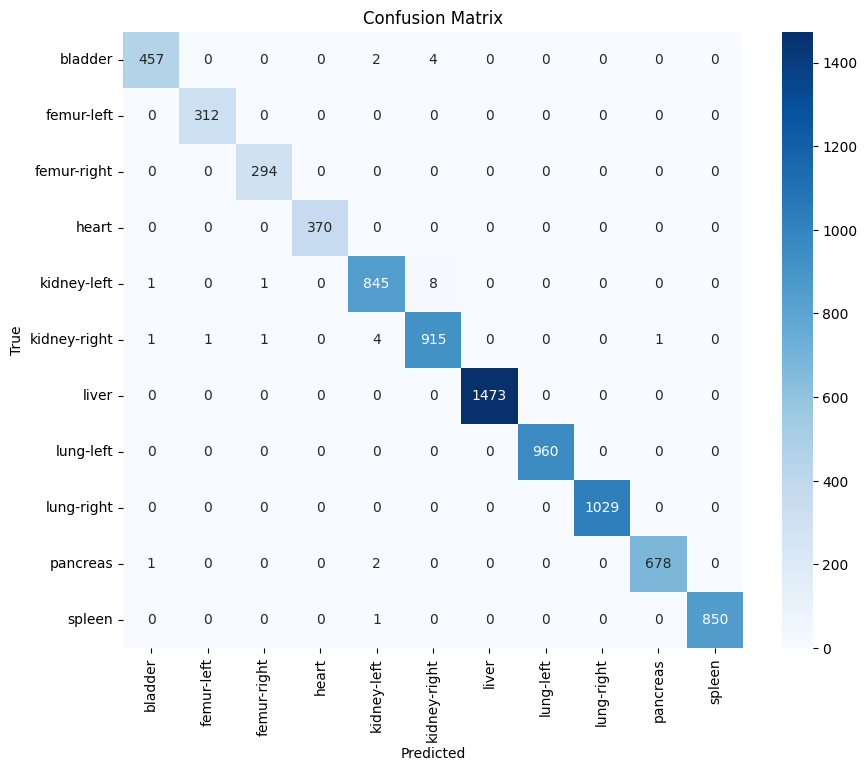

{'auc': np.float64(0.9999229886205666), 'accuracy': 0.9965899403239556, 'balanced_accuracy': np.float64(0.9964633969872739), 'sensitivity': 0.9964633969872739, 'specificity': np.float64(0.9996573407858546), 'confusion_matrix': array([[ 457,    0,    0,    0,    2,    4,    0,    0,    0,    0,    0],
       [   0,  312,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,  294,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,  370,    0,    0,    0,    0,    0,    0,    0],
       [   1,    0,    1,    0,  845,    8,    0,    0,    0,    0,    0],
       [   1,    1,    1,    0,    4,  915,    0,    0,    0,    1,    0],
       [   0,    0,    0,    0,    0,    0, 1473,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,  960,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0, 1029,    0,    0],
       [   1,    0,    0,    0,    2,    0,    0,    0,    0,  678,    0],
       [   0,    0,    

/tmp/ipykernel_2674608/3830283869.py:105: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


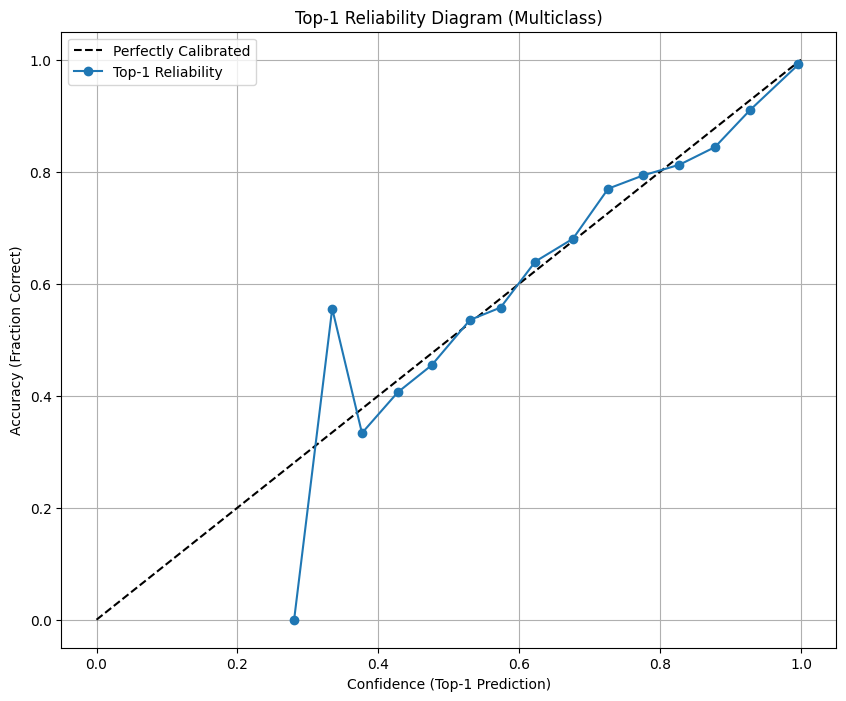

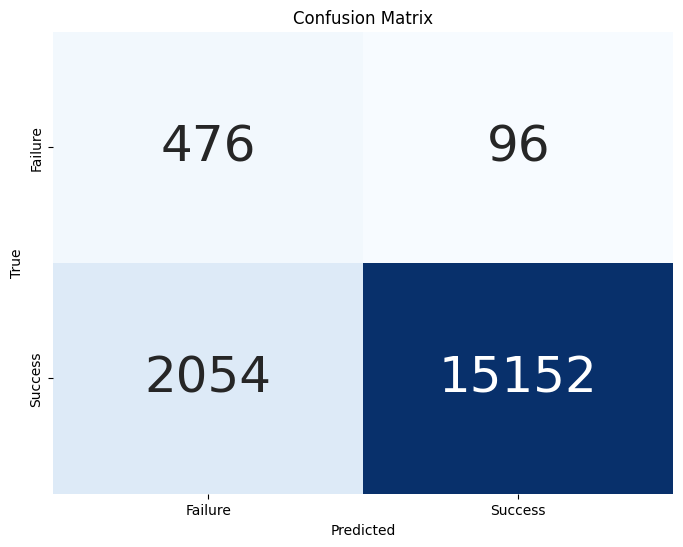

Optimal Threshold: 0.02160734497010708
Balanced Accuracy: 0.8563954353213914
Specificity: 0.8321678321678322
Sensitivity: 0.8806230384749506


/mnt/data/psteinmetz/computer_vision_code/code/UQ_Toolbox/UQ_toolbox.py:581: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


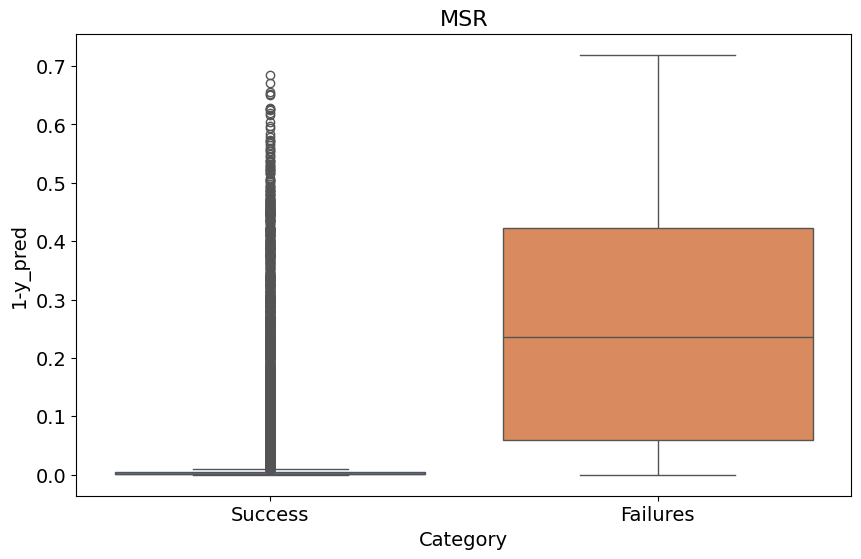

0.8919778350209595
Initial log-temperature: 0.4055
Initial temperature: 1.5000
Optimized log-temperature: 0.1905
Optimized temperature: 1.2098
Brier Score Loss (temperature): 0.0015


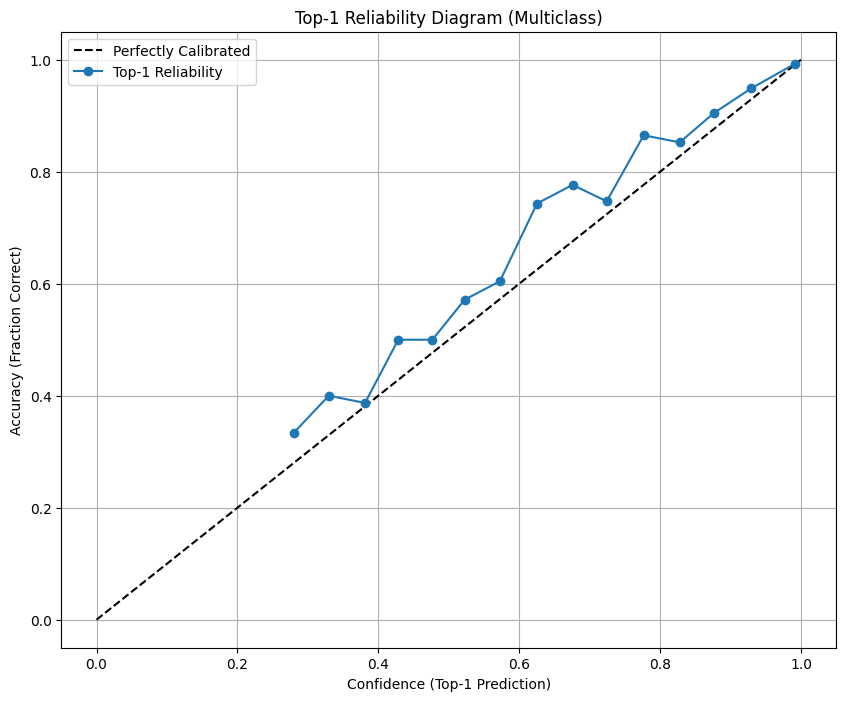

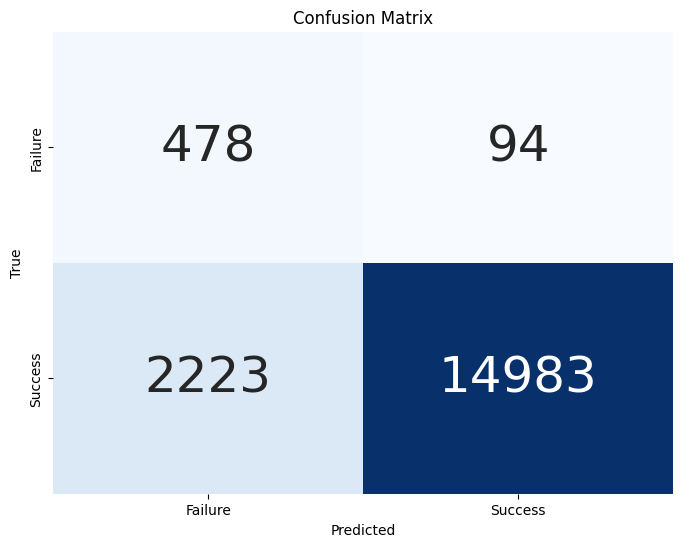

Optimal Threshold: 0.04305661842226982
Balanced Accuracy: 0.8532326095385493
Specificity: 0.8356643356643356
Sensitivity: 0.870800883412763


/mnt/data/psteinmetz/computer_vision_code/code/UQ_Toolbox/UQ_toolbox.py:581: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


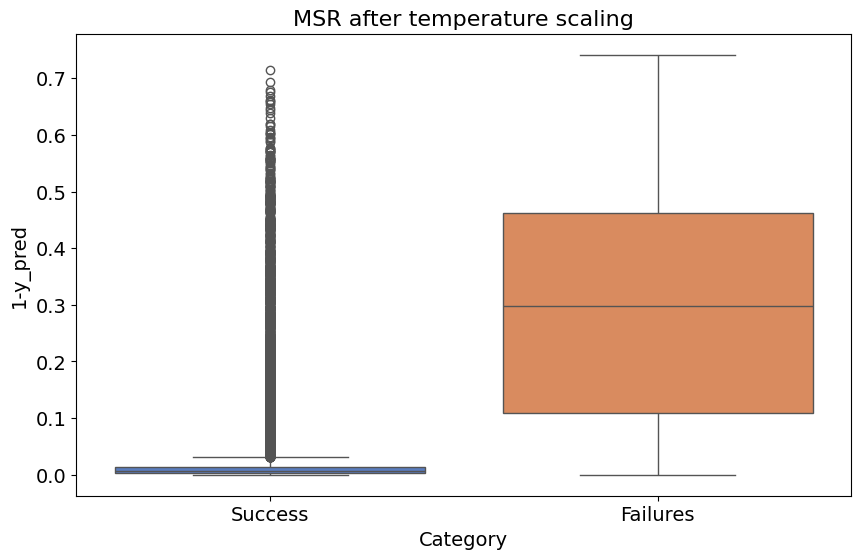

0.8865359112002724


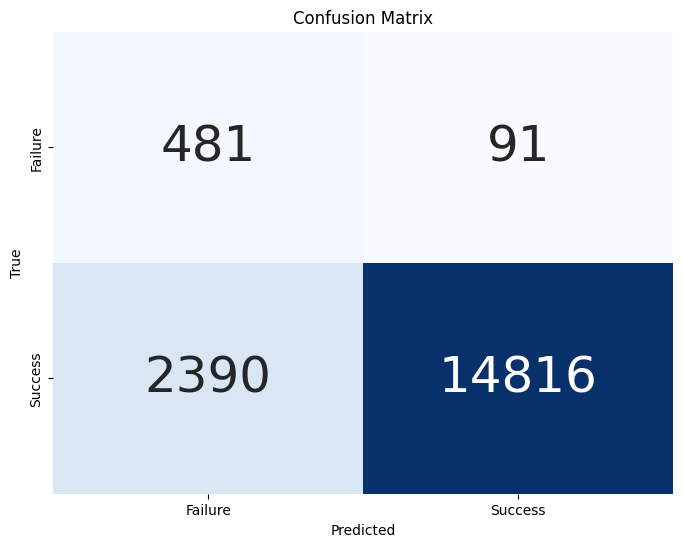

Optimal Threshold: 0.0035352781414985657
Balanced Accuracy: 0.8510020288905562
Specificity: 0.8409090909090909
Sensitivity: 0.8610949668720214


/mnt/data/psteinmetz/computer_vision_code/code/UQ_Toolbox/UQ_toolbox.py:581: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


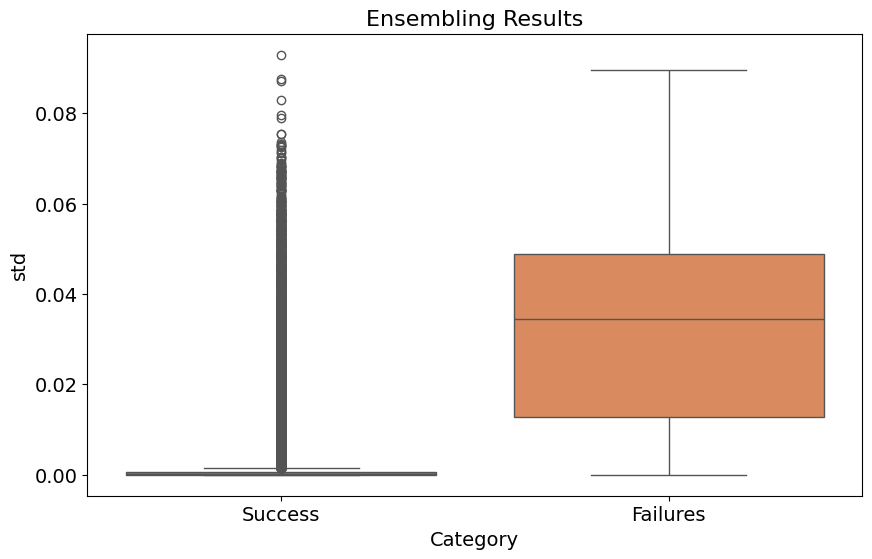

0.9039393275560893
Applying augmentation n : 0
Applying augmentation n : 0
Applying augmentation n : 0
Applying augmentation n : 0
Applying augmentation n : 0


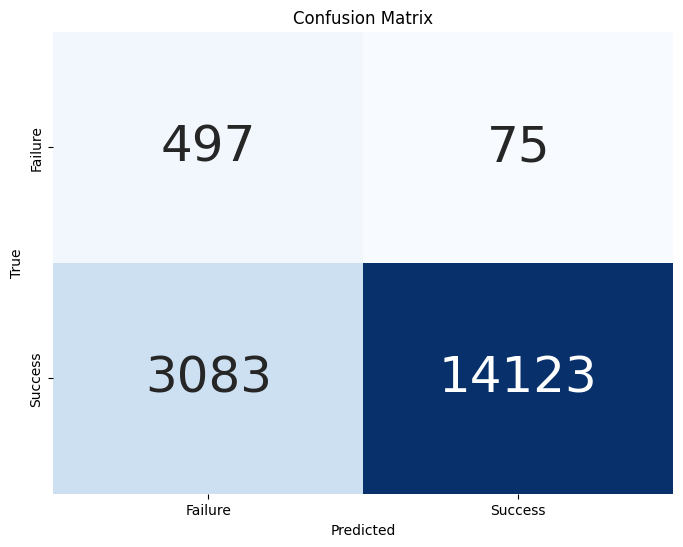

Optimal Threshold: 0.005440925437928902
Balanced Accuracy: 0.8448497190360493
Specificity: 0.8688811188811189
Sensitivity: 0.8208183191909799


/mnt/data/psteinmetz/computer_vision_code/code/UQ_Toolbox/UQ_toolbox.py:581: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


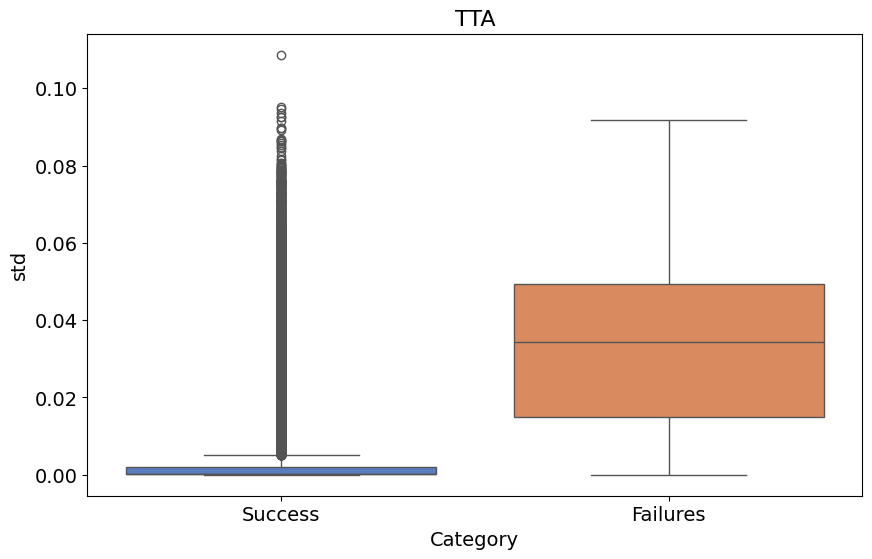

0.8965526946609127
Processing pneumoniamnist with color=False and activation=sigmoid
Training dataset size: 4185
Calibration dataset size: 1047
Training dataset size: 4185
Calibration dataset size: 1047
Ensemble AUC: 0.993, Ensemble Accuracy: 0.936


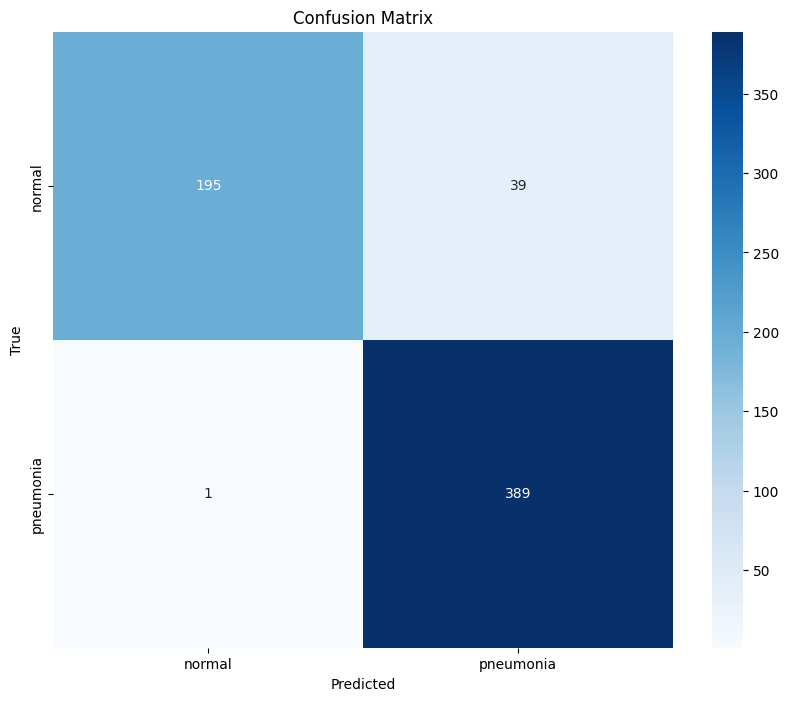

{'auc': np.float64(0.9931733508656585), 'accuracy': 0.9358974358974359, 'balanced_accuracy': np.float64(0.9153846153846155), 'sensitivity': 0.9974358974358974, 'specificity': np.float64(0.9153846153846155), 'confusion_matrix': array([[195,  39],
       [  1, 389]])}
Ensemble AUC: 0.999, Ensemble Accuracy: 0.984


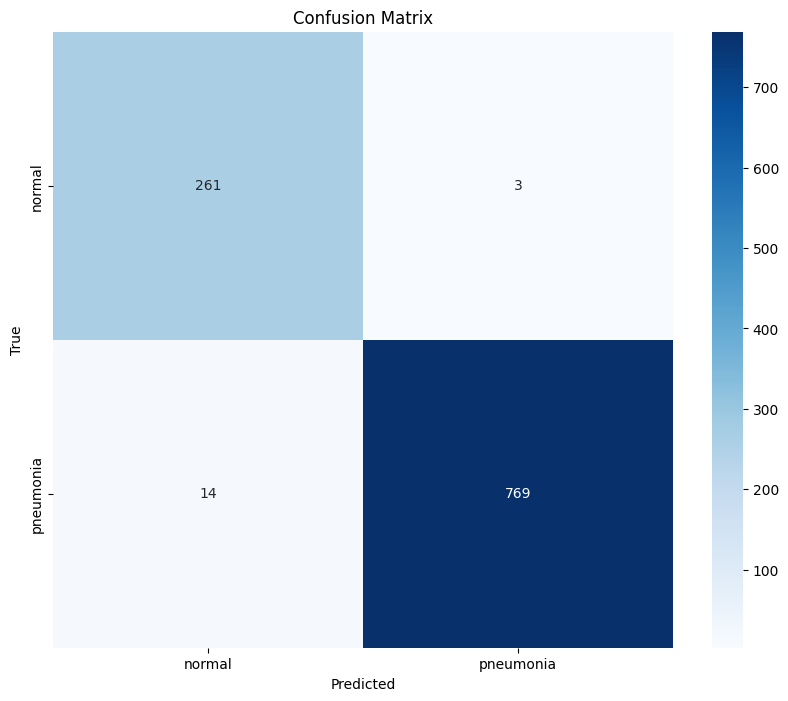

{'auc': np.float64(0.9989212043809745), 'accuracy': 0.9837631327602674, 'balanced_accuracy': np.float64(0.985378207360966), 'sensitivity': 0.9821200510855683, 'specificity': np.float64(0.985378207360966), 'confusion_matrix': array([[261,   3],
       [ 14, 769]])}


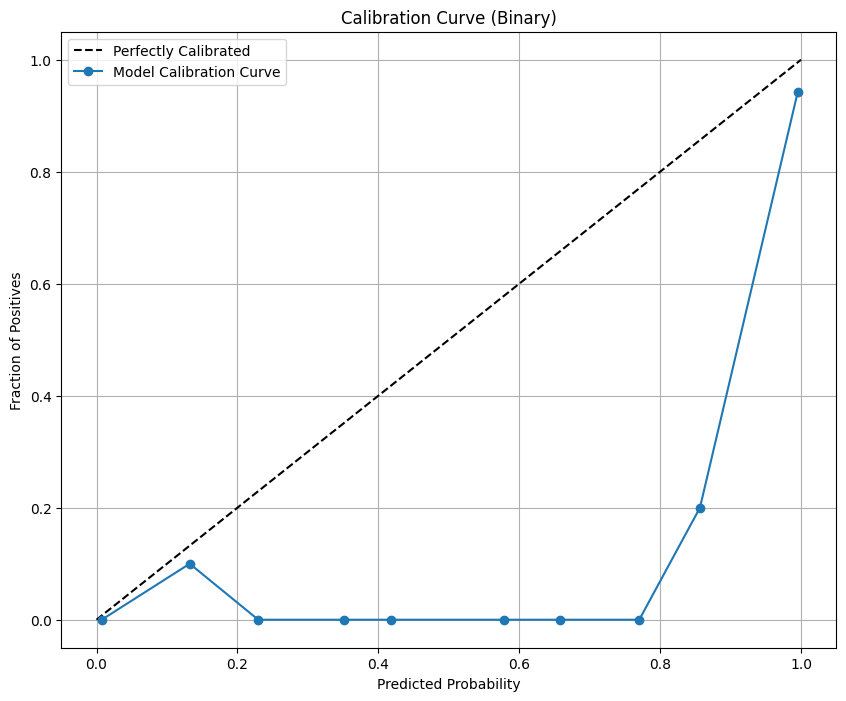

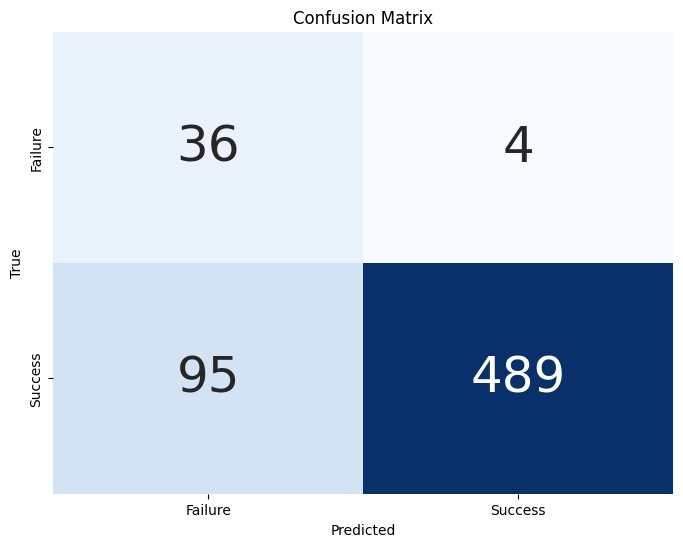

Optimal Threshold: 0.004906804766505957
Balanced Accuracy: 0.8686643835616439
Specificity: 0.9
Sensitivity: 0.8373287671232876


/mnt/data/psteinmetz/computer_vision_code/code/UQ_Toolbox/UQ_toolbox.py:581: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


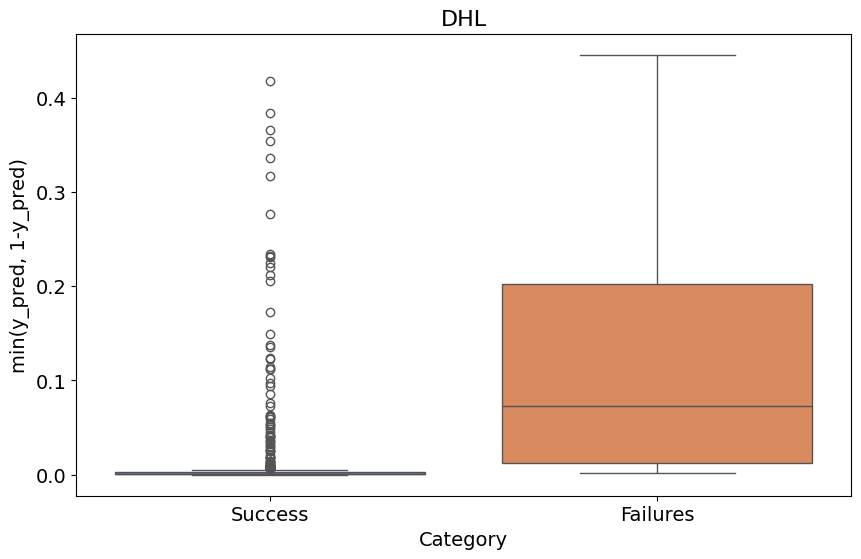

0.9224315068493151
Brier Score Loss (platt): 0.0117


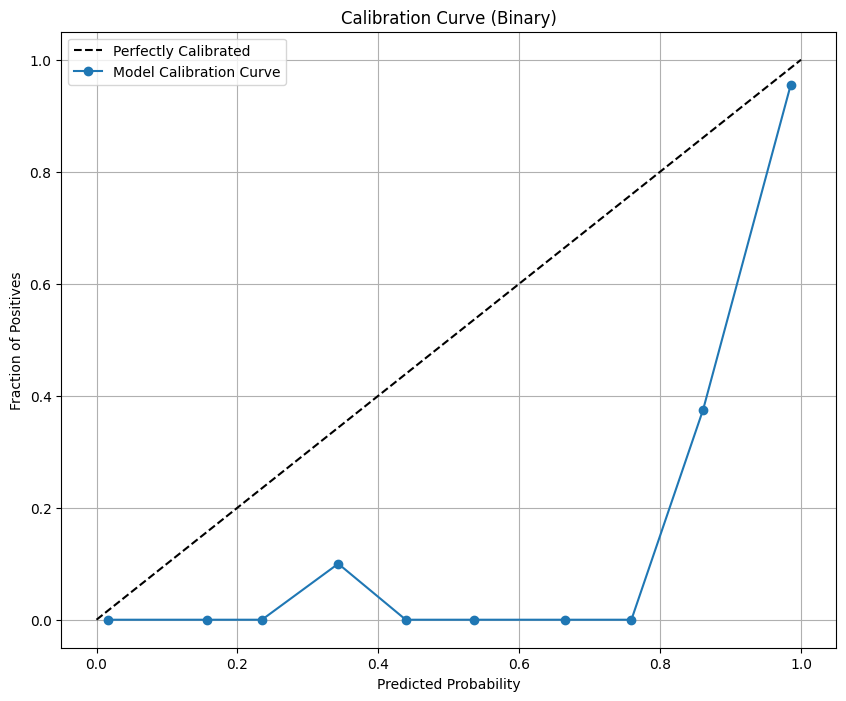

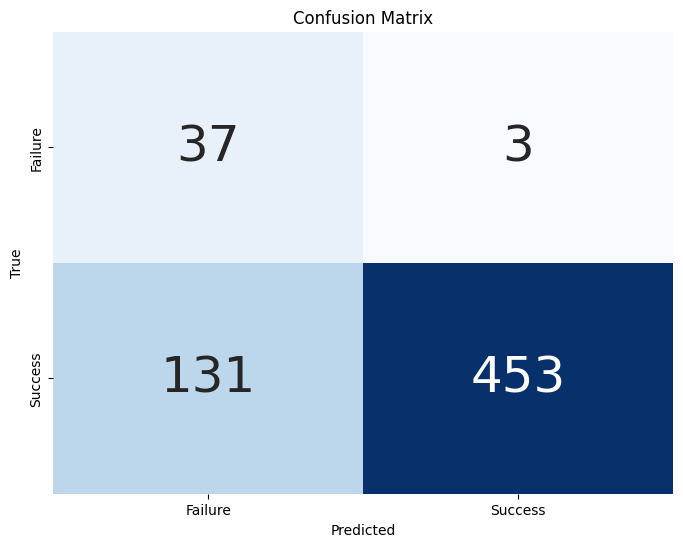

Optimal Threshold: 0.022277684725265912
Balanced Accuracy: 0.8503424657534246
Specificity: 0.925
Sensitivity: 0.7756849315068494


/mnt/data/psteinmetz/computer_vision_code/code/UQ_Toolbox/UQ_toolbox.py:581: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


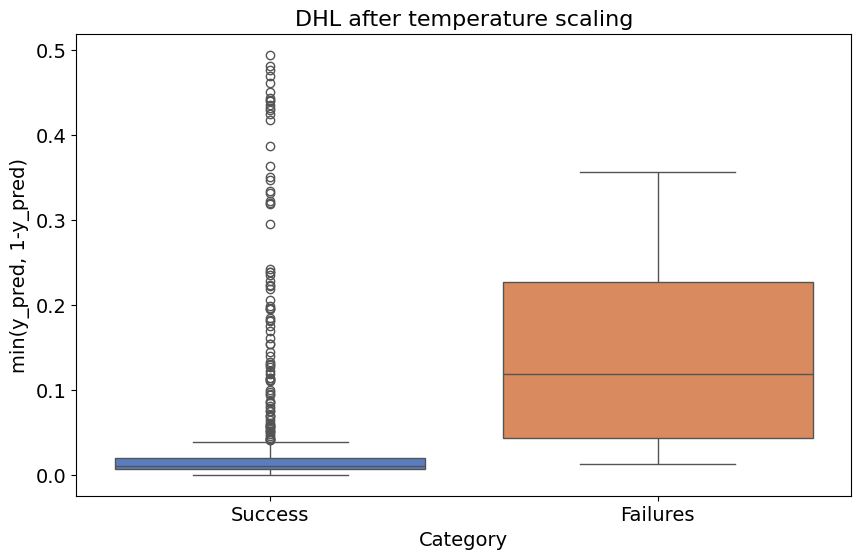

0.8875428082191781


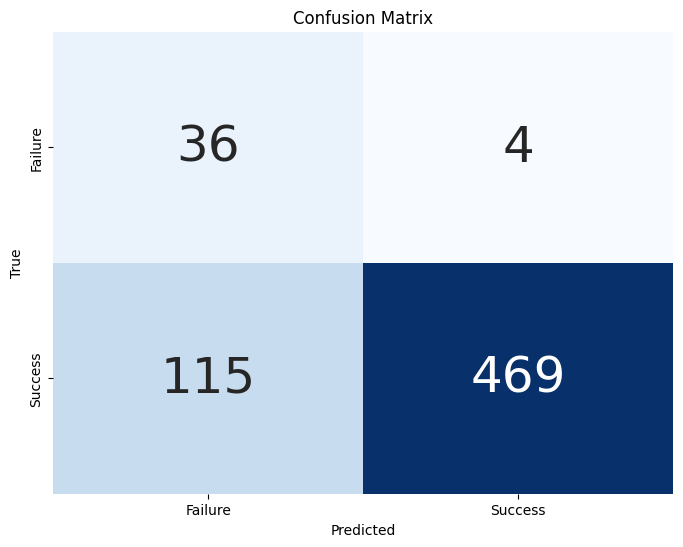

Optimal Threshold: 0.0063680317252874374
Balanced Accuracy: 0.851541095890411
Specificity: 0.9
Sensitivity: 0.803082191780822


/mnt/data/psteinmetz/computer_vision_code/code/UQ_Toolbox/UQ_toolbox.py:581: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


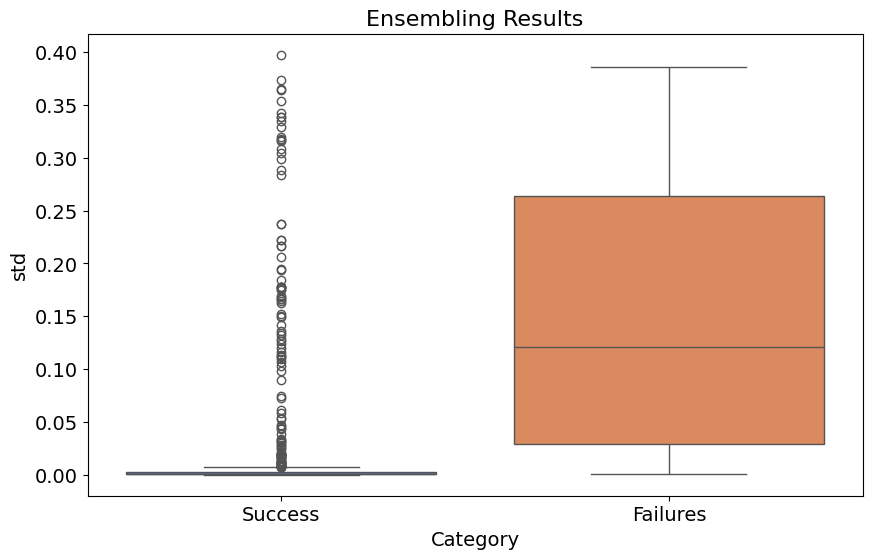

0.8981164383561644
Applying augmentation n : 0
Applying augmentation n : 0
Applying augmentation n : 0
Applying augmentation n : 0
Applying augmentation n : 0


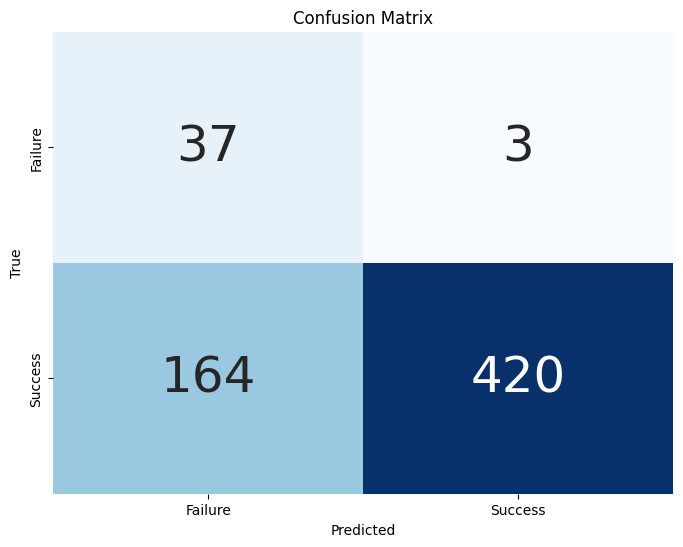

Optimal Threshold: 0.0040406150340110015
Balanced Accuracy: 0.8220890410958904
Specificity: 0.925
Sensitivity: 0.7191780821917808


/mnt/data/psteinmetz/computer_vision_code/code/UQ_Toolbox/UQ_toolbox.py:581: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


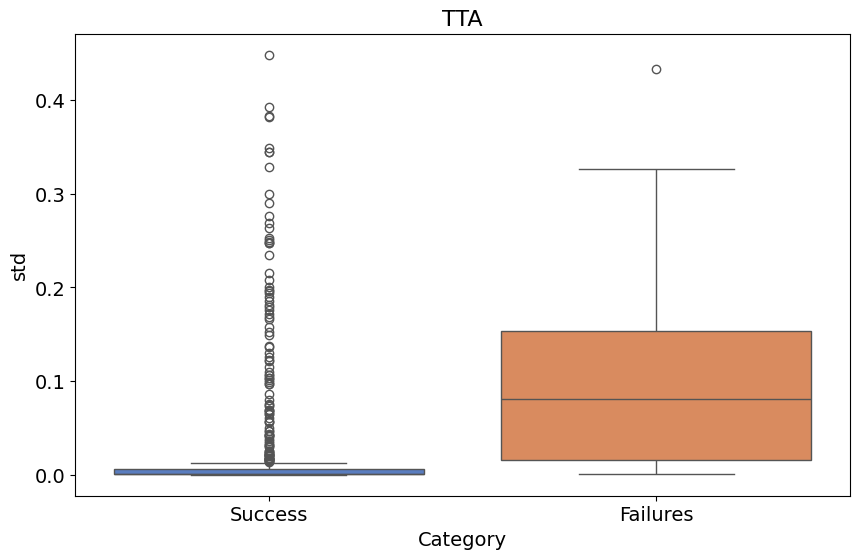

0.8642123287671233
Processing dermamnist with color=True and activation=softmax
Training dataset size: 6408
Calibration dataset size: 1602
Training dataset size: 6408
Calibration dataset size: 1602


/tmp/ipykernel_2674608/3830283869.py:105: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


Ensemble AUC: 0.981, Ensemble Accuracy: 0.870


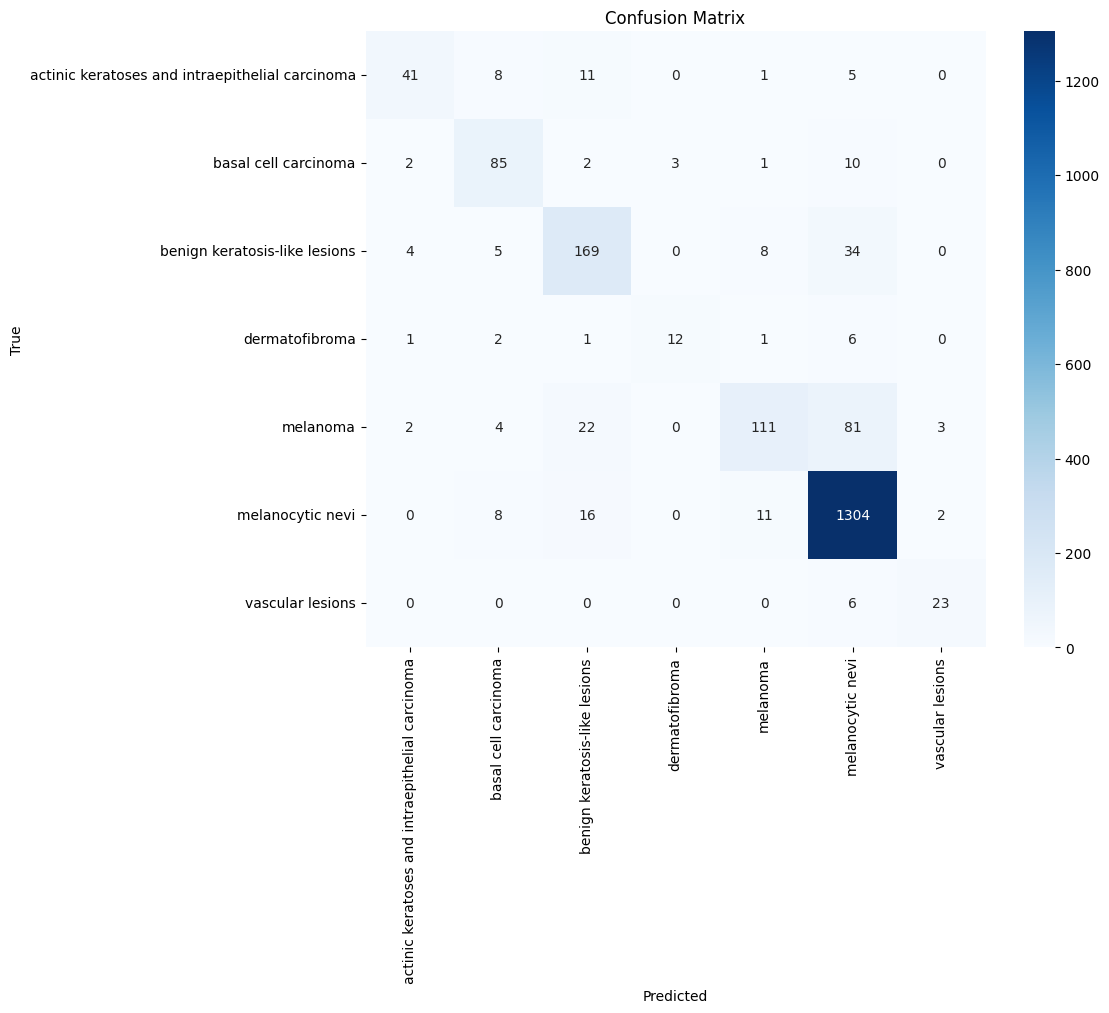

{'auc': np.float64(0.9807794359007077), 'accuracy': 0.8703241895261845, 'balanced_accuracy': np.float64(0.7142351049065453), 'sensitivity': 0.7142351049065453, 'specificity': np.float64(0.9602551583213234), 'confusion_matrix': array([[  41,    8,   11,    0,    1,    5,    0],
       [   2,   85,    2,    3,    1,   10,    0],
       [   4,    5,  169,    0,    8,   34,    0],
       [   1,    2,    1,   12,    1,    6,    0],
       [   2,    4,   22,    0,  111,   81,    3],
       [   0,    8,   16,    0,   11, 1304,    2],
       [   0,    0,    0,    0,    0,    6,   23]])}


/tmp/ipykernel_2674608/3830283869.py:105: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


Ensemble AUC: 0.974, Ensemble Accuracy: 0.866


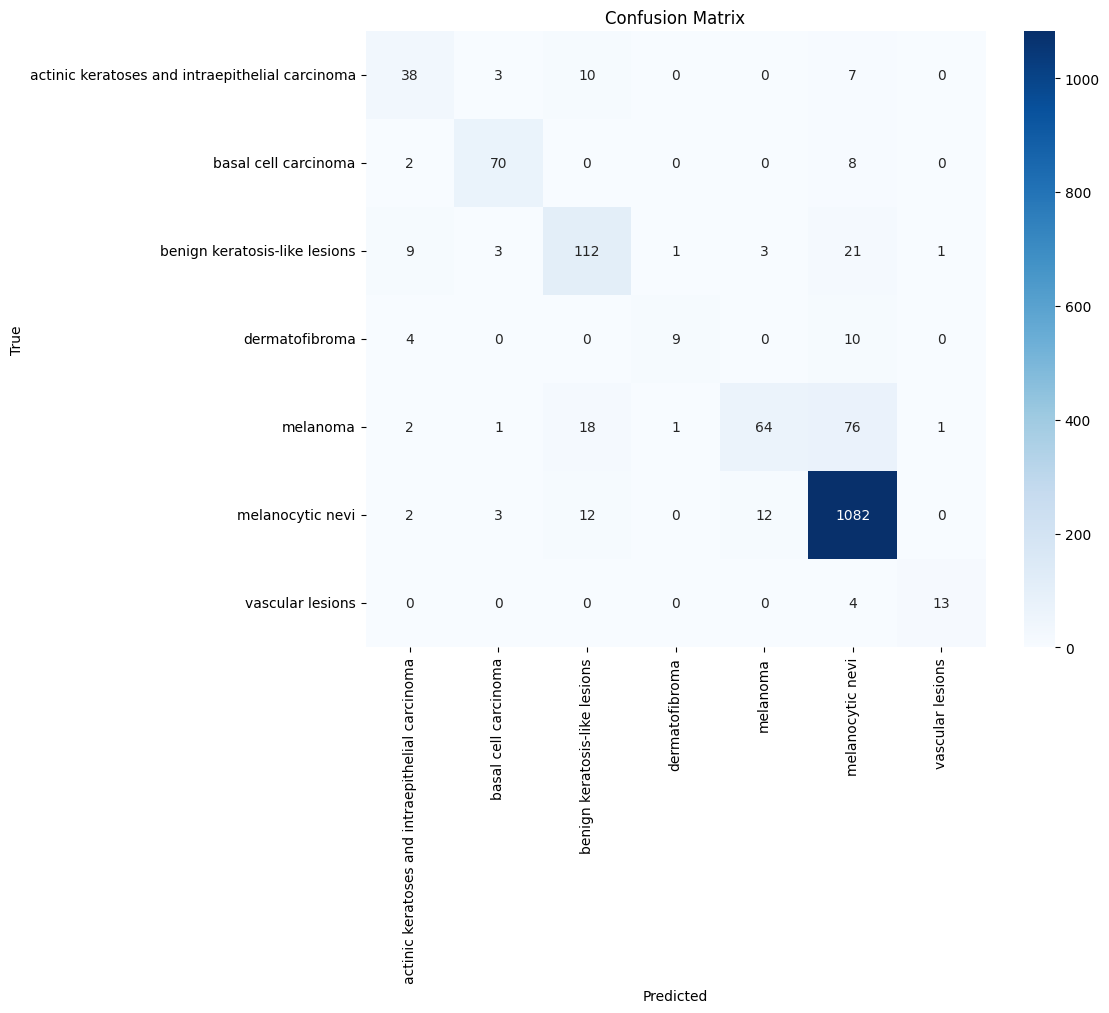

{'auc': np.float64(0.9743305706038361), 'accuracy': 0.8664169787765293, 'balanced_accuracy': np.float64(0.6856263910267983), 'sensitivity': 0.6856263910267983, 'specificity': np.float64(0.9548577549608882), 'confusion_matrix': array([[  38,    3,   10,    0,    0,    7,    0],
       [   2,   70,    0,    0,    0,    8,    0],
       [   9,    3,  112,    1,    3,   21,    1],
       [   4,    0,    0,    9,    0,   10,    0],
       [   2,    1,   18,    1,   64,   76,    1],
       [   2,    3,   12,    0,   12, 1082,    0],
       [   0,    0,    0,    0,    0,    4,   13]])}


/tmp/ipykernel_2674608/3830283869.py:105: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


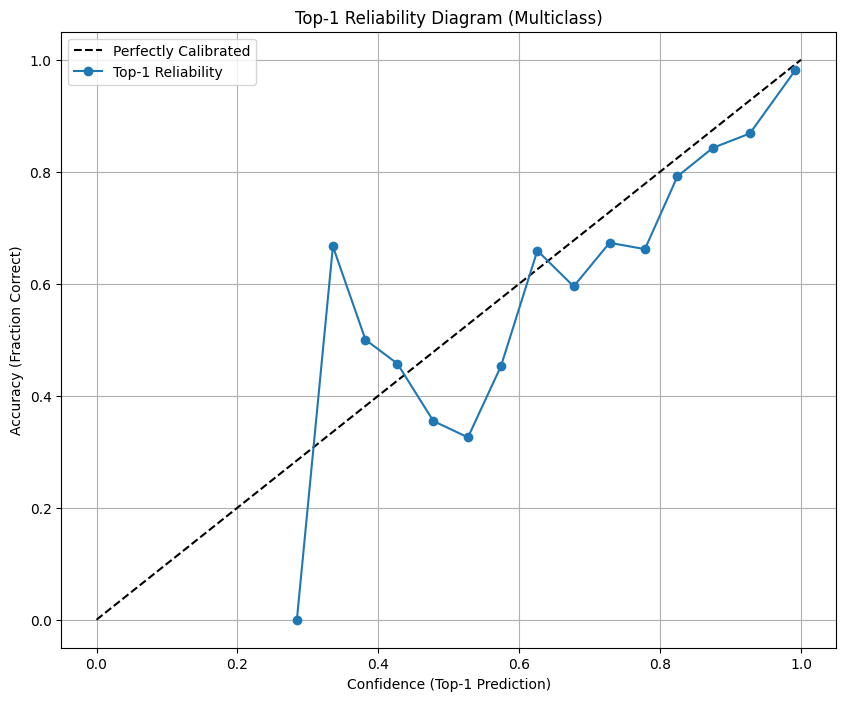

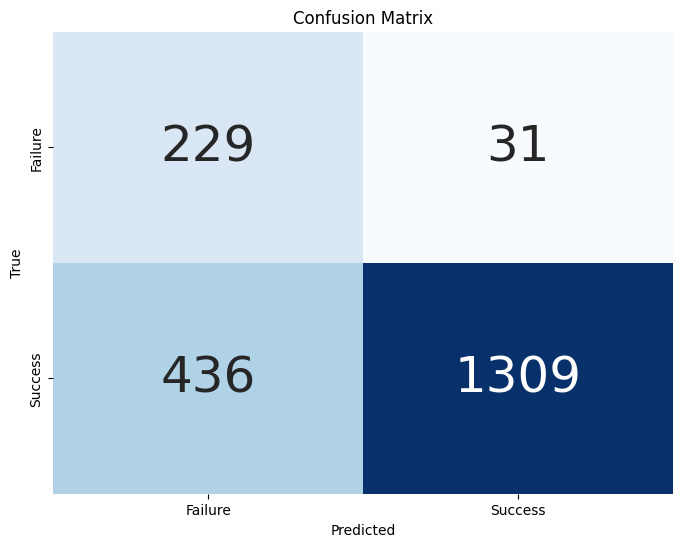

Optimal Threshold: 0.0694868266582489
Balanced Accuracy: 0.8154562486224377
Specificity: 0.8807692307692307
Sensitivity: 0.7501432664756447


/mnt/data/psteinmetz/computer_vision_code/code/UQ_Toolbox/UQ_toolbox.py:581: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


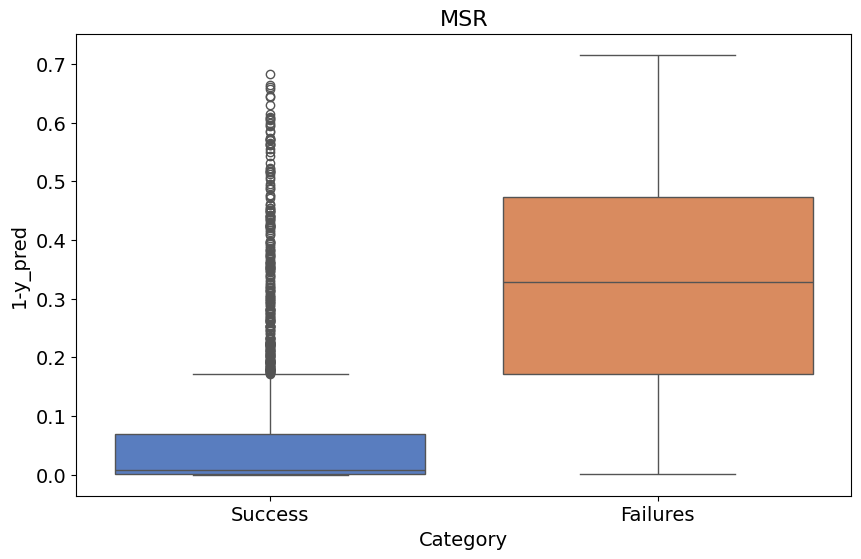

0.8893475865109103
Initial log-temperature: 0.4055
Initial temperature: 1.5000
Optimized log-temperature: 0.4403
Optimized temperature: 1.5532
Brier Score Loss (temperature): 0.0436


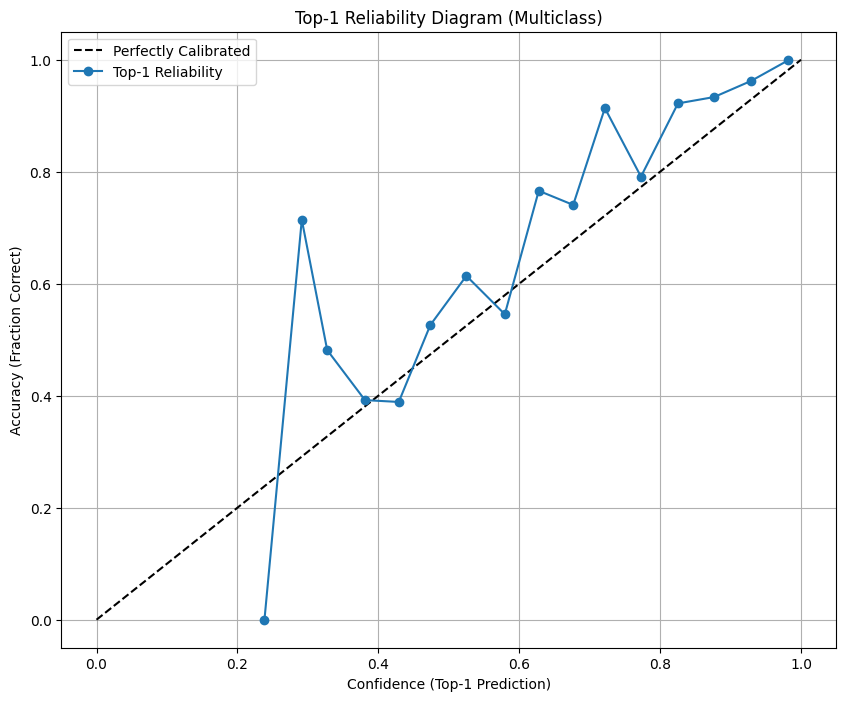

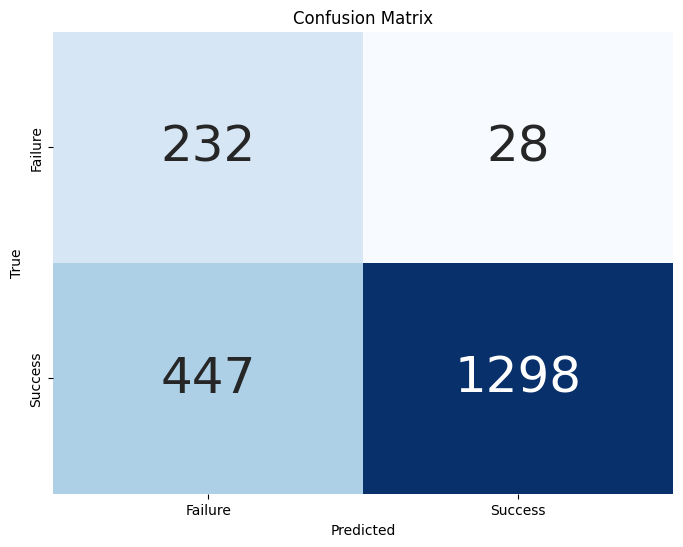

Optimal Threshold: 0.19550883769989014
Balanced Accuracy: 0.8180736169274851
Specificity: 0.8923076923076924
Sensitivity: 0.7438395415472779


/mnt/data/psteinmetz/computer_vision_code/code/UQ_Toolbox/UQ_toolbox.py:581: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


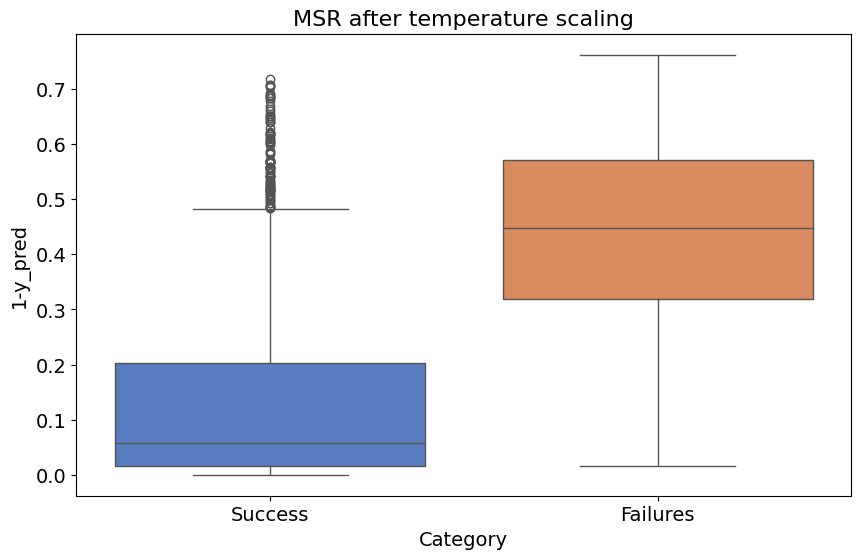

0.8865990742781573


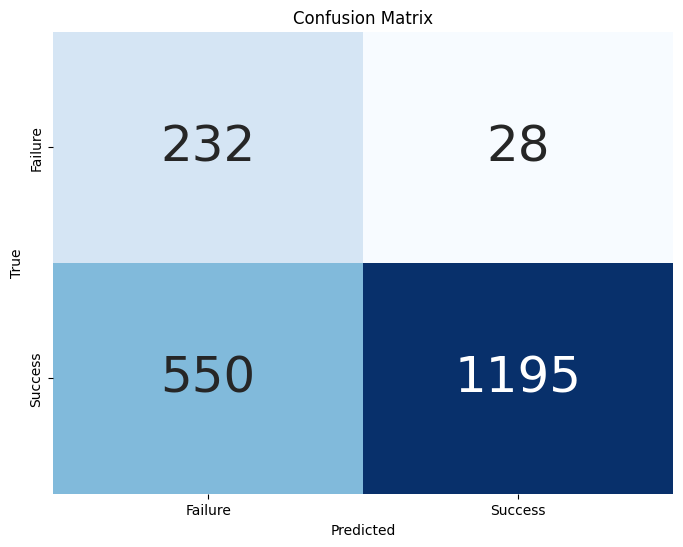

Optimal Threshold: 0.035227201879024506
Balanced Accuracy: 0.7885607229446772
Specificity: 0.8923076923076924
Sensitivity: 0.6848137535816619


/mnt/data/psteinmetz/computer_vision_code/code/UQ_Toolbox/UQ_toolbox.py:581: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


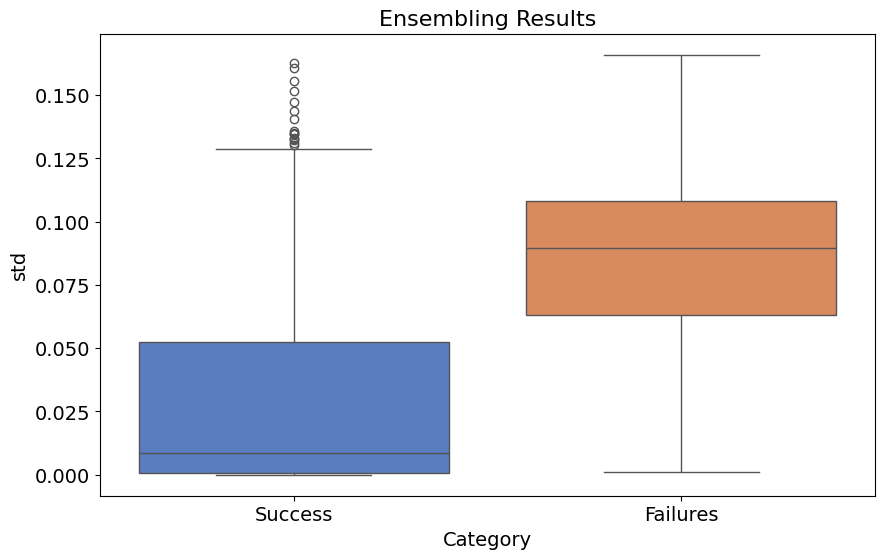

0.853462640511351
Applying augmentation n : 0
Applying augmentation n : 0
Applying augmentation n : 0
Applying augmentation n : 0
Applying augmentation n : 0


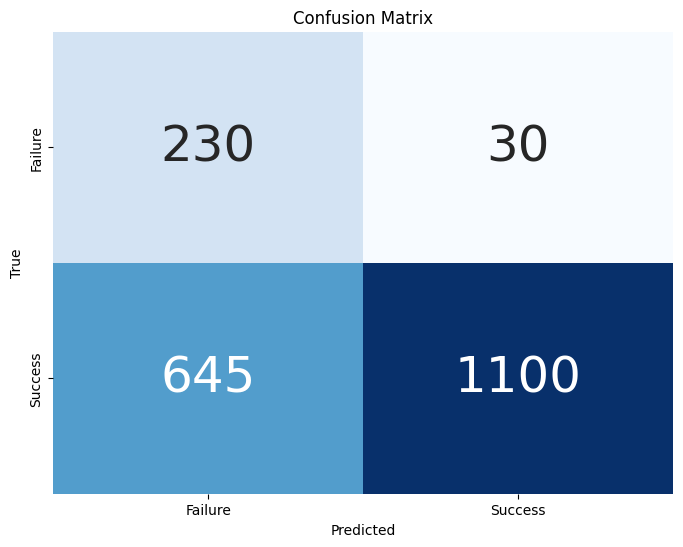

Optimal Threshold: 0.019825141646778264
Balanced Accuracy: 0.7574939387260304
Specificity: 0.8846153846153846
Sensitivity: 0.6303724928366762


/mnt/data/psteinmetz/computer_vision_code/code/UQ_Toolbox/UQ_toolbox.py:581: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


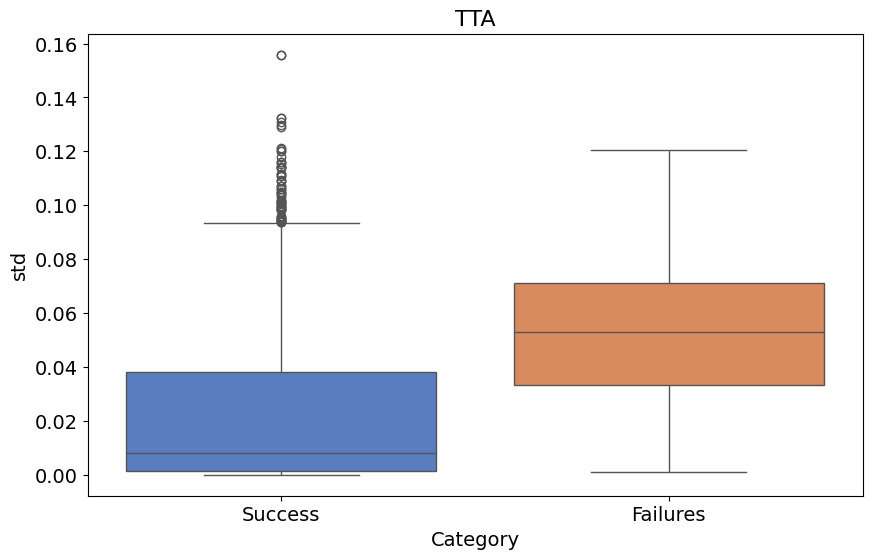

0.7961824994489752
Processing octmnist with color=False and activation=softmax
Training dataset size: 86647
Calibration dataset size: 21662
Training dataset size: 86647
Calibration dataset size: 21662
Ensemble AUC: 0.994, Ensemble Accuracy: 0.821


/tmp/ipykernel_2674608/3830283869.py:105: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


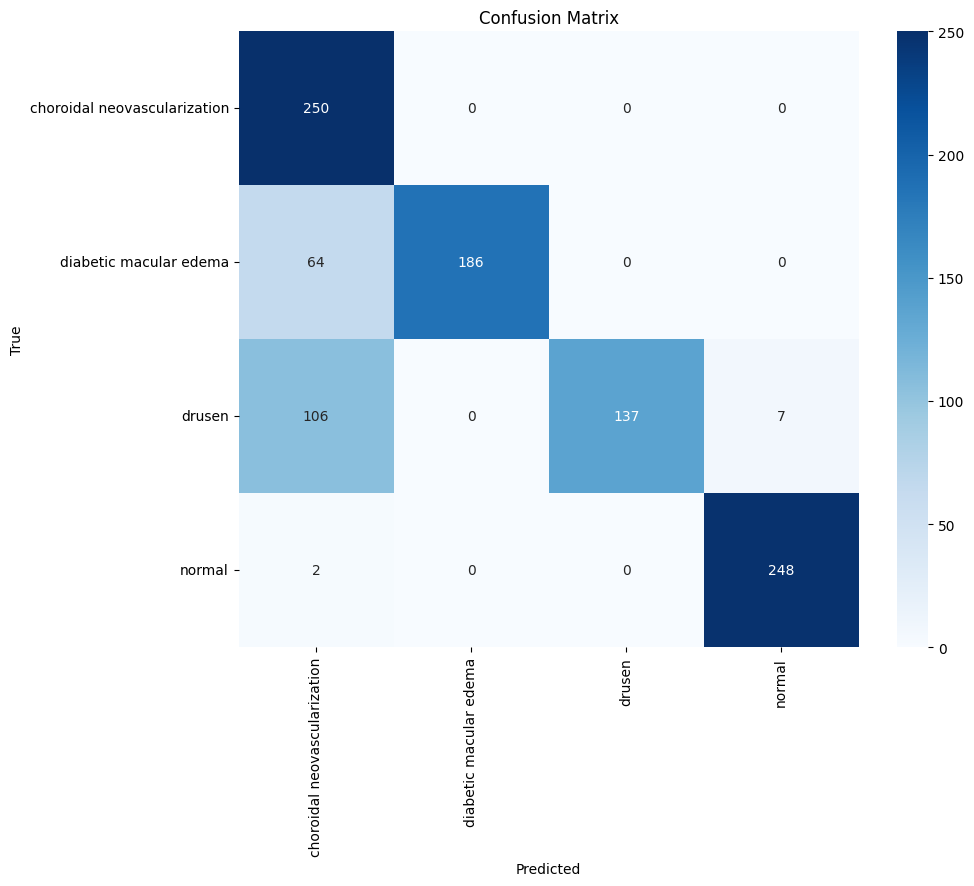

{'auc': np.float64(0.99377), 'accuracy': 0.821, 'balanced_accuracy': np.float64(0.821), 'sensitivity': 0.821, 'specificity': np.float64(0.9403333333333334), 'confusion_matrix': array([[250,   0,   0,   0],
       [ 64, 186,   0,   0],
       [106,   0, 137,   7],
       [  2,   0,   0, 248]])}
Ensemble AUC: 0.998, Ensemble Accuracy: 0.980


/tmp/ipykernel_2674608/3830283869.py:105: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


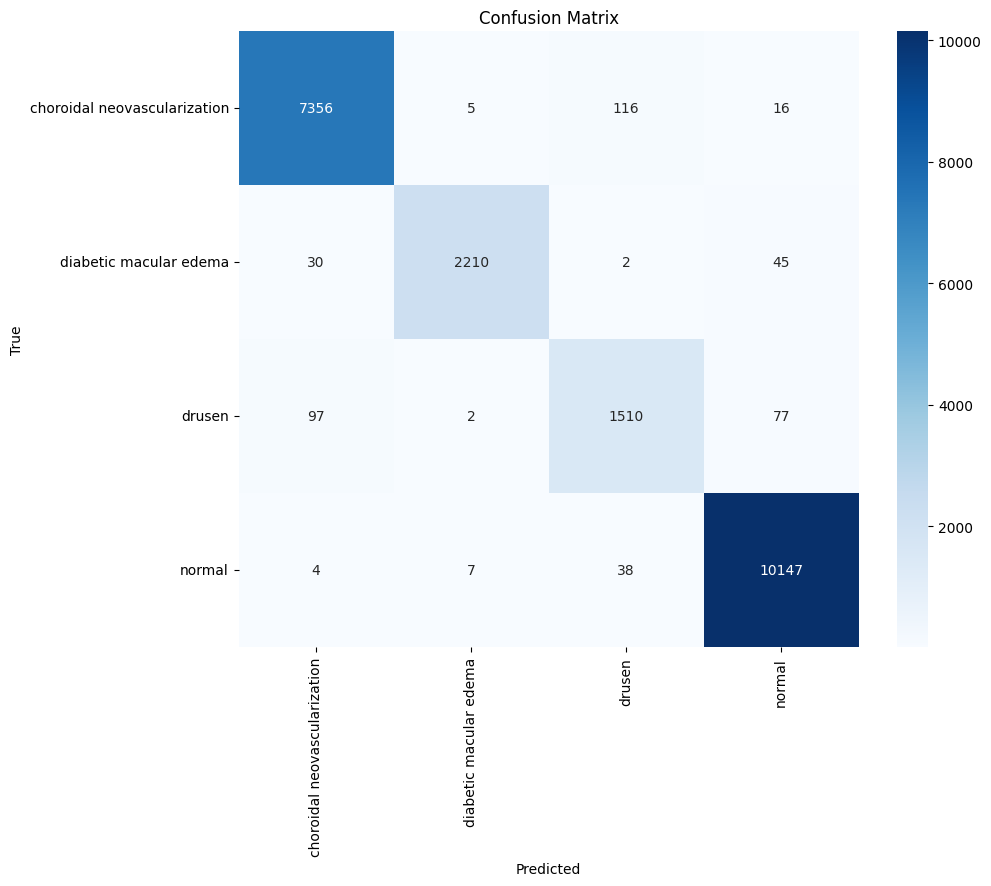

/tmp/ipykernel_2674608/3830283869.py:105: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


{'auc': np.float64(0.9981667833704511), 'accuracy': 0.9797340965746468, 'balanced_accuracy': np.float64(0.959713203572272), 'sensitivity': 0.959713203572272, 'specificity': np.float64(0.9925467321539574), 'confusion_matrix': array([[ 7356,     5,   116,    16],
       [   30,  2210,     2,    45],
       [   97,     2,  1510,    77],
       [    4,     7,    38, 10147]])}


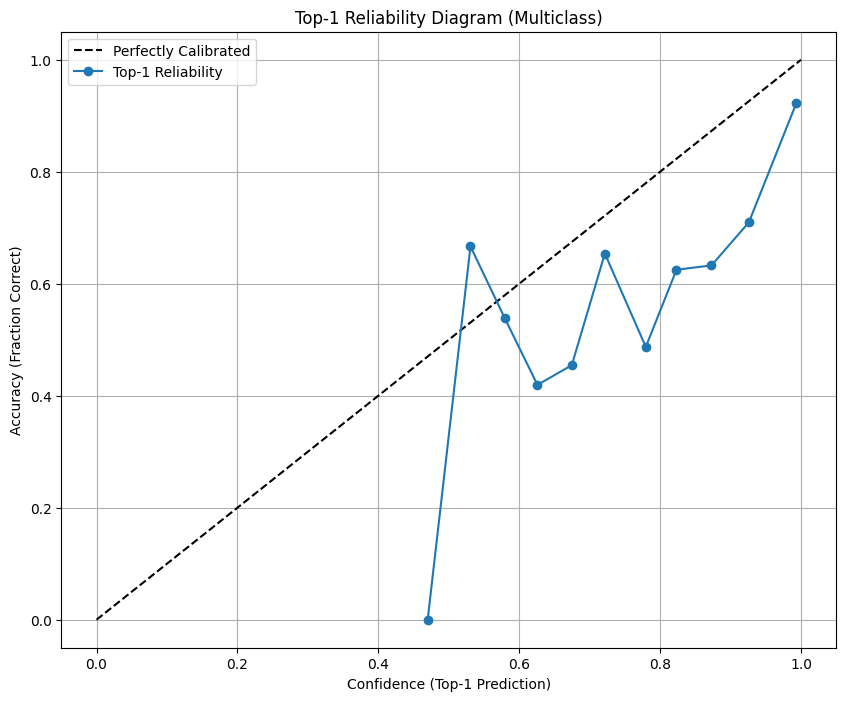

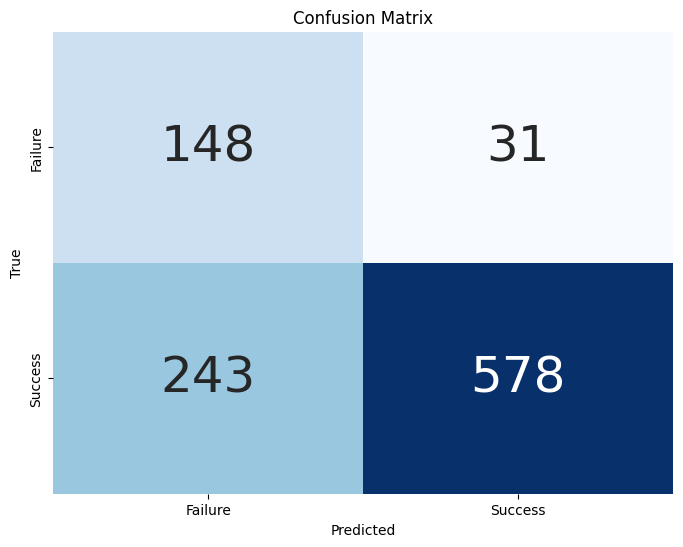

Optimal Threshold: 0.01910196989774704
Balanced Accuracy: 0.765417565443423
Specificity: 0.8268156424581006
Sensitivity: 0.7040194884287454


/mnt/data/psteinmetz/computer_vision_code/code/UQ_Toolbox/UQ_toolbox.py:581: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


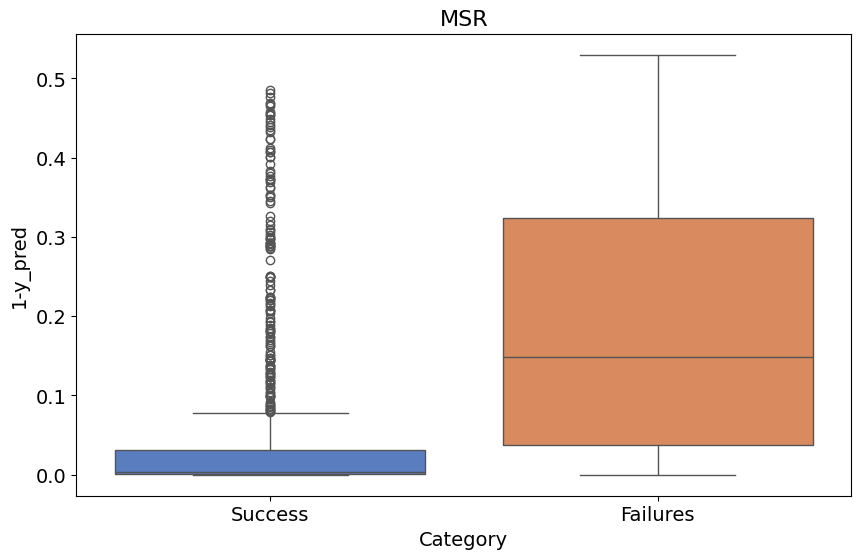

0.8187623759007615
Initial log-temperature: 0.4055
Initial temperature: 1.5000
Optimized log-temperature: 0.3029
Optimized temperature: 1.3538
Brier Score Loss (temperature): 0.0054


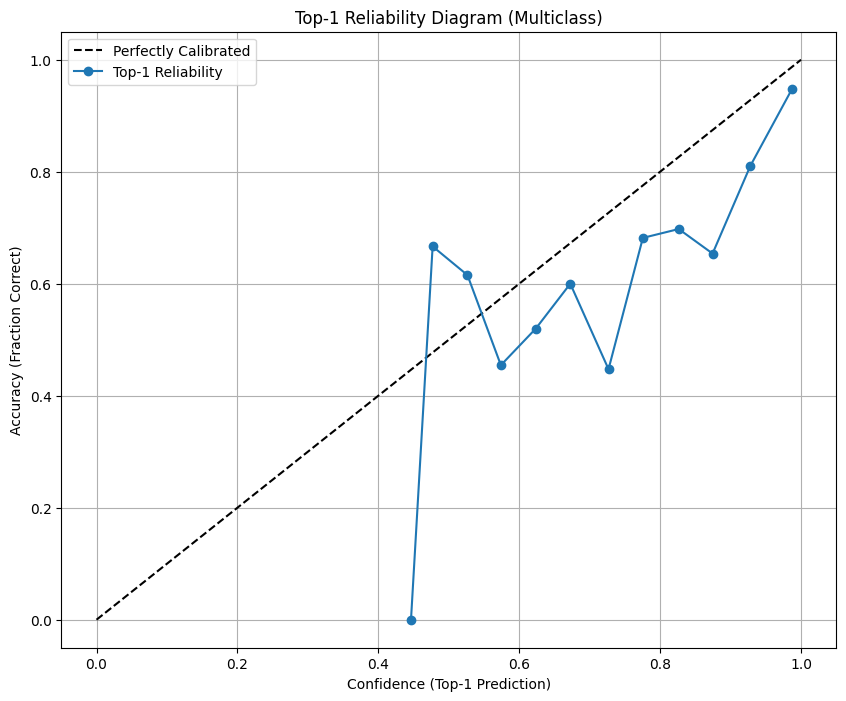

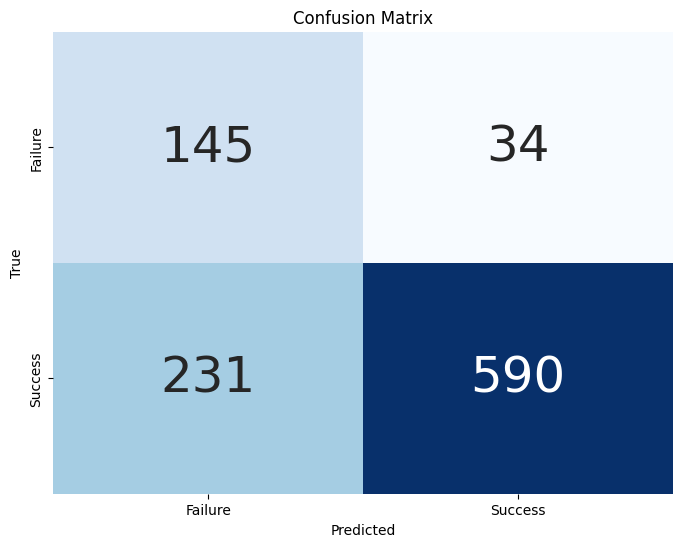

Optimal Threshold: 0.06441834568977356
Balanced Accuracy: 0.7643458379548037
Specificity: 0.8100558659217877
Sensitivity: 0.7186358099878197


/mnt/data/psteinmetz/computer_vision_code/code/UQ_Toolbox/UQ_toolbox.py:581: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


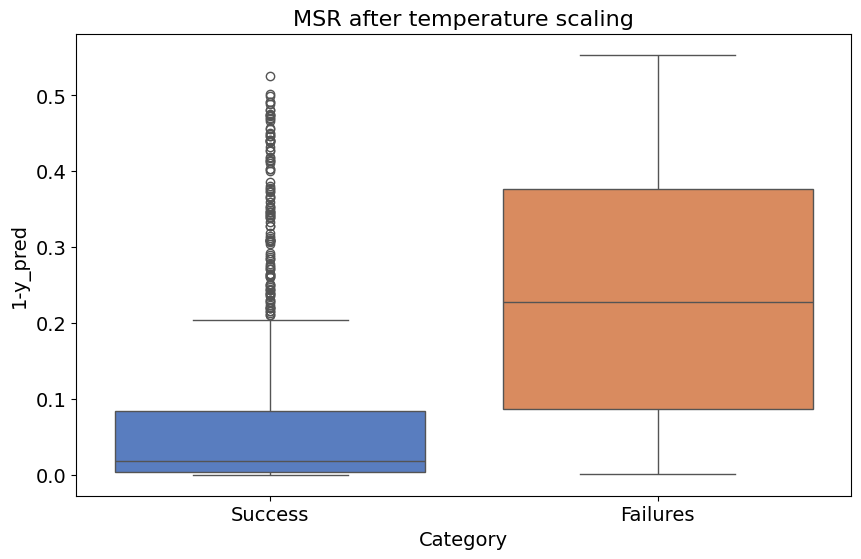

0.8155403888159282


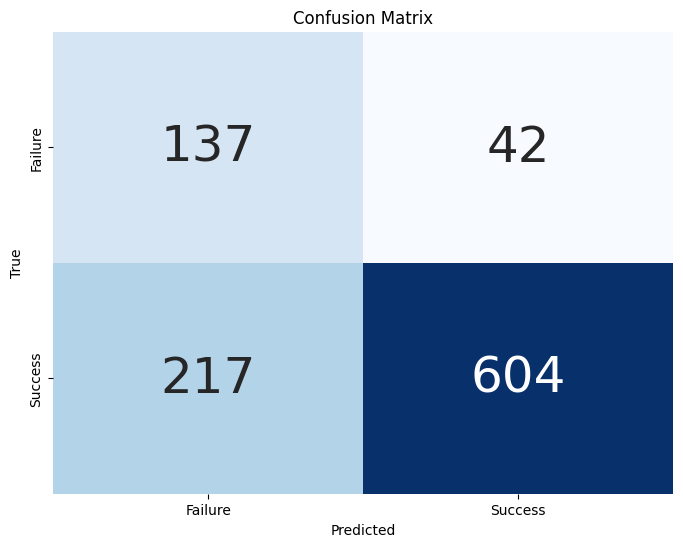

Optimal Threshold: 0.022844085469841957
Balanced Accuracy: 0.7505256568158466
Specificity: 0.7653631284916201
Sensitivity: 0.7356881851400731


/mnt/data/psteinmetz/computer_vision_code/code/UQ_Toolbox/UQ_toolbox.py:581: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


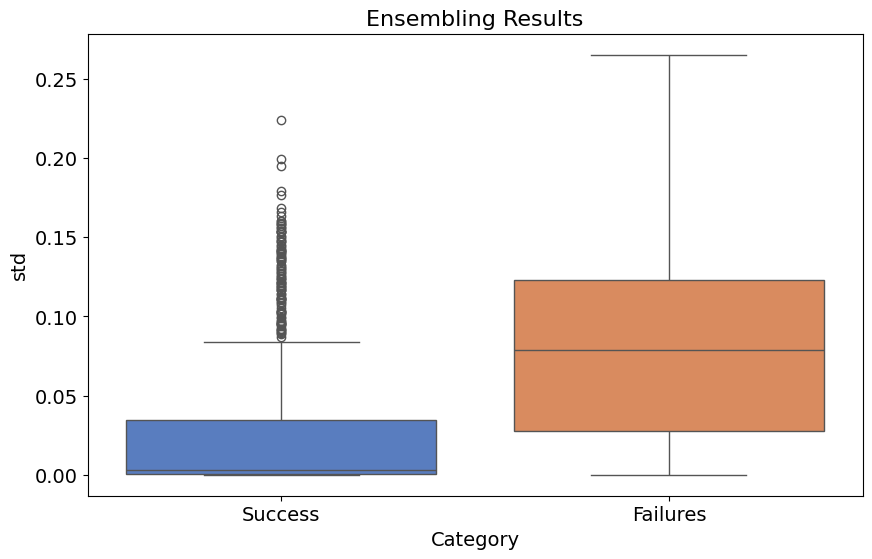

0.8057961744432119
Applying augmentation n : 0
Applying augmentation n : 0
Applying augmentation n : 0
Applying augmentation n : 0
Applying augmentation n : 0


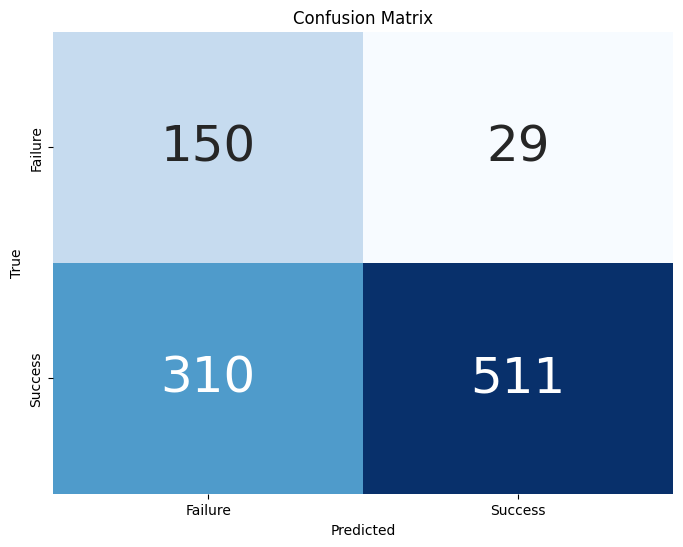

Optimal Threshold: 0.008079574464036059
Balanced Accuracy: 0.7302002599364449
Specificity: 0.8379888268156425
Sensitivity: 0.6224116930572473


/mnt/data/psteinmetz/computer_vision_code/code/UQ_Toolbox/UQ_toolbox.py:581: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


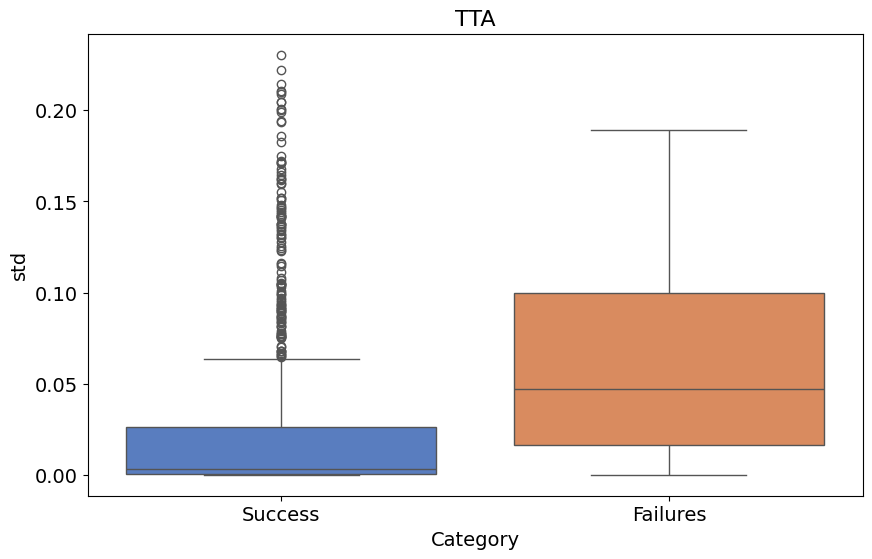

0.7723174490844386
Processing pathmnist with color=True and activation=softmax
Training dataset size: 80000
Calibration dataset size: 20000
Training dataset size: 80000
Calibration dataset size: 20000


/tmp/ipykernel_2674608/3830283869.py:105: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


Ensemble AUC: 0.995, Ensemble Accuracy: 0.963


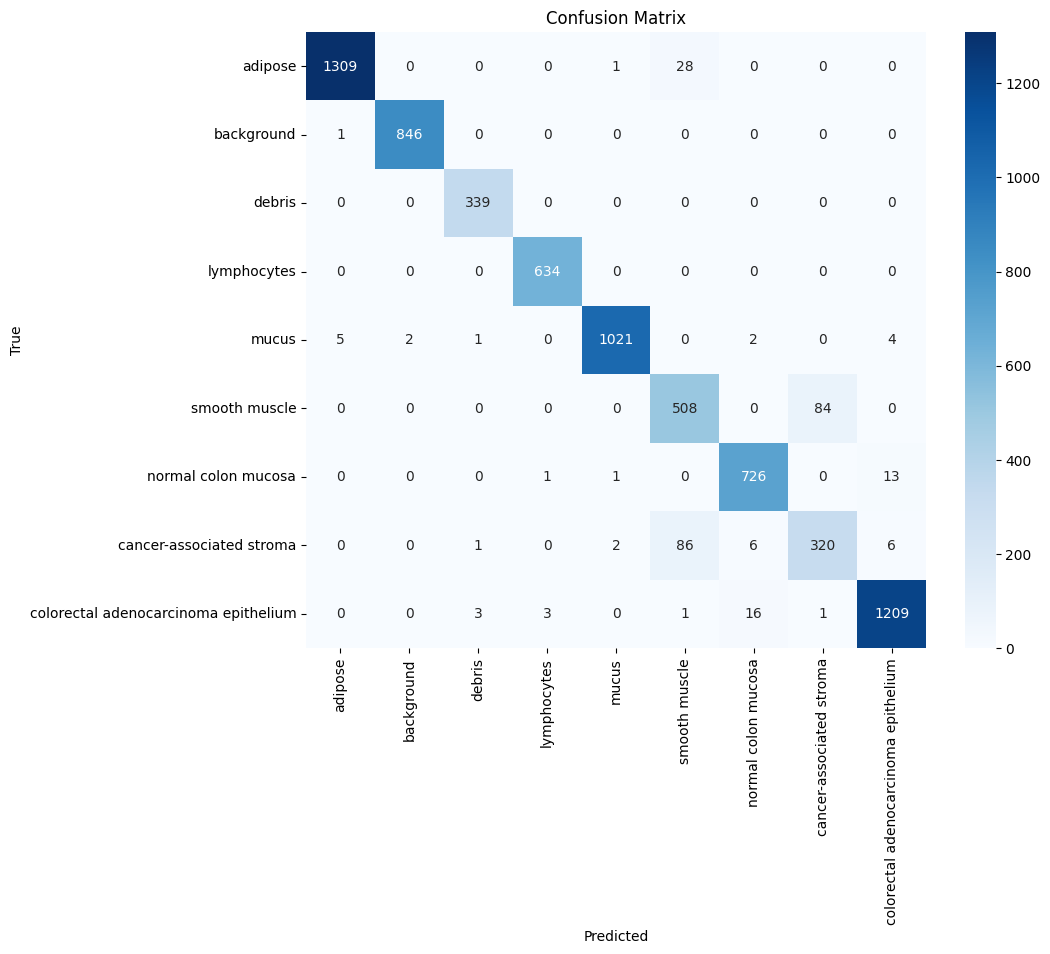

{'auc': np.float64(0.9945247707359987), 'accuracy': 0.9626740947075209, 'balanced_accuracy': np.float64(0.9491237929677092), 'sensitivity': 0.9491237929677092, 'specificity': np.float64(0.995448630745181), 'confusion_matrix': array([[1309,    0,    0,    0,    1,   28,    0,    0,    0],
       [   1,  846,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,  339,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,  634,    0,    0,    0,    0,    0],
       [   5,    2,    1,    0, 1021,    0,    2,    0,    4],
       [   0,    0,    0,    0,    0,  508,    0,   84,    0],
       [   0,    0,    0,    1,    1,    0,  726,    0,   13],
       [   0,    0,    1,    0,    2,   86,    6,  320,    6],
       [   0,    0,    3,    3,    0,    1,   16,    1, 1209]])}


/tmp/ipykernel_2674608/3830283869.py:105: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


Ensemble AUC: 1.000, Ensemble Accuracy: 0.993


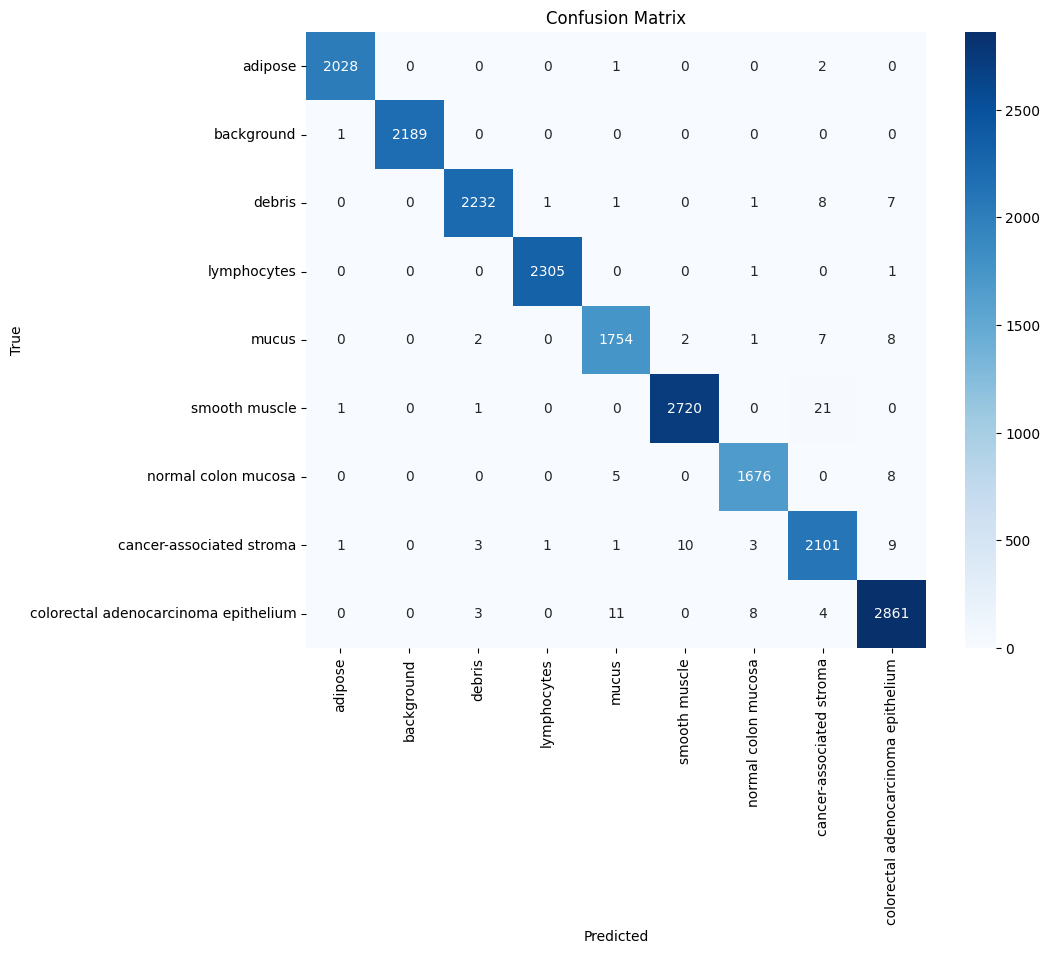

{'auc': np.float64(0.9999354411240766), 'accuracy': 0.9933, 'balanced_accuracy': np.float64(0.9932984383704859), 'sensitivity': 0.9932984383704859, 'specificity': np.float64(0.9991591139027707), 'confusion_matrix': array([[2028,    0,    0,    0,    1,    0,    0,    2,    0],
       [   1, 2189,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0, 2232,    1,    1,    0,    1,    8,    7],
       [   0,    0,    0, 2305,    0,    0,    1,    0,    1],
       [   0,    0,    2,    0, 1754,    2,    1,    7,    8],
       [   1,    0,    1,    0,    0, 2720,    0,   21,    0],
       [   0,    0,    0,    0,    5,    0, 1676,    0,    8],
       [   1,    0,    3,    1,    1,   10,    3, 2101,    9],
       [   0,    0,    3,    0,   11,    0,    8,    4, 2861]])}


/tmp/ipykernel_2674608/3830283869.py:105: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


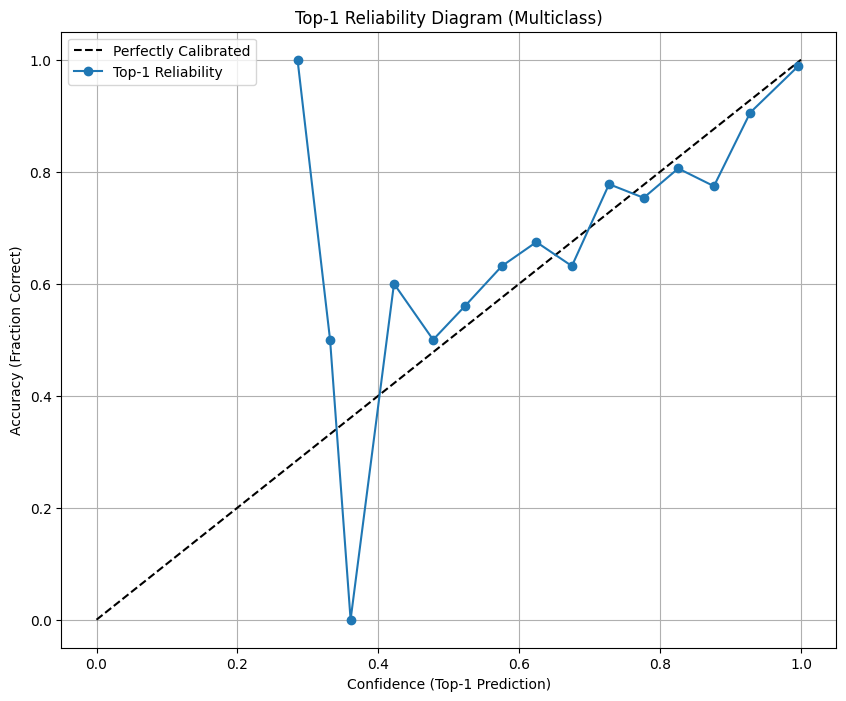

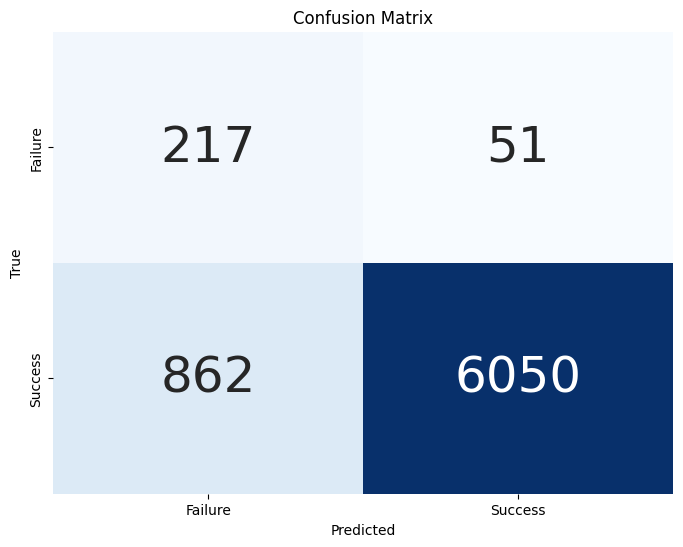

Optimal Threshold: 0.027900122106075287
Balanced Accuracy: 0.8424954221945826
Specificity: 0.8097014925373134
Sensitivity: 0.8752893518518519


/mnt/data/psteinmetz/computer_vision_code/code/UQ_Toolbox/UQ_toolbox.py:581: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


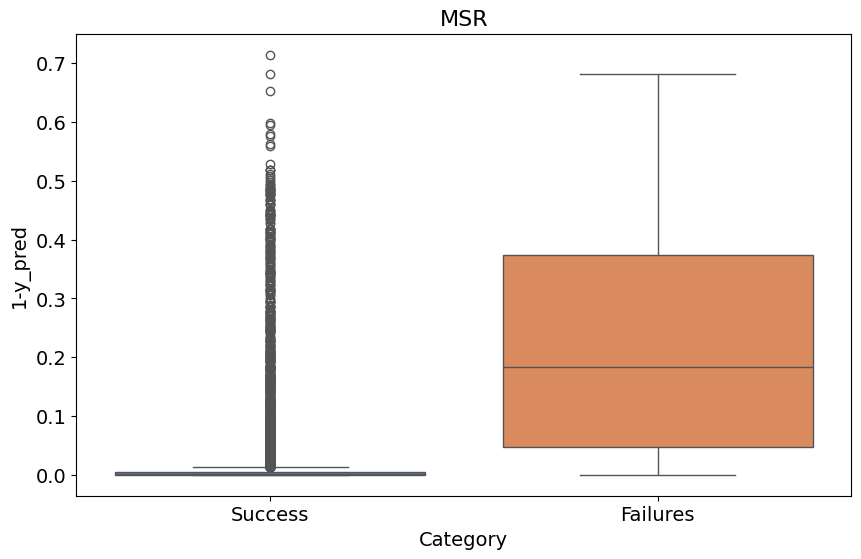

0.8688982388405195
Initial log-temperature: 0.4055
Initial temperature: 1.5000
Optimized log-temperature: 0.1997
Optimized temperature: 1.2210
Brier Score Loss (temperature): 0.0022


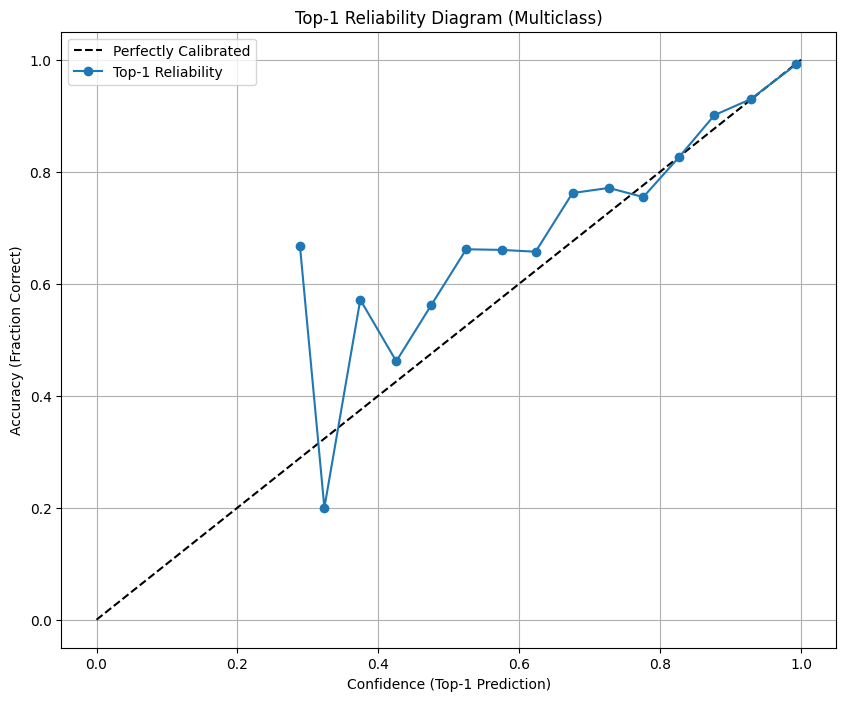

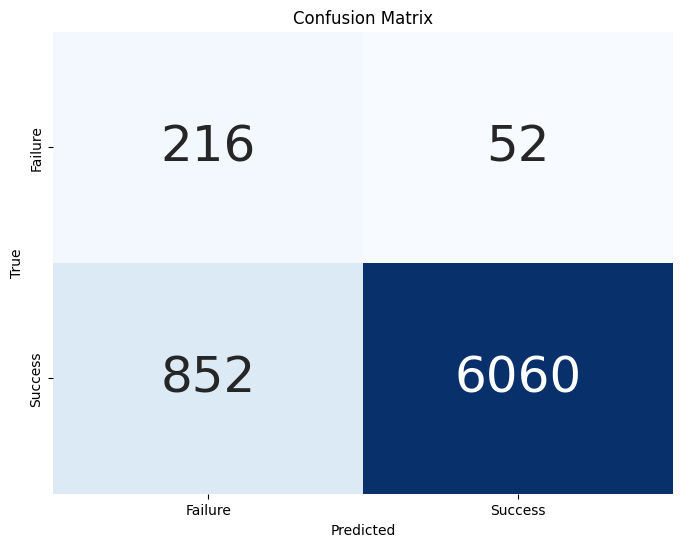

Optimal Threshold: 0.05927557125687599
Balanced Accuracy: 0.8413531301824213
Specificity: 0.8059701492537313
Sensitivity: 0.8767361111111112


/mnt/data/psteinmetz/computer_vision_code/code/UQ_Toolbox/UQ_toolbox.py:581: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


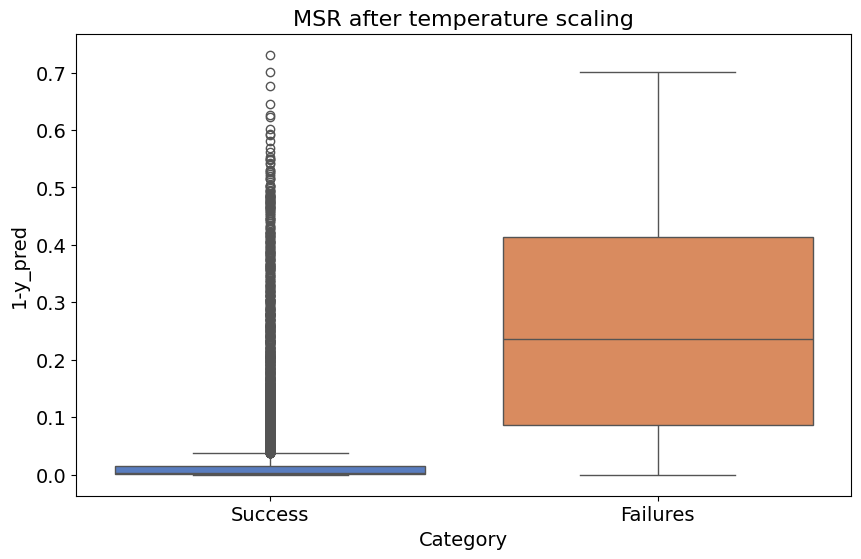

0.8671699553448037


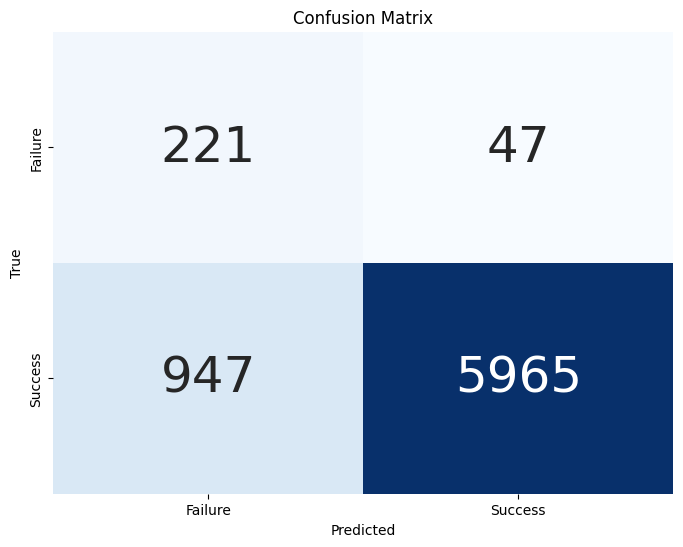

Optimal Threshold: 0.014096653088927269
Balanced Accuracy: 0.843809381909895
Specificity: 0.8246268656716418
Sensitivity: 0.8629918981481481


/mnt/data/psteinmetz/computer_vision_code/code/UQ_Toolbox/UQ_toolbox.py:581: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


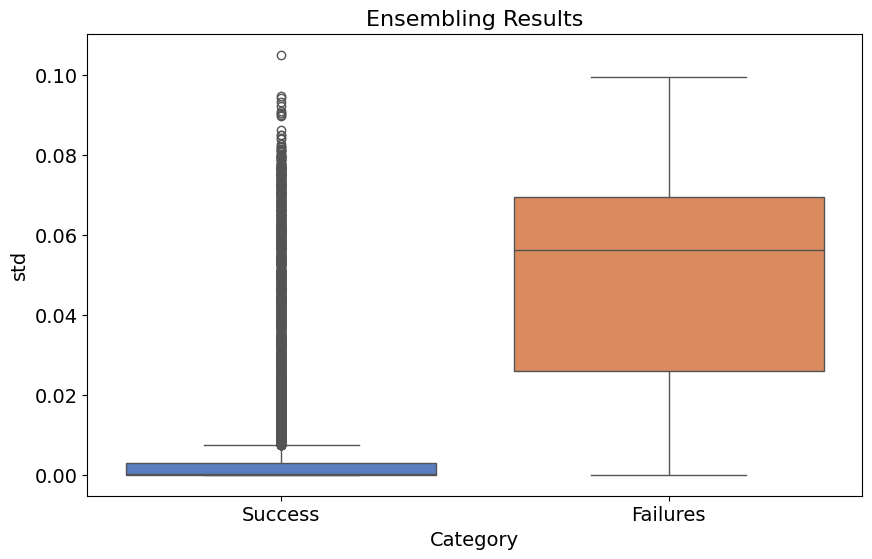

0.8828011634535655
Applying augmentation n : 0
Applying augmentation n : 0
Applying augmentation n : 0
Applying augmentation n : 0
Applying augmentation n : 0


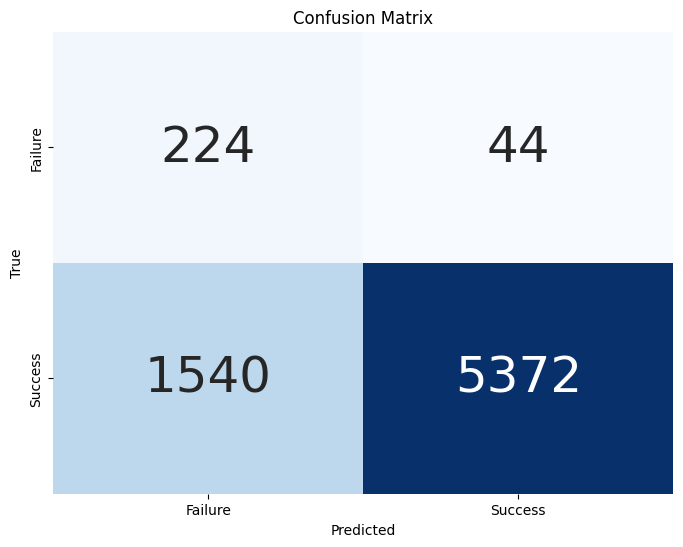

Optimal Threshold: 0.011349729624607806
Balanced Accuracy: 0.8065099847982311
Specificity: 0.835820895522388
Sensitivity: 0.7771990740740741


/mnt/data/psteinmetz/computer_vision_code/code/UQ_Toolbox/UQ_toolbox.py:581: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


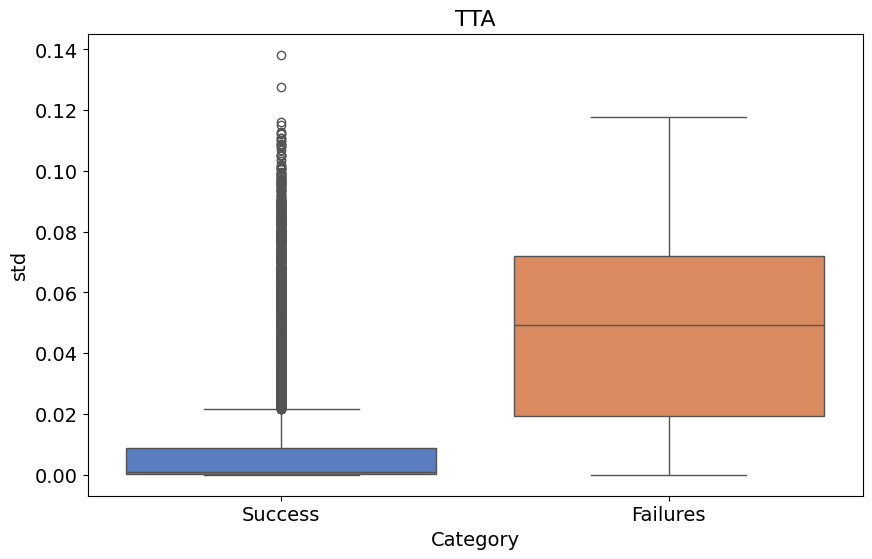

0.8513006797609177
Processing bloodmnist with color=True and activation=softmax
Training dataset size: 10936
Calibration dataset size: 2735
Training dataset size: 10936
Calibration dataset size: 2735


/tmp/ipykernel_2674608/3830283869.py:105: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


Ensemble AUC: 0.999, Ensemble Accuracy: 0.985


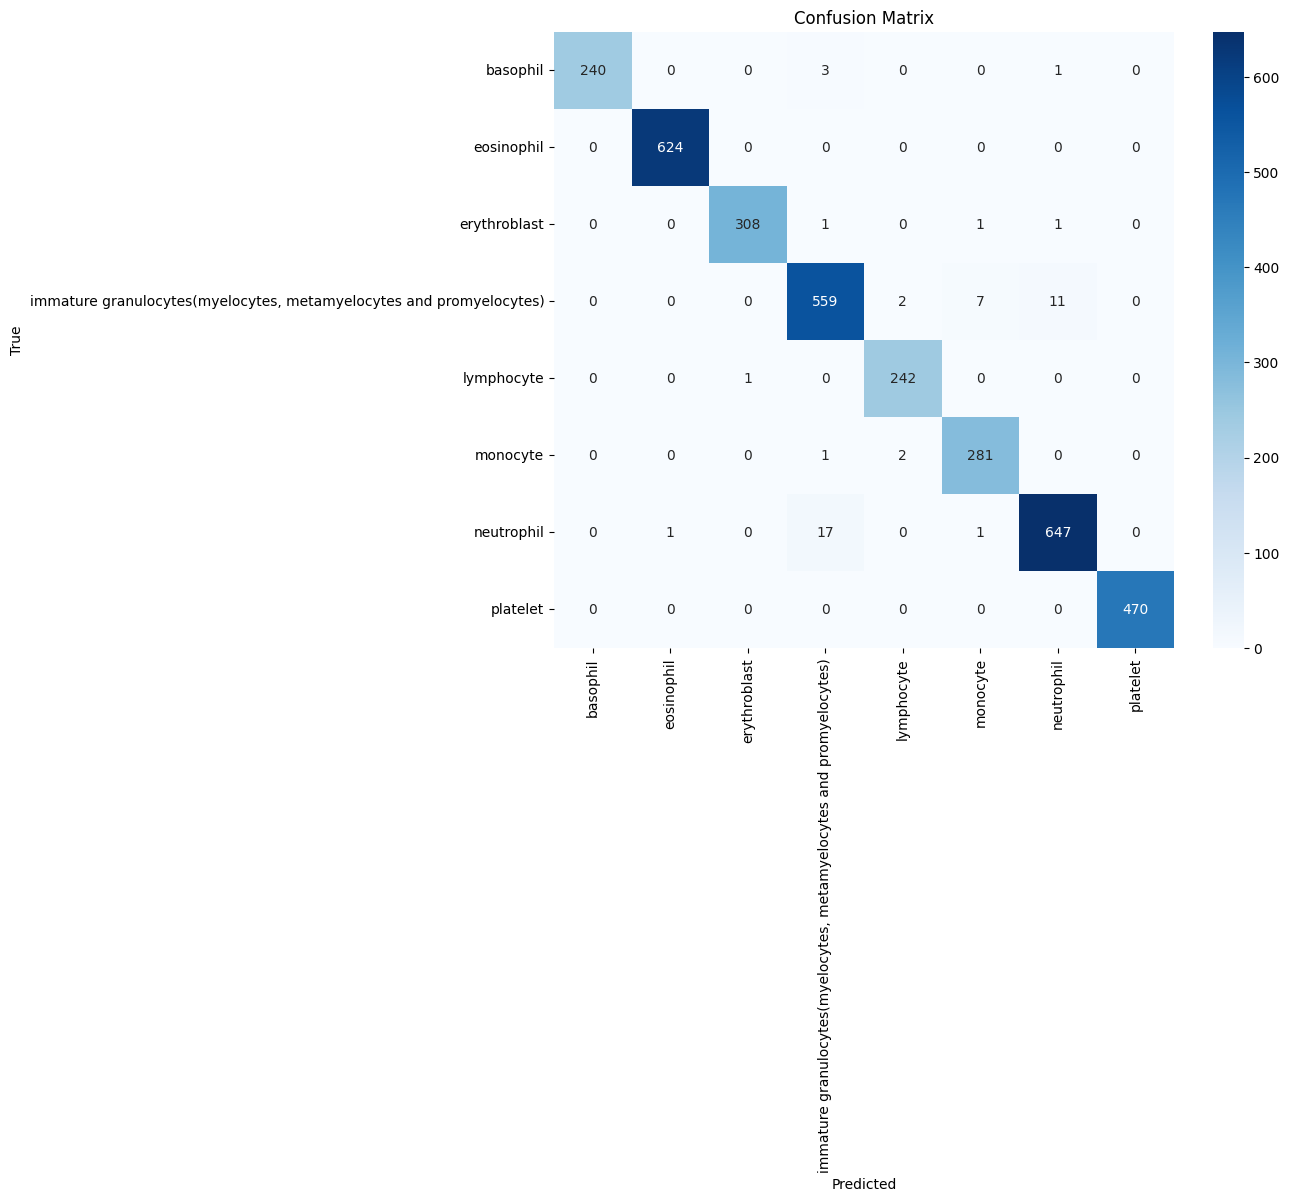

{'auc': np.float64(0.9990873983042818), 'accuracy': 0.9853843905290851, 'balanced_accuracy': np.float64(0.9870263507054398), 'sensitivity': 0.9870263507054398, 'specificity': np.float64(0.997841696699338), 'confusion_matrix': array([[240,   0,   0,   3,   0,   0,   1,   0],
       [  0, 624,   0,   0,   0,   0,   0,   0],
       [  0,   0, 308,   1,   0,   1,   1,   0],
       [  0,   0,   0, 559,   2,   7,  11,   0],
       [  0,   0,   1,   0, 242,   0,   0,   0],
       [  0,   0,   0,   1,   2, 281,   0,   0],
       [  0,   1,   0,  17,   0,   1, 647,   0],
       [  0,   0,   0,   0,   0,   0,   0, 470]])}


/tmp/ipykernel_2674608/3830283869.py:105: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


Ensemble AUC: 1.000, Ensemble Accuracy: 0.980


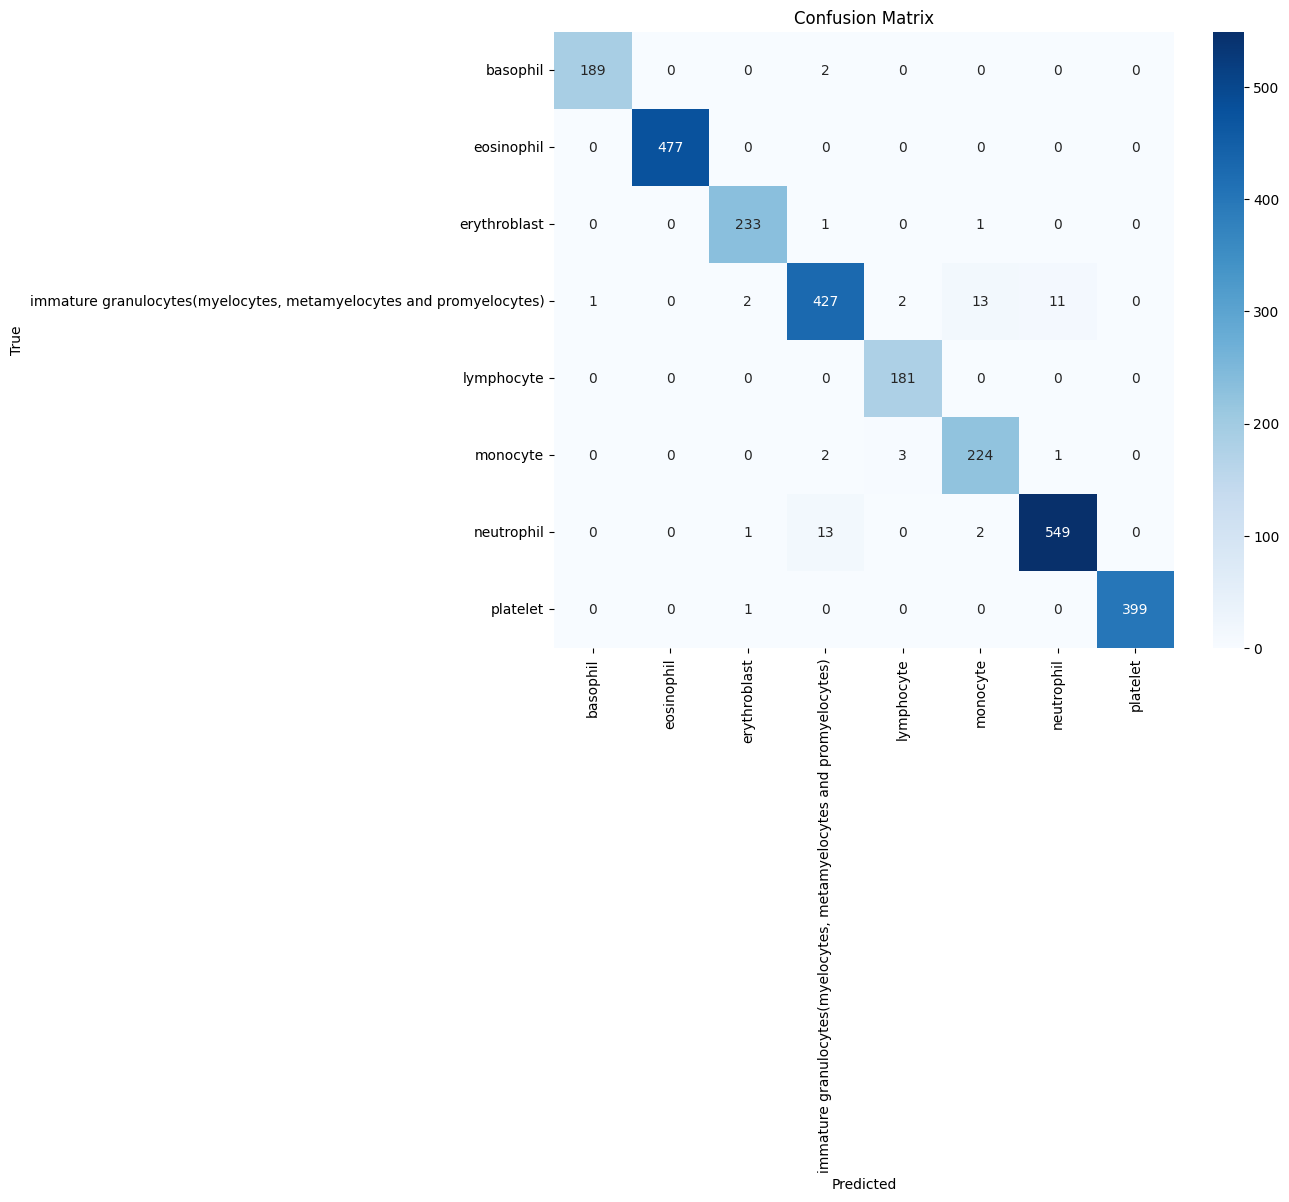

{'auc': np.float64(0.9995614805186458), 'accuracy': 0.9795246800731261, 'balanced_accuracy': np.float64(0.9825645157116301), 'sensitivity': 0.9825645157116301, 'specificity': np.float64(0.9970292280521182), 'confusion_matrix': array([[189,   0,   0,   2,   0,   0,   0,   0],
       [  0, 477,   0,   0,   0,   0,   0,   0],
       [  0,   0, 233,   1,   0,   1,   0,   0],
       [  1,   0,   2, 427,   2,  13,  11,   0],
       [  0,   0,   0,   0, 181,   0,   0,   0],
       [  0,   0,   0,   2,   3, 224,   1,   0],
       [  0,   0,   1,  13,   0,   2, 549,   0],
       [  0,   0,   1,   0,   0,   0,   0, 399]])}


/tmp/ipykernel_2674608/3830283869.py:105: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


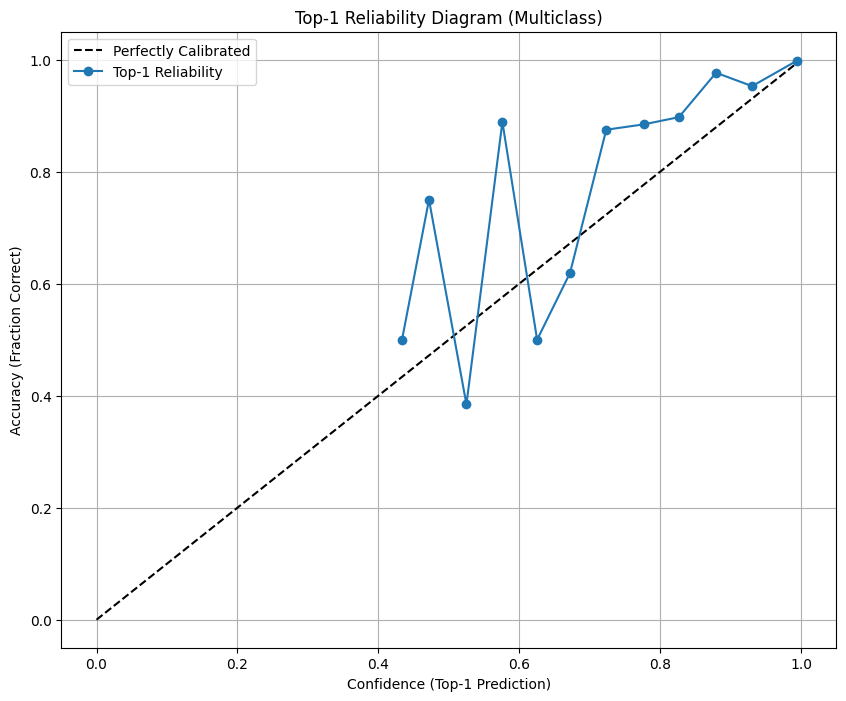

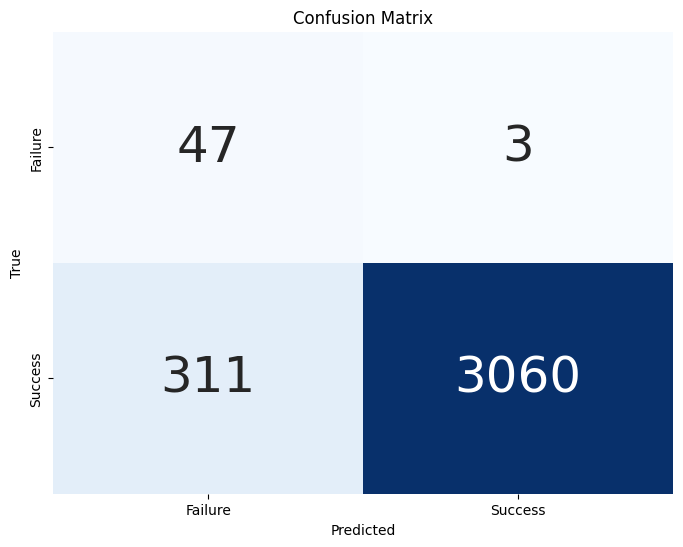

Optimal Threshold: 0.03762705624103546
Balanced Accuracy: 0.923871254820528
Specificity: 0.94
Sensitivity: 0.9077425096410561


/mnt/data/psteinmetz/computer_vision_code/code/UQ_Toolbox/UQ_toolbox.py:581: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


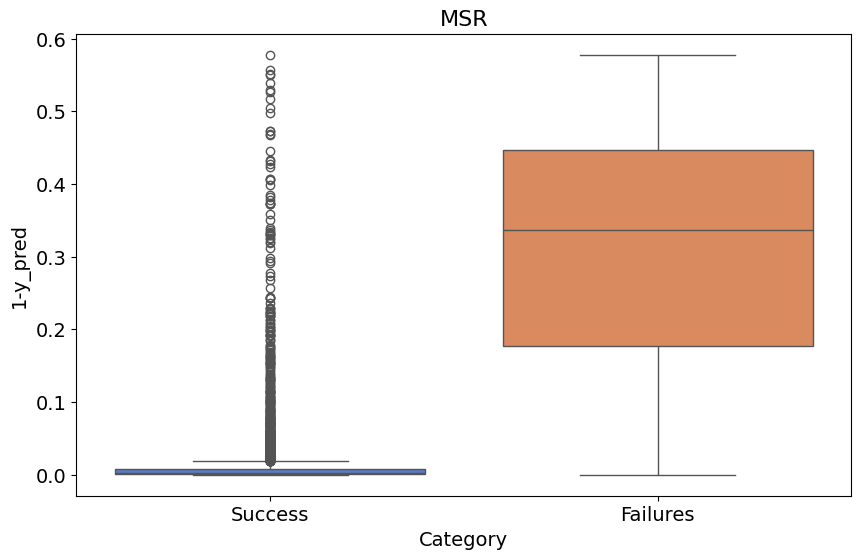

0.9361495105309997
Initial log-temperature: 0.4055
Initial temperature: 1.5000
Optimized log-temperature: 0.1416
Optimized temperature: 1.1522
Brier Score Loss (temperature): 0.0070


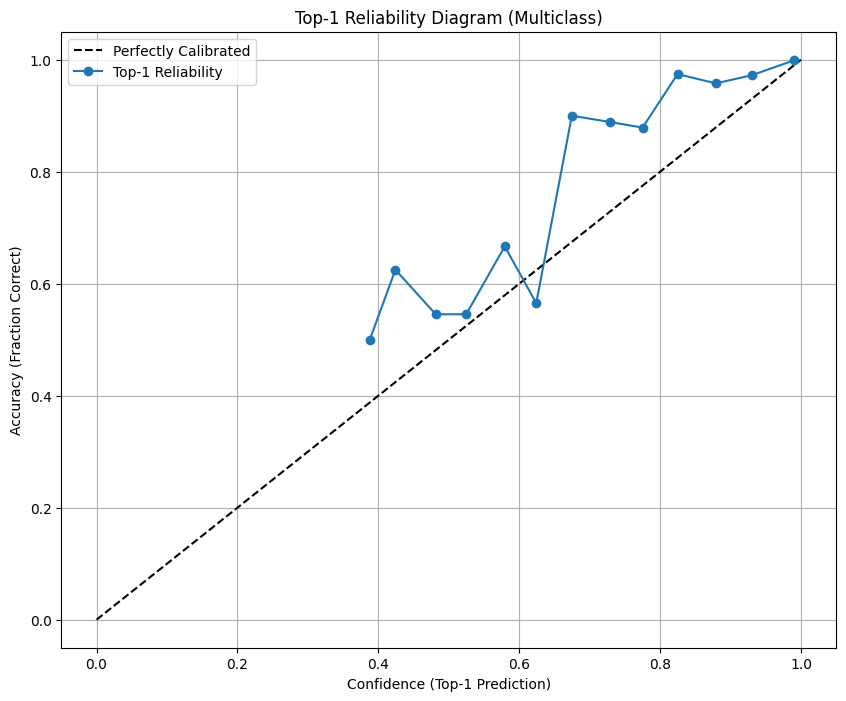

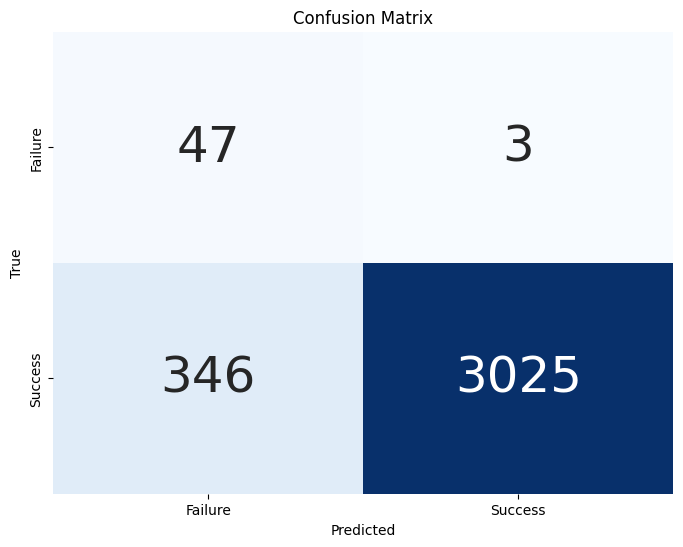

Optimal Threshold: 0.05730089545249939
Balanced Accuracy: 0.9186799169385939
Specificity: 0.94
Sensitivity: 0.8973598338771878


/mnt/data/psteinmetz/computer_vision_code/code/UQ_Toolbox/UQ_toolbox.py:581: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


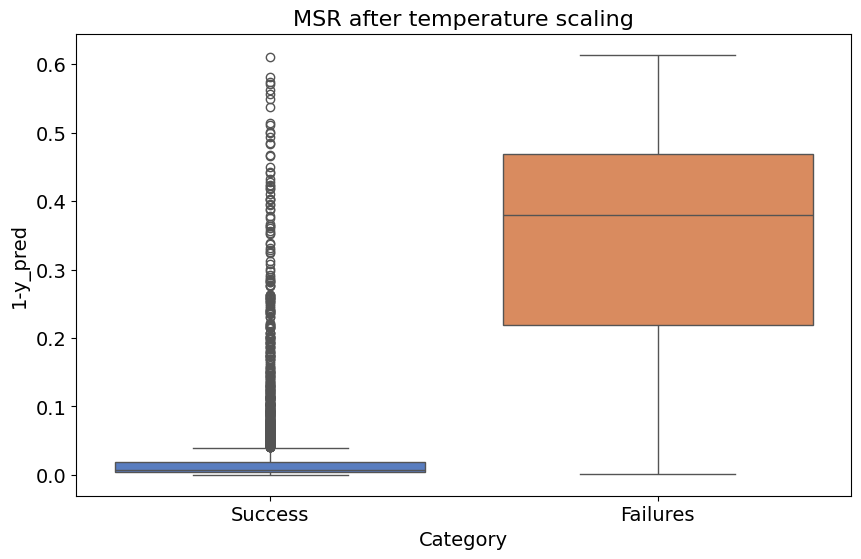

0.9355562147730644


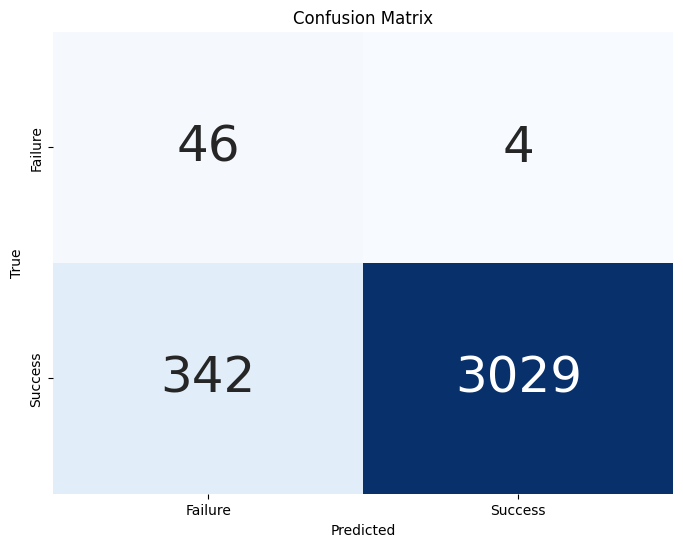

Optimal Threshold: 0.00961602758616209
Balanced Accuracy: 0.9092732126965293
Specificity: 0.92
Sensitivity: 0.8985464253930584


/mnt/data/psteinmetz/computer_vision_code/code/UQ_Toolbox/UQ_toolbox.py:581: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


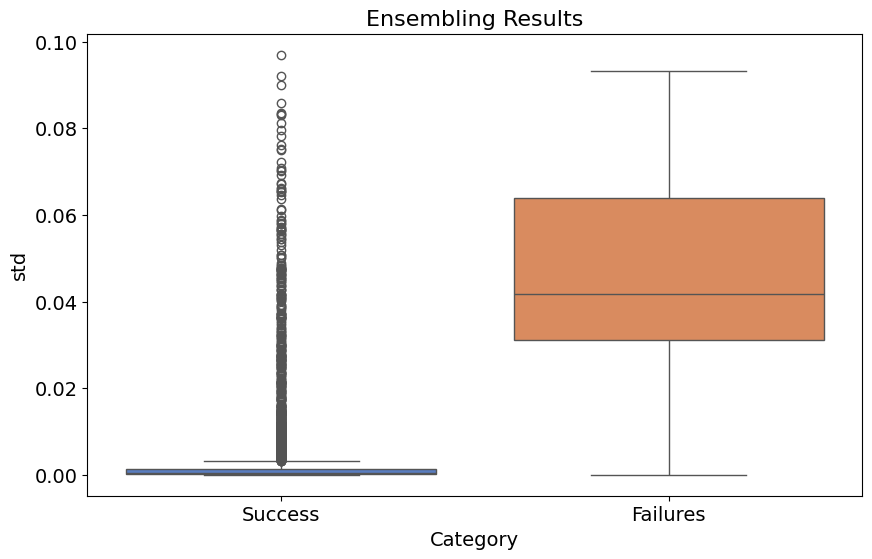

0.9284663304657371
Applying augmentation n : 0
Applying augmentation n : 0
Applying augmentation n : 0
Applying augmentation n : 0
Applying augmentation n : 0


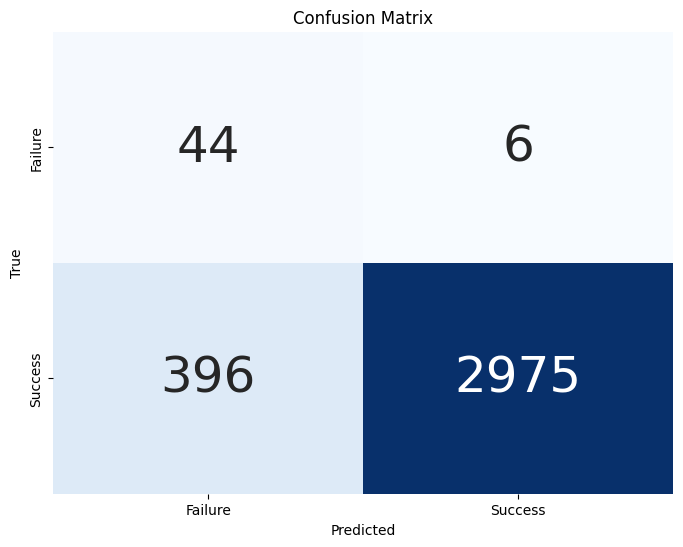

Optimal Threshold: 0.01855816171568362
Balanced Accuracy: 0.8812637199644022
Specificity: 0.88
Sensitivity: 0.8825274399288046


/mnt/data/psteinmetz/computer_vision_code/code/UQ_Toolbox/UQ_toolbox.py:581: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


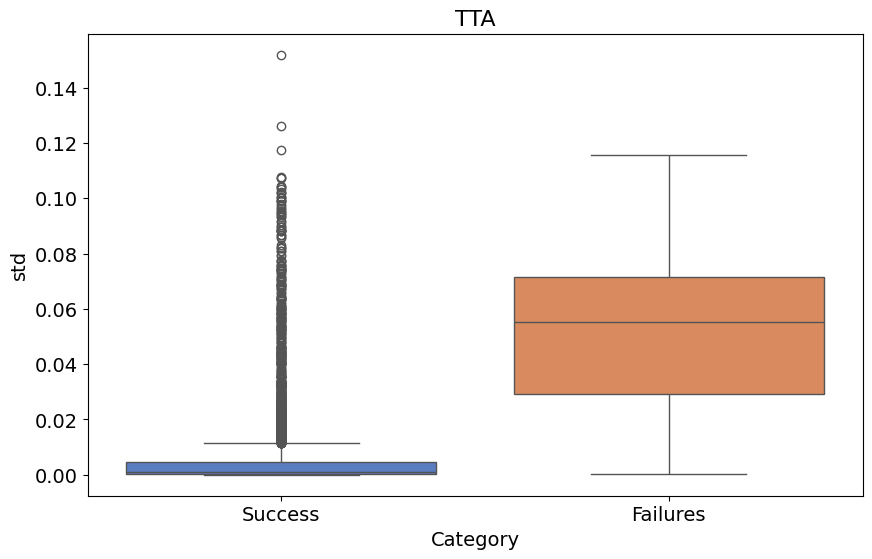

0.9111717591219222
Processing tissuemnist with color=False and activation=softmax
Training dataset size: 151284
Calibration dataset size: 37822
Training dataset size: 151284
Calibration dataset size: 37822


/tmp/ipykernel_2674608/3830283869.py:105: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


Ensemble AUC: 0.945, Ensemble Accuracy: 0.718


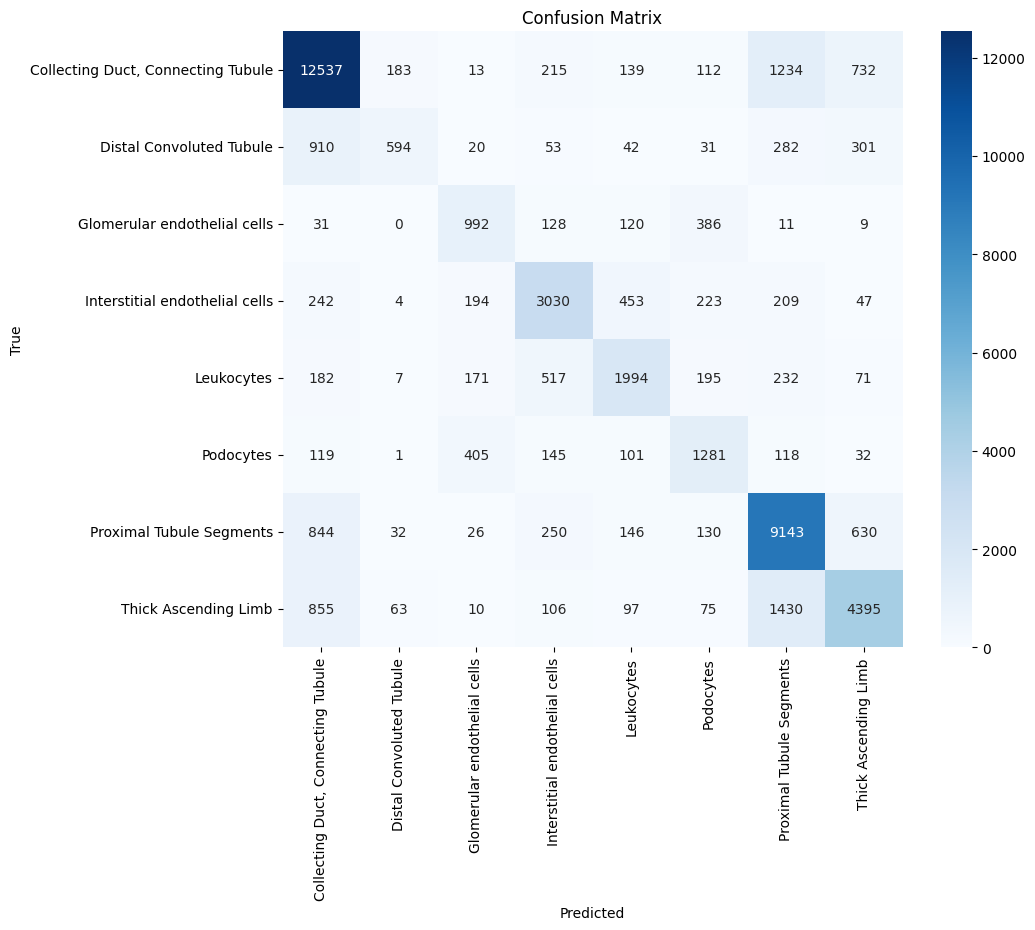

{'auc': np.float64(0.9446804018697833), 'accuracy': 0.7184010152284264, 'balanced_accuracy': np.float64(0.6234422825503838), 'sensitivity': 0.6234422825503838, 'specificity': np.float64(0.9562240842017475), 'confusion_matrix': array([[12537,   183,    13,   215,   139,   112,  1234,   732],
       [  910,   594,    20,    53,    42,    31,   282,   301],
       [   31,     0,   992,   128,   120,   386,    11,     9],
       [  242,     4,   194,  3030,   453,   223,   209,    47],
       [  182,     7,   171,   517,  1994,   195,   232,    71],
       [  119,     1,   405,   145,   101,  1281,   118,    32],
       [  844,    32,    26,   250,   146,   130,  9143,   630],
       [  855,    63,    10,   106,    97,    75,  1430,  4395]])}


/tmp/ipykernel_2674608/3830283869.py:105: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


Ensemble AUC: 0.945, Ensemble Accuracy: 0.720


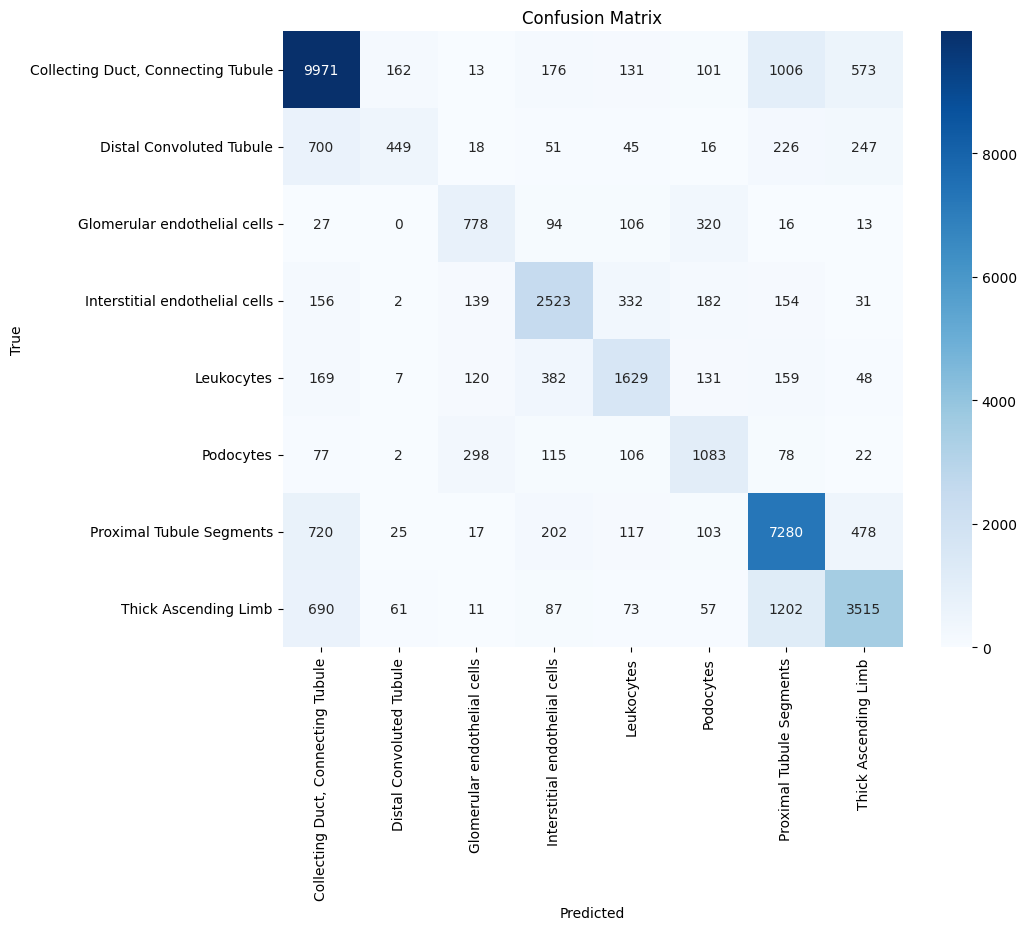

{'auc': np.float64(0.9449904333667771), 'accuracy': 0.719898471788906, 'balanced_accuracy': np.float64(0.628105661858851), 'sensitivity': 0.628105661858851, 'specificity': np.float64(0.9564222469256191), 'confusion_matrix': array([[9971,  162,   13,  176,  131,  101, 1006,  573],
       [ 700,  449,   18,   51,   45,   16,  226,  247],
       [  27,    0,  778,   94,  106,  320,   16,   13],
       [ 156,    2,  139, 2523,  332,  182,  154,   31],
       [ 169,    7,  120,  382, 1629,  131,  159,   48],
       [  77,    2,  298,  115,  106, 1083,   78,   22],
       [ 720,   25,   17,  202,  117,  103, 7280,  478],
       [ 690,   61,   11,   87,   73,   57, 1202, 3515]])}


/tmp/ipykernel_2674608/3830283869.py:105: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


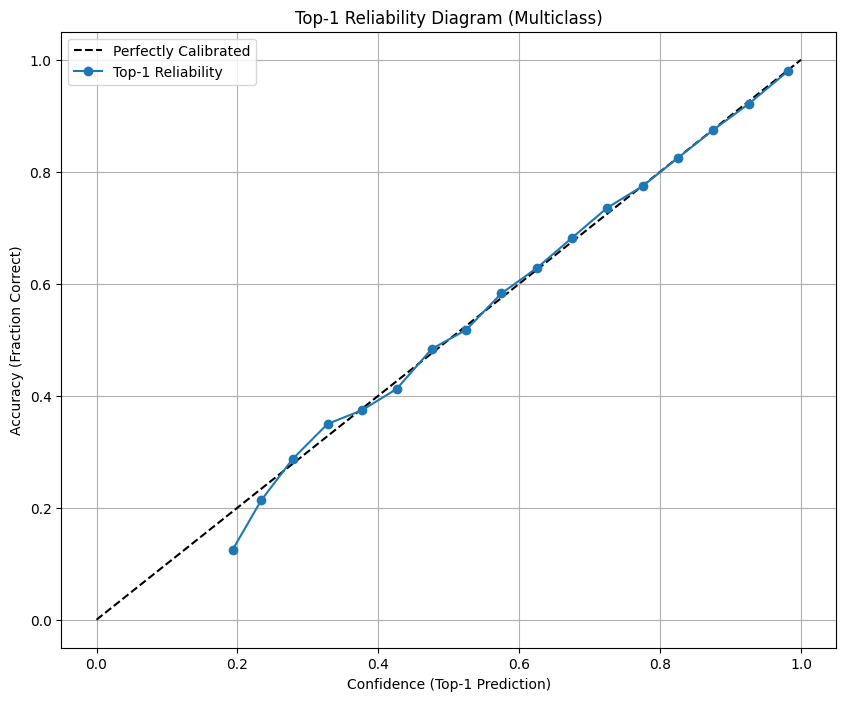

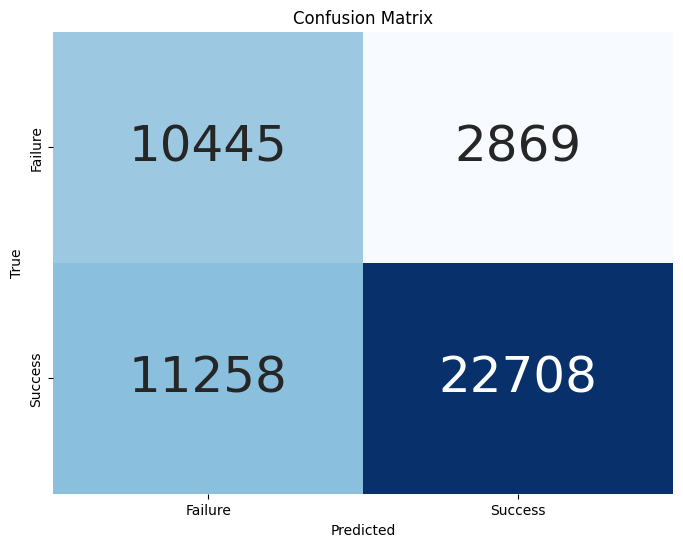

Optimal Threshold: 0.2970917820930481
Balanced Accuracy: 0.7265317235163218
Specificity: 0.7845125431876221
Sensitivity: 0.6685509038450215


/mnt/data/psteinmetz/computer_vision_code/code/UQ_Toolbox/UQ_toolbox.py:581: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


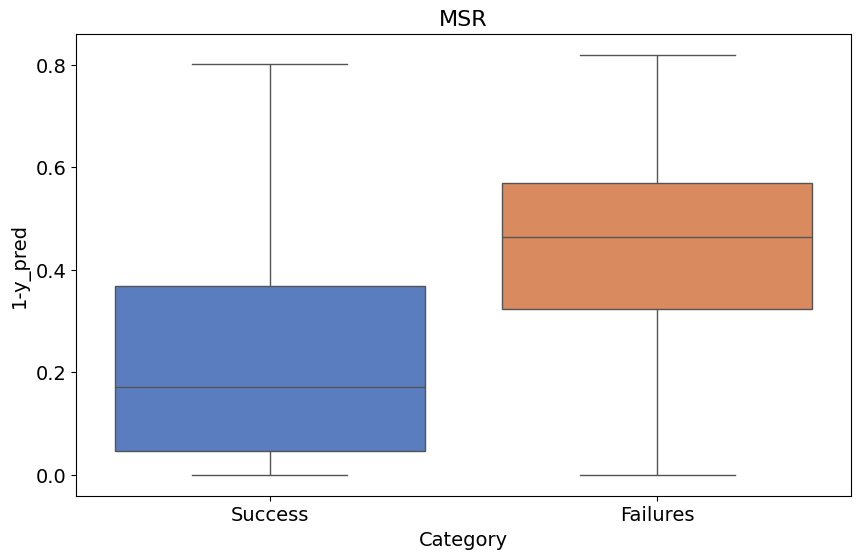

0.7967563908755844
Initial log-temperature: 0.4055
Initial temperature: 1.5000
Optimized log-temperature: 0.2191
Optimized temperature: 1.2449
Brier Score Loss (temperature): 0.0998


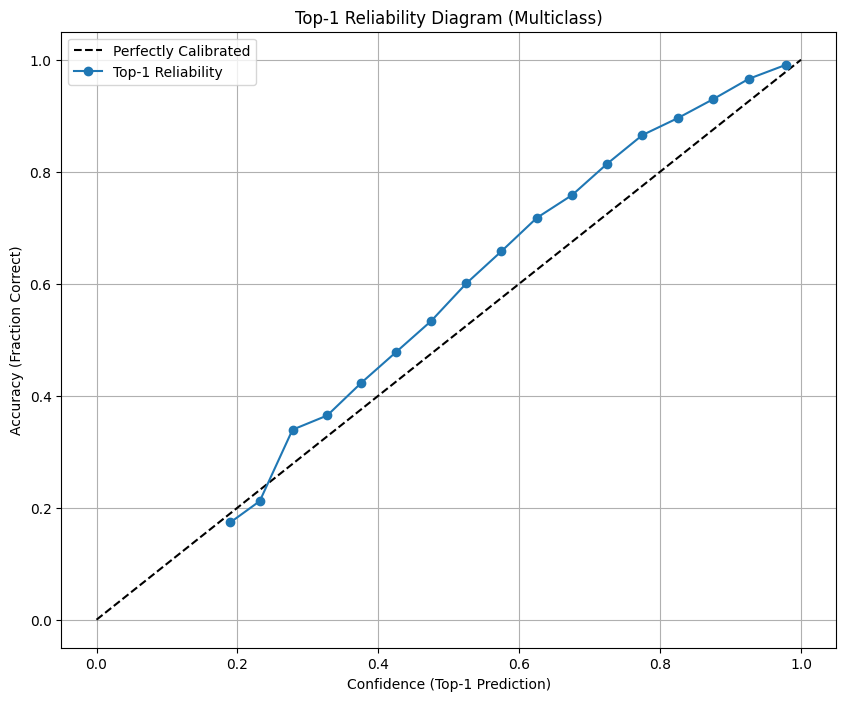

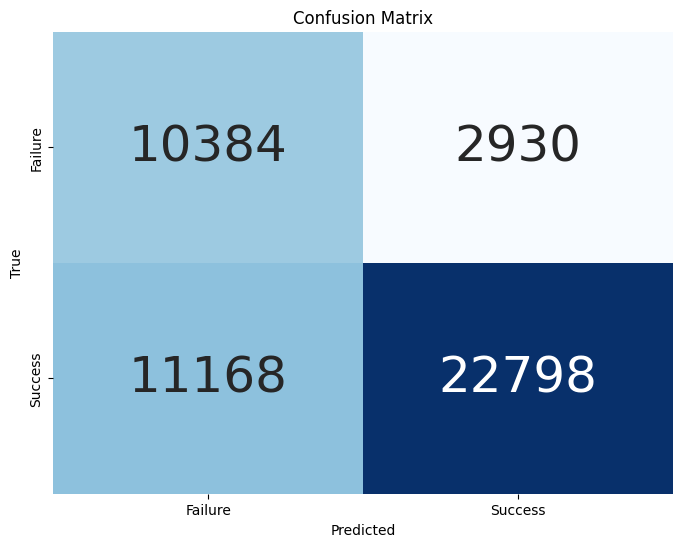

Optimal Threshold: 0.38451215624809265
Balanced Accuracy: 0.7255657560908999
Specificity: 0.7799308998047169
Sensitivity: 0.671200612377083


/mnt/data/psteinmetz/computer_vision_code/code/UQ_Toolbox/UQ_toolbox.py:581: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


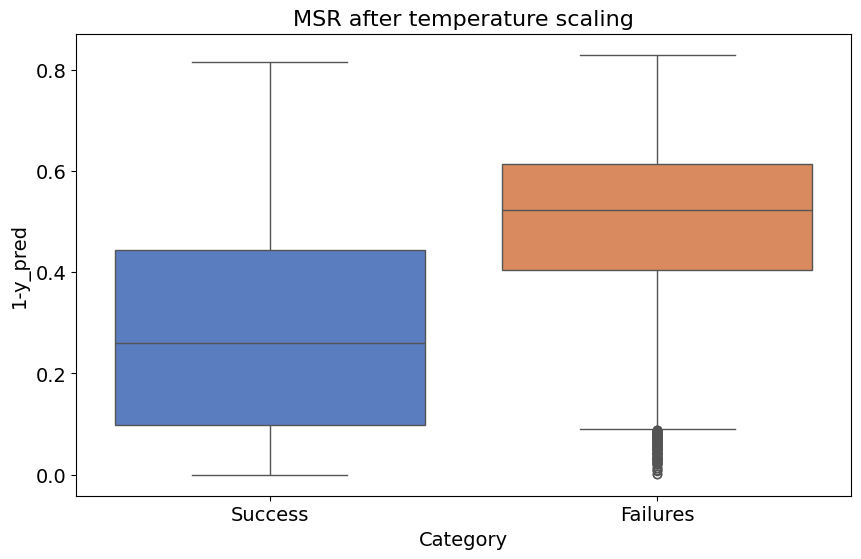

0.7956781868685747


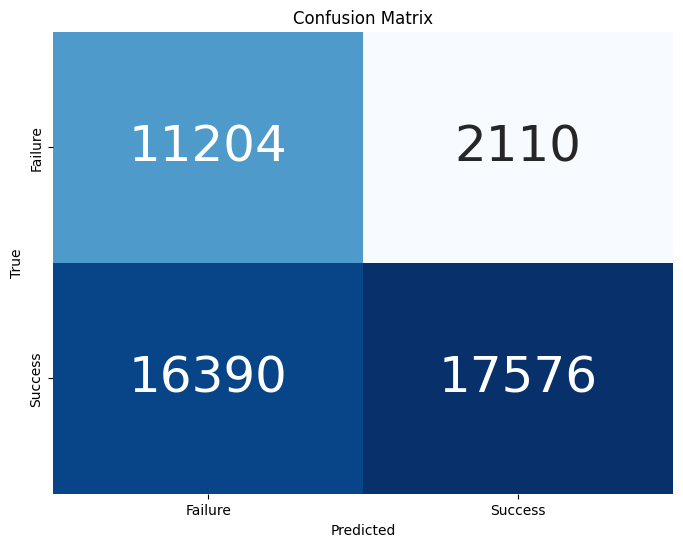

Optimal Threshold: 0.03396204113960266
Balanced Accuracy: 0.6794894197009618
Specificity: 0.8415202042962295
Sensitivity: 0.5174586351056939


/mnt/data/psteinmetz/computer_vision_code/code/UQ_Toolbox/UQ_toolbox.py:581: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


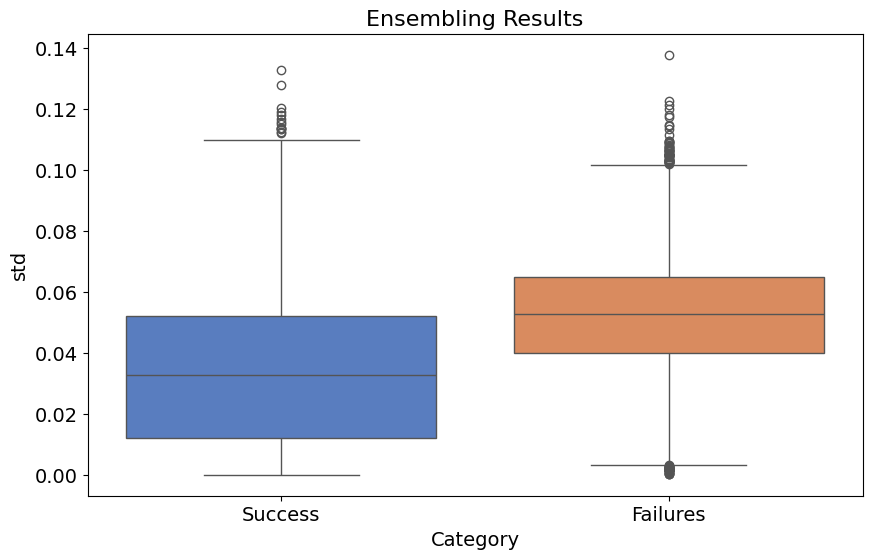

0.7254039378119295
Applying augmentation n : 0
Applying augmentation n : 0
Applying augmentation n : 0
Applying augmentation n : 0
Applying augmentation n : 0


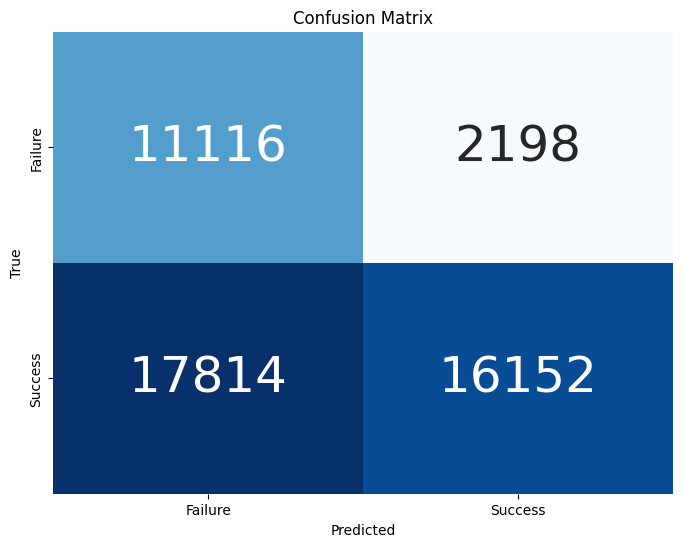

Optimal Threshold: 0.01885612201583278
Balanced Accuracy: 0.6552224891434393
Specificity: 0.8349106203995794
Sensitivity: 0.4755343578872991


/mnt/data/psteinmetz/computer_vision_code/code/UQ_Toolbox/UQ_toolbox.py:581: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


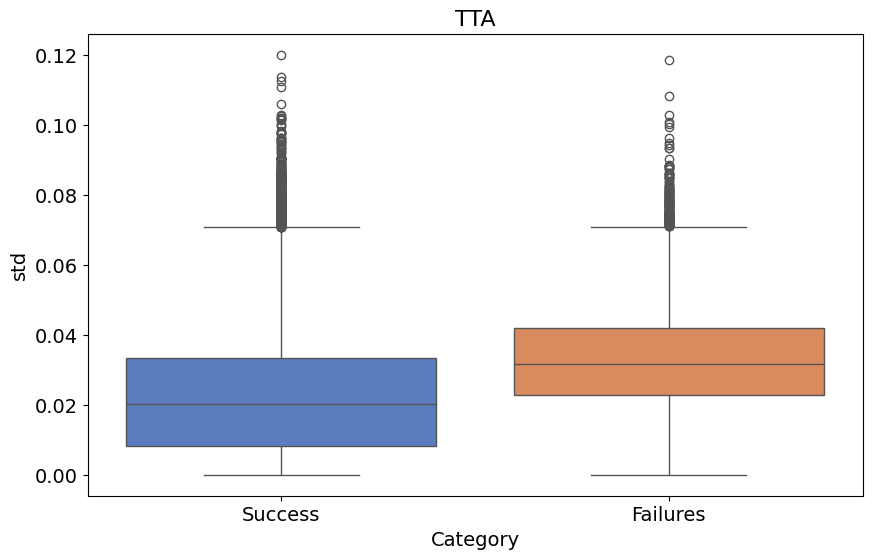

0.6933211454613075


In [9]:
flags = ['breastmnist', 'organamnist', 'pneumoniamnist', 'dermamnist', 'octmnist', 'pathmnist', 'bloodmnist', 'tissuemnist']
calib_method = ['platt', 'temperature', 'platt', 'temperature', 'temperature', 'temperature', 'temperature', 'temperature']
colors = [False, False, False, True, False, True, True, False]  # Colors for the flags
activations = ['sigmoid', 'softmax', 'sigmoid', 'softmax', 'softmax', 'softmax', 'softmax', 'softmax']  # Output activations for each flag
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
uq_methods = ['MSR', 'MSR_temp_scale', 'Ensembling', 'TTA']#, 'GPS', 'KNNshap', 'KNNall']   
size = 224  # Image size for the models
batch_size = 4000  # Batch size for the DataLoader
model_global_perfs = {}

for flag, color, activation, calib_method in zip(flags, colors, activations, calib_method):
    print(f"Processing {flag} with color={color} and activation={activation}")
    if color is True:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])
        ])
        
        transform_tta = transforms.Compose([
            transforms.ToTensor()
        ])
    else:
        # For grayscale images, repeat the single channel to make it compatible with ResNet
        # ResNet expects 3 channels, so we repeat the single channel image
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[.5], std=[.5]),
            transforms.Lambda(lambda x: x.repeat(3, 1, 1))
        ])
        
        transform_tta = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.repeat(3, 1, 1))
            ])
    models = tr.load_models(flag, device=device)
    [train_dataset, calibration_dataset, test_dataset], [train_loader, calibration_loader, test_loader], info = tr.load_datasets(flag, color, size, transform, batch_size)
    train_loaders, val_loaders = train_val_loaders(train_dataset, batch_size=batch_size)
    task_type = info['task']  # Determine the task type (binary-class or multi-class)
    num_classes = len(info['label'])  # Number of classes
    [_, calibration_dataset_tta, test_dataset_tta], [_, calibration_loader_tta, test_loader_tta], _ = tr.load_datasets(flag, color, size, transform_tta, batch_size)

    y_true, y_scores, digits, indiv_scores, performances = test_eval(test_loader, device=device, models=models, data_flag=flag)
    y_true_calibration, y_scores_calibration, digits_calib, indiv_scores_calib, performances_calib = test_eval(calibration_loader, device=device, models=models, data_flag=flag)

    if task_type == 'binary-class':
        y_prob = y_scores
        y_prob_calibration = y_scores_calibration
    else:
        y_prob = apply_softmax(y_scores)
        y_prob_calibration = apply_softmax(y_scores_calibration)

    if task_type == 'binary-class':
        correct_predictions = [i for i in range(len(y_true)) if (y_true[i] == 1 and y_scores[i] > 0.5) or (y_true[i] == 0 and y_scores[i] <= 0.5)]
        incorrect_predictions = [i for i in range(len(y_true)) if (y_true[i] == 1 and y_scores[i] <= 0.5) or (y_true[i] == 0 and y_scores[i] > 0.5)]

        correct_predictions_calibration = [i for i in range(len(y_true_calibration)) if (y_true_calibration[i] == 1 and y_scores_calibration[i] > 0.5) or (y_true_calibration[i] == 0 and y_scores_calibration[i] <= 0.5)]
        incorrect_predictions_calibration = [i for i in range(len(y_true_calibration)) if (y_true_calibration[i] == 1 and y_scores_calibration[i] <= 0.5) or (y_true_calibration[i] == 0 and y_scores_calibration[i] > 0.5)]
    else:
        correct_predictions = [i for i in range(len(y_true)) if y_true[i] == np.argmax(y_scores[i])]
        incorrect_predictions = [i for i in range(len(y_true)) if y_true[i] != np.argmax(y_scores[i])]

        correct_predictions_calibration = [i for i in range(len(y_true_calibration)) if y_true_calibration[i] == np.argmax(y_scores_calibration[i])]
        incorrect_predictions_calibration = [i for i in range(len(y_true_calibration)) if y_true_calibration[i] != np.argmax(y_scores_calibration[i])]
    uq_metrics, aucs, balanced_acc = call_UQ_methods(uq_methods, models, y_prob, digits, y_true, digits_calib, y_true_calibration, indiv_scores, task_type, correct_predictions, incorrect_predictions, test_loader, device, optim_metric='balanced_accuracy', train_loaders=train_loaders, test_dataset_tta=test_dataset_tta, num_classes=num_classes, image_normalization=True, swarmplot=False, calib_method=calib_method, batch_size=batch_size, color=color, aug_folder=f'gps_augment/{size}*{size}/{flag}_calibration_set', correct_predictions_calibration=correct_predictions_calibration, incorrect_predictions_calibration=incorrect_predictions_calibration, image_size=size)
    model_global_perfs[flag] = {}
    model_global_perfs[flag]['class_perf'] = performances
    model_global_perfs[flag]['calibration_size'] = len(calibration_dataset)
    model_global_perfs[flag]['uq_metrics'] = uq_metrics
    model_global_perfs[flag]['aucs_UQ'] = aucs
    model_global_perfs[flag]['balanced_acc_UQ'] = balanced_acc
with open("model_global_perfs_augmented.pkl", "wb") as f:
    pkl.dump(model_global_perfs, f)

In [ ]:
flags = ['breastmnist', 'organamnist', 'pneumoniamnist', 'dermamnist', 'octmnist', 'pathmnist', 'bloodmnist', 'tissuemnist']
calib_method = ['platt', 'temperature', 'platt', 'temperature', 'temperature', 'temperature', 'temperature', 'temperature']
colors = [False, False, False, True, False, True, True, False]  # Colors for the flags
activations = ['sigmoid', 'softmax', 'sigmoid', 'softmax', 'softmax', 'softmax', 'softmax', 'softmax']  # Output activations for each flag
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
uq_methods = ['TTA', 'TTA_without_geometric_transforms']#, 'GPS', 'KNNshap', 'KNNall']  
size = 224  # Image size for the models
batch_size = 4000  # Batch size for the DataLoader
model_global_perfs = {}

for flag, color, activation, calib_method in zip(flags, colors, activations, calib_method):
    print(f"Processing {flag} with color={color} and activation={activation}")
    if color is True:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])
        ])
        
        transform_tta = transforms.Compose([
            transforms.ToTensor()
        ])
    else:
        # For grayscale images, repeat the single channel to make it compatible with ResNet
        # ResNet expects 3 channels, so we repeat the single channel image
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[.5], std=[.5]),
            transforms.Lambda(lambda x: x.repeat(3, 1, 1))
        ])
        
        transform_tta = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.repeat(3, 1, 1))
            ])
    models = tr.load_models(flag, device=device)
    [train_dataset, calibration_dataset, test_dataset], [train_loader, calibration_loader, test_loader], info = tr.load_datasets(flag, color, size, transform, batch_size)
    train_loaders, val_loaders = train_val_loaders(train_dataset, batch_size=batch_size)
    task_type = info['task']  # Determine the task type (binary-class or multi-class)
    num_classes = len(info['label'])  # Number of classes
    [_, calibration_dataset_tta, test_dataset_tta], [_, calibration_loader_tta, test_loader_tta], _ = tr.load_datasets(flag, color, size, transform_tta, batch_size)

    y_true, y_scores, digits, indiv_scores, performances = test_eval(test_loader, device=device, models=models, data_flag=flag)
    y_true_calibration, y_scores_calibration, digits_calib, indiv_scores_calib, performances_calib = test_eval(calibration_loader, device=device, models=models, data_flag=flag)

    if task_type == 'binary-class':
        y_prob = y_scores
        y_prob_calibration = y_scores_calibration
    else:
        y_prob = apply_softmax(y_scores)
        y_prob_calibration = apply_softmax(y_scores_calibration)

    if task_type == 'binary-class':
        correct_predictions = [i for i in range(len(y_true)) if (y_true[i] == 1 and y_scores[i] > 0.5) or (y_true[i] == 0 and y_scores[i] <= 0.5)]
        incorrect_predictions = [i for i in range(len(y_true)) if (y_true[i] == 1 and y_scores[i] <= 0.5) or (y_true[i] == 0 and y_scores[i] > 0.5)]

        correct_predictions_calibration = [i for i in range(len(y_true_calibration)) if (y_true_calibration[i] == 1 and y_scores_calibration[i] > 0.5) or (y_true_calibration[i] == 0 and y_scores_calibration[i] <= 0.5)]
        incorrect_predictions_calibration = [i for i in range(len(y_true_calibration)) if (y_true_calibration[i] == 1 and y_scores_calibration[i] <= 0.5) or (y_true_calibration[i] == 0 and y_scores_calibration[i] > 0.5)]
    else:
        correct_predictions = [i for i in range(len(y_true)) if y_true[i] == np.argmax(y_scores[i])]
        incorrect_predictions = [i for i in range(len(y_true)) if y_true[i] != np.argmax(y_scores[i])]

        correct_predictions_calibration = [i for i in range(len(y_true_calibration)) if y_true_calibration[i] == np.argmax(y_scores_calibration[i])]
        incorrect_predictions_calibration = [i for i in range(len(y_true_calibration)) if y_true_calibration[i] != np.argmax(y_scores_calibration[i])]

    uq_metrics, aucs, balanced_acc = call_UQ_methods(uq_methods, models, y_prob, digits, y_true, digits_calib, y_true_calibration, indiv_scores, task_type, correct_predictions, incorrect_predictions, test_loader, device, optim_metric='balanced_accuracy', train_loaders=train_loaders, test_dataset_tta=test_dataset_tta, num_classes=num_classes, image_normalization=True, swarmplot=False, calib_method=calib_method, batch_size=batch_size, color=color)
    model_global_perfs[flag] = {}
    model_global_perfs[flag]['class_perf'] = performances
    model_global_perfs[flag]['calibration_size'] = len(calibration_dataset)
    model_global_perfs[flag]['uq_metrics'] = uq_metrics
    model_global_perfs[flag]['aucs_UQ'] = aucs
    model_global_perfs[flag]['balanced_acc_UQ'] = balanced_acc

In [ ]:
flags = ['breastmnist', 'organamnist', 'pneumoniamnist', 'dermamnist', 'octmnist', 'pathmnist', 'bloodmnist', 'tissuemnist']
calib_method = ['platt', 'temperature', 'platt', 'temperature', 'temperature', 'temperature', 'temperature', 'temperature']
colors = [False, False, False, True, False, True, True, False]  # Colors for the flags
activations = ['sigmoid', 'softmax', 'sigmoid', 'softmax', 'softmax', 'softmax', 'softmax', 'softmax']  # Output activations for each flag
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
uq_methods = ['MSR', 'MSR_temp_scale', 'Ensembling', 'TTA']#, 'GPS', 'KNNshap', 'KNNall']  
size = 224  # Image size for the models
batch_size = 4000  # Batch size for the DataLoader
model_global_perfs = {}

for flag, color, activation, calib_method in zip(flags, colors, activations, calib_method):
    print(f"Processing {flag} with color={color} and activation={activation}")
    if color is True:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])
        ])
        
        transform_tta = transforms.Compose([
            transforms.ToTensor()
        ])
    else:
        # For grayscale images, repeat the single channel to make it compatible with ResNet
        # ResNet expects 3 channels, so we repeat the single channel image
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[.5], std=[.5]),
            transforms.Lambda(lambda x: x.repeat(3, 1, 1))
        ])
        
        transform_tta = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.repeat(3, 1, 1))
            ])
    models = tr.load_models(flag, device=device)
    [train_dataset, calibration_dataset, test_dataset], [train_loader, calibration_loader, test_loader], info = tr.load_datasets(flag, color, size, transform, batch_size)
    train_loaders, val_loaders = train_val_loaders(train_dataset, batch_size=batch_size)
    task_type = info['task']  # Determine the task type (binary-class or multi-class)
    num_classes = len(info['label'])  # Number of classes
    [_, calibration_dataset_tta, test_dataset_tta], [_, calibration_loader_tta, test_loader_tta], _ = tr.load_datasets(flag, color, size, transform_tta, batch_size)

    y_true, y_scores, digits, indiv_scores, performances = test_eval(test_loader, device=device, models=models, data_flag=flag)
    y_true_calibration, y_scores_calibration, digits_calib, indiv_scores_calib, performances_calib = test_eval(calibration_loader, device=device, models=models, data_flag=flag)

    if task_type == 'binary-class':
        y_prob = y_scores
        y_prob_calibration = y_scores_calibration
    else:
        y_prob = apply_softmax(y_scores)
        y_prob_calibration = apply_softmax(y_scores_calibration)

    if task_type == 'binary-class':
        correct_predictions = [i for i in range(len(y_true)) if (y_true[i] == 1 and y_scores[i] > 0.5) or (y_true[i] == 0 and y_scores[i] <= 0.5)]
        incorrect_predictions = [i for i in range(len(y_true)) if (y_true[i] == 1 and y_scores[i] <= 0.5) or (y_true[i] == 0 and y_scores[i] > 0.5)]

        correct_predictions_calibration = [i for i in range(len(y_true_calibration)) if (y_true_calibration[i] == 1 and y_scores_calibration[i] > 0.5) or (y_true_calibration[i] == 0 and y_scores_calibration[i] <= 0.5)]
        incorrect_predictions_calibration = [i for i in range(len(y_true_calibration)) if (y_true_calibration[i] == 1 and y_scores_calibration[i] <= 0.5) or (y_true_calibration[i] == 0 and y_scores_calibration[i] > 0.5)]
    else:
        correct_predictions = [i for i in range(len(y_true)) if y_true[i] == np.argmax(y_scores[i])]
        incorrect_predictions = [i for i in range(len(y_true)) if y_true[i] != np.argmax(y_scores[i])]

        correct_predictions_calibration = [i for i in range(len(y_true_calibration)) if y_true_calibration[i] == np.argmax(y_scores_calibration[i])]
        incorrect_predictions_calibration = [i for i in range(len(y_true_calibration)) if y_true_calibration[i] != np.argmax(y_scores_calibration[i])]

    uq_metrics, aucs, balanced_acc = call_UQ_methods(uq_methods, models, y_prob, digits, y_true, digits_calib, y_true_calibration, indiv_scores, task_type, correct_predictions, incorrect_predictions, test_loader, device, optim_metric='balanced_accuracy', train_loaders=train_loaders, test_dataset_tta=test_dataset_tta, num_classes=num_classes, image_normalization=True, swarmplot=False, calib_method=calib_method, batch_size=batch_size, color=color)
    model_global_perfs[flag] = {}
    model_global_perfs[flag]['class_perf'] = performances
    model_global_perfs[flag]['calibration_size'] = len(calibration_dataset)
    model_global_perfs[flag]['uq_metrics'] = uq_metrics
    model_global_perfs[flag]['aucs_UQ'] = aucs
    model_global_perfs[flag]['balanced_acc_UQ'] = balanced_acc

In [ ]:
with open("model_global_perfs.pkl", "wb") as f:
    pkl.dump(model_global_perfs, f)

In [ ]:
with open("model_global_perfs.pkl", "rb") as f:
    model_global_perfs = pkl.load(f)

In [ ]:
def plot_perf_vs_uq_perf(perf_dicts, perf_uq, calibration_sizes, uq_methods_names=None):
    """
    Scatter plots:
    1. Balanced accuracy of model performance vs. AUC of UQ methods tested.
    2. Calibration data size vs. AUC of UQ methods tested.

    Args:
        perf_dicts (list of dict): List of performance dictionaries, each with 'balanced_accuracy' key.
        aucs (list of float): List of precomputed AUCs for each UQ method.
        calibration_sizes (list of int): List of calibration data sizes (one per experiment).
        uq_methods_names (list of str, optional): Names of UQ methods to plot. If None, use all.
    """
    # If method names are not provided, use generic names
    if uq_methods_names is None:
        uq_methods_names = [f"Method {i+1}" for i in range(len(perf_uq))]

    # 1. Balanced accuracy vs. AUC
    balanced_accuracies = [perf['balanced_accuracy'] for perf in perf_dicts]
    plt.figure(figsize=(10, 8))
    plt.scatter(balanced_accuracies, perf_uq)
    try:
        texts = [plt.text(balanced_accuracies[i], perf_uq[i], txt) for i, txt in enumerate(uq_methods_names)]
        adjust_text(texts, expand=(2, 1.2), arrowprops=dict(arrowstyle='->', color='red'))
    except ImportError:
        # Fallback to default annotation if adjustText is not installed
        for i, txt in enumerate(uq_methods_names):
            plt.annotate(txt, (balanced_accuracies[i], perf_uq[i]))
    plt.xlabel('Balanced Accuracy of Model')
    plt.ylabel('Balanced Accuracy of UQ Method')
    plt.title('Classification balanced accuracy vs. UQ Method balanced accuracy')
    plt.grid(True)
    plt.show()

    # 2. Calibration data size vs. AUC
    plt.figure(figsize=(8, 6))
    plt.scatter(calibration_sizes, perf_uq)
    # Use logarithmic scale for x-axis
    plt.xscale('log')
    # Use adjustText to avoid overlapping labels
    try:
        texts = [plt.text(calibration_sizes[i], perf_uq[i], txt) for i, txt in enumerate(uq_methods_names)]
        adjust_text(texts, expand=(1.2, 2), arrowprops=dict(arrowstyle='->', color='red'))
    except ImportError:
        # Fallback to default annotation if adjustText is not installed
        for i, txt in enumerate(uq_methods_names):
            plt.annotate(txt, (calibration_sizes[i], perf_uq[i]))
    plt.xlabel('Calibration Data Size (log scale)')
    plt.ylabel('Balanced Accuracy of UQ Method')
    plt.title('Calibration Data Size vs. UQ Method balanced accuracy')
    plt.grid(True)
    plt.show()


In [ ]:
flags = ['breastmnist', 'organamnist', 'pneumoniamnist', 'dermamnist', 'octmnist', 'pathmnist', 'bloodmnist', 'tissuemnist']
# Flatten the lists so that each argument is a flat list
perf_dicts = [model_global_perfs[flag]['class_perf'] for flag in flags for _ in range(len(model_global_perfs[flag]['aucs_UQ']))]
aucs = [model_global_perfs[flag]['aucs_UQ'][i][1] for flag in flags for i in range(len(model_global_perfs[flag]['aucs_UQ']))]
balanced_acc = [model_global_perfs[flag]['balanced_acc_UQ'][i][1] for flag in flags for i in range(len(model_global_perfs[flag]['aucs_UQ']))]
calibration_sizes = [model_global_perfs[flag]['calibration_size'] for flag in flags for _ in range(len(model_global_perfs[flag]['aucs_UQ']))]
uq_methods_names = [model_global_perfs[flag]['aucs_UQ'][i][0] for flag in flags for i in range(len(model_global_perfs[flag]['aucs_UQ']))]

plot_perf_vs_uq_perf(
    perf_dicts,
    balanced_acc,
    calibration_sizes,
    uq_methods_names=uq_methods_names
)

In [ ]:
class ClassifierHeadWrapper(nn.Module):
    def __init__(self, model):
        super(ClassifierHeadWrapper, self).__init__()
        self.fc = model.fc  # Replace 'fc2' with the appropriate layer name

    def forward(self, x):
        return self.fc(x)

In [ ]:
# #Load the SHAP results from the pickle file
# with open('shap_results_calibration.pkl', 'rb') as file:
#     shap_results_calibration = pkl.load(file)

In [ ]:
# #Load the SHAP results from the pickle file
# with open('shap_results.pkl', 'rb') as file:
#     shap_results_test = pkl.load(file)

In [ ]:
models = [model.to(device) for model in models]
latent_spaces = []
shap_values_folds = []
success_folds = []
labels_fold = []
for fold in range(0, 5):
    print('fold n' + str(fold))
    classifier_head = ClassifierHeadWrapper(models[fold]).to(device)
    # Compute SHAP values for the penultimate layer
    shap_values, shap_features, labels, success = uq.extract_latent_space_and_compute_shap_importance(
        model=models[fold],
        data_loader=calibration_loader,
        device=device,
        layer_to_be_hooked=models[fold].avgpool,
        classifierheadwrapper=classifier_head,
        importance=True,
        max_background_samples=125
    )
    latent_spaces.append(shap_features)
    shap_values_folds.append(shap_values)
    success_folds.append(success.squeeze() if success.ndim > 1 else success)
    labels_fold.append(labels.squeeze() if labels.ndim > 1 else labels)

In [ ]:
models = [model.to(device) for model in models]
latent_spaces_calibration = []
shap_values_folds_calibration = []
success_folds_calibration = []
labels_fold_calibration = []
for fold in range(0, 5):
    print('fold n' + str(fold))
    classifier_head = ClassifierHeadWrapper(models[fold]).to(device)
    # Compute SHAP values for the penultimate layer
    shap_values, shap_features, labels, success = uq.extract_latent_space_and_compute_shap_importance(
        model=models[fold],
        data_loader=test_loader,
        device=device,
        layer_to_be_hooked=models[fold].avgpool,
        classifierheadwrapper=classifier_head,
        importance=True,
        max_background_samples=156
    )
    latent_spaces_calibration.append(shap_features)
    shap_values_folds_calibration.append(shap_values)
    success_folds_calibration.append(success.squeeze() if success.ndim > 1 else success)
    labels_fold_calibration.append(labels.squeeze() if labels.ndim > 1 else labels)

In [ ]:
uq_methods = ['MSR', 'MSR_temp_scale', 'Ensembling', 'TTA', 'GPS', 'KNNshap', 'KNNall']

In [ ]:
# for fold in range(5):
#     print(fold)
#     latent_space_training, labels_train, flags_train, _ = uq.extract_latent_space_and_compute_shap_importance(
#         model=models[fold],
#         data_loader=train_loaders[fold],
#         device=device,
#         layer_to_be_hooked=models[fold].avgpool,
#         importance=False
#     )
    
#     latent_space_test, labels_test, flags_test, _ = uq.extract_latent_space_and_compute_shap_importance(
#         model=models[fold],
#         data_loader=test_loader,
#         device=device,
#         layer_to_be_hooked=models[fold].avgpool,
#         importance=False
#     )
    
#     train_latent_space = pd.DataFrame(latent_space_training)
#     test_latent_space = pd.DataFrame(latent_space_test)
        
#     # Print the initial number of dimensions
#     print(f"Initial number of dimensions: {train_latent_space.shape[1]}")
        
#     scaler = StandardScaler()
#     train_latent_space_standardized = scaler.fit_transform(train_latent_space)
#     # Apply UMAP for dimensionality reduction to 2D
#     umap_reducer = umap.UMAP(n_components=2, random_state=42)
#     train_latent_space_umap = umap_reducer.fit_transform(train_latent_space_standardized)
#     test_latent_space_umap = umap_reducer.transform(scaler.transform(test_latent_space))

#     # Print the reduced dimensions
#     print(f"Reduced dimensions (train): {train_latent_space_umap.shape}")
#     print(f"Reduced dimensions (test): {test_latent_space_umap.shape}")
    
#     uq.visualize_umap_with_labels(train_latent_space_umap, test_latent_space_umap, flags_test, labels_train, fold)

In [ ]:
uq_metrics = call_UQ_methods(uq_methods, models, y_prob, digits, y_true, digits_calib, y_true_calibration, indiv_scores, task_type, correct_predictions, incorrect_predictions, test_loader, device, optim_metric='balanced_accuracy', train_loaders=train_loaders, test_loader_tta=test_loader_tta, num_classes=2, latent_spaces=latent_spaces, shap_values_folds=shap_values_folds, labels_fold=labels_fold, correct_predictions_calibration=correct_predictions_calibration, incorrect_predictions_calibration=incorrect_predictions_calibration, image_normalization=True, aug_folder='gps_augment_breastmnist', swarmplot=True)

In [ ]:
uq_metrics_calibration = call_UQ_methods(uq_methods, models, y_prob_calibration, digits_calib, y_true_calibration, digits, y_true, indiv_scores_calib, task_type, correct_predictions_calibration, incorrect_predictions_calibration, calibration_loader, device, optim_metric='balanced_accuracy', train_loaders=train_loaders, test_loader_tta=calibration_loader_tta, num_classes=2, latent_spaces=latent_spaces_calibration, shap_values_folds=shap_values_folds_calibration, labels_fold=labels_fold_calibration, correct_predictions_calibration=correct_predictions, incorrect_predictions_calibration=incorrect_predictions, image_normalization=True, aug_folder='gps_augment_breastmnist_testset', swarmplot=True)

In [ ]:
display_UQ_results(uq_metrics[5][1], correct_predictions, incorrect_predictions, 'std', 'TTA', optim_metric='specificity', swarmplot=True)

In [ ]:
display_UQ_results(uq_metrics[4][1], correct_predictions, incorrect_predictions, 'Mean(Zscore(UQ metrics))', 'UQ methods combination', optim_metric='specificity', swarmplot=True)

In [ ]:
mean_values = uq.standardize_and_ensemble(
	np.column_stack(
		[uq_metrics[i][1] for i in range(len(uq_metrics)) if uq_metrics[i][0] in ['MSR_temp_scale', 'Ensembling', 'GPS', 'KNNall']]
	), 'mean'
)
min_values = uq.standardize_and_ensemble(
	np.column_stack(
		[uq_metrics[i][1] for i in range(len(uq_metrics)) if uq_metrics[i][0] in ['MSR_temp_scale', 'Ensembling', 'GPS', 'KNNall']]
	), 'min'
)
max_values = uq.standardize_and_ensemble(
    np.column_stack(
        [uq_metrics[i][1] for i in range(len(uq_metrics)) if uq_metrics[i][0] in ['MSR_temp_scale', 'Ensembling', 'GPS', 'KNNall']]
	), 'max'
)

In [ ]:
display_UQ_results(mean_values, correct_predictions, incorrect_predictions, 'Mean(Zscore(UQ metrics))', 'UQ methods combination', optim_metric='specificity', swarmplot=True)

In [ ]:
display_UQ_results(max_values, correct_predictions, incorrect_predictions, 'Max(Zscore(UQ metrics))', 'UQ methods combination', optim_metric='specificity', swarmplot=True)

In [ ]:
display_UQ_results(min_values, correct_predictions, incorrect_predictions, 'Min(Zscore(UQ metrics))', 'UQ methods combination', optim_metric='specificity', swarmplot=True)

In [ ]:
from sklearn.linear_model import Perceptron
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Prepare the calibration data
X_calibration = np.column_stack([uq_metrics_calibration[i][1] for i in range(len(uq_metrics_calibration)) if uq_metrics_calibration[i][0] in ['MSR_temp_scale', 'Ensembling', 'GPS', 'KNNall']])
y_calibration = np.array([1 if i in correct_predictions_calibration else 0 for i in range(len(uq_metrics_calibration[0][1]))])

class_weights = compute_class_weight('balanced', classes=np.unique(y_calibration), y=y_calibration)
class_weight_dict = {0: class_weights[1], 1: class_weights[0]}

# Prepare the test data
X_test = np.column_stack([uq_metrics[i][1] for i in range(len(uq_metrics)) if uq_metrics[i][0] in ['MSR_temp_scale', 'Ensembling', 'GPS', 'KNNall']])

# Create a perceptron model with a standard scaler
perceptron = make_pipeline(StandardScaler(), Perceptron(class_weight=class_weight_dict))

# Train the perceptron on the calibration data
perceptron.fit(X_calibration, y_calibration)

# Get the scores for all test data
test_scores = perceptron.decision_function(X_test)

# Print the test scores
print(test_scores)

In [ ]:
display_UQ_results(test_scores, correct_predictions, incorrect_predictions, 'Perceptron trained on calibration data', 'UQ methods combination', optim_metric='specificity', swarmplot=True)

In [ ]:
fpr_percep, tpr_percep, auc_percep = uq.roc_curve_UQ_method_computation([test_scores[k] for k in correct_predictions], [test_scores[j] for j in incorrect_predictions])
fpr_mean, tpr_mean, auc_mean = uq.roc_curve_UQ_method_computation([mean_values[k] for k in correct_predictions], [mean_values[j] for j in incorrect_predictions])
fpr_max, tpr_max, auc_max = uq.roc_curve_UQ_method_computation([max_values[k] for k in correct_predictions], [max_values[j] for j in incorrect_predictions])
fpr_min, tpr_min, auc_min = uq.roc_curve_UQ_method_computation([min_values[k] for k in correct_predictions], [min_values[j] for j in incorrect_predictions])

In [ ]:
uq.roc_curve_UQ_methods_plot(['Perceptron', 'Mean', 'Max', 'Min'], [fpr_percep, fpr_mean, fpr_max, fpr_min], [tpr_percep, tpr_mean, tpr_max, tpr_min], [auc_percep, auc_mean, auc_max, auc_min])

In [ ]:
fprs = []
tprs = []
aucs = []
for method in uq_metrics:
    fpr, tpr, auc = uq.roc_curve_UQ_method_computation([method[1][k] for k in correct_predictions], [method[1][j] for j in incorrect_predictions])
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(auc)

In [ ]:
uq.roc_curve_UQ_methods_plot(uq_methods, fprs, tprs, aucs)